# Machine Learning for prediction of progression in Parkinson's disease

### Importing packages

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from datetime import datetime
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier, Pool

import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap
import subprocess
import umap
from gap_statistic import OptimalK
# import cudf

## Data Pre-processing

### Exploring the data

In [3]:
path = "data/Results_UPDATED.csv"
# Using the subprocesses library to directly get the memory available in linux
available_memory = int(subprocess.getoutput("grep MemTotal /proc/meminfo | awk '{print $2}'"))
memory_per_row = 100 
target_memory_usage = 0.75 * available_memory
chunk_size = int(target_memory_usage / memory_per_row)

Original df that contains notes info (Takes about 3 minutes)

In [4]:
# Actual way to read large CSV files
chunk = pd.read_csv(path, chunksize=chunk_size, dtype={'dose_unit_source_value': str}) #Raises a DtypeWarning: Columns (11) have mixed types when it is not specified
# The original df contains information regarding drug and notes information
df = pd.concat(chunk)

In [5]:
df.head()

person_id                                  drug_source_value  quantity  \
0     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   
1     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   
2     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   
3     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   
4     261006  {"med_display_name": "0.9 % NaCl + potassium c...     100.0   

   dose_source_value dose_unit_source_value  \
0              100.0                  mL/hr   
1              100.0                  mL/hr   
2              100.0                  mL/hr   
3              100.0                  mL/hr   
4              100.0                  mL/hr   

                                           note_text        note_datetime  
0  Department of Internal Medicine  History and P...  2015-06-30 17:48:00  
1  "Neurology Admission Note  Subspecialty Servic...  2017-12-13 21:07:00  
2  "SUBJECTIVE:  Mr. [**NAME**] presents today fo...  2016-05-06 11:02:00  
3  "Department of General Surgery  Pre-Op Interva...  2017-11-01 11:51:00  
4  "Department of Surgery  Acute Care Surgery    ...  2021-04-10 08:02:00

In [6]:
# Number of total Parkinson's in-hospital patients in our dataset
df['person_id']# -> 1456

0          261006
1          261006
2          261006
3          261006
4          261006
            ...  
4466771       136
4466772       136
4466773       136
4466774       136
4466775       136
Name: person_id, Length: 4466776, dtype: int64

Actual len of the whole dataset. It has more than 4 Million rows

In [7]:
len(df)

4466776

In [8]:
# Setting the note_datetime to the right format
df['note_datetime'] = pd.to_datetime(df["note_datetime"], format='%Y-%m-%d')

DataFrame with drug_exposure info

In [9]:
# TRY.csv contains information regarding drug_exposure, visit_occurrence_id and visit_detail_id.
# The SQL query to get this table involved looking at the drug_exposure_start_datetime for each PD drug for each PD patient. 
# Therefore, the table contains more specific information regarding administration of PD drugs.
# Later on, drug_exposure is used to calculate the LED
# Update: This dataset contains relevant information regarding PD drugs and only PD drugs.
drug_exposure = pd.read_csv('data/TRY_NEW.csv')

In [10]:
drug_exposure.head()

person_id drug_exposure_start_datetime  \
0     261006          2021-04-11 10:53:00   
1     261006          2021-04-11 14:58:00   
2     261006          2021-04-11 17:32:00   
3     261006          2021-04-11 21:31:00   
4     261006          2021-04-12 02:52:00   

                                   drug_source_value  dose_source_value  \
0  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4  {"med_display_name": "carbidopa-levodopa (SINE...                2.0   

  dose_unit_source_value route_source_value  visit_occurrence_id  \
0                 tablet               ORAL             40422623   
1                 tablet               ORAL             40422623   
2                 tablet               ORAL             40422623   
3                 tablet               ORAL             40422623   
4                 tablet               ORAL             40422623   

   visit_detail_id  
0        9880783.0  
1        9880783.0  
2        9880783.0  
3        9880783.0  
4        9880783.0

Loading demographic info

In [11]:
# TODO: For PD patients, check only those pts that are in the orignal df
demographics = pd.read_csv('data/DEMOGRAPHICS.csv') # Demographic information for PD patients only
demographics_all = pd.read_csv('data/DEMOGRAPHICS_ALL.csv') # Demographics info for all the patients

Calculating patient age (Check compatibility for Pandas versions)

In [12]:
# # Converting the "birth_datetime" column to a datetime format
# demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"])
# demographics_all["birth_datetime"] = pd.to_datetime(demographics_all["birth_datetime"])

# # Calculate the age by subtracting the birth date from the current date
# current_date = pd.Timestamp('now')
# demographics["age"] = (current_date - demographics["birth_datetime"]).dt.days // 365
# demographics_all["age"] = (current_date - demographics_all["birth_datetime"]).dt.days // 365

# # Drop the "birth_datetime" column (it's not needed)
# demographics = demographics.drop("birth_datetime", axis=1)
# demographics_all = demographics_all.drop("birth_datetime", axis=1)

# # Re-arrange the order of the columns
# demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
# demographics_all = demographics_all[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]

Calculating patients age

In [13]:
# Converting the "birth_datetime" column to a datetime format 
demographics["birth_datetime"] = pd.to_datetime(demographics["birth_datetime"], format='%Y-%m-%d')
demographics_all["birth_datetime"] = pd.to_datetime(demographics_all["birth_datetime"], format='%Y-%m-%d')

# Calculating the age by substracting the current date with the date in the dataframe
demographics["age"] = (pd.Timestamp('now') - demographics["birth_datetime"]).astype('timedelta64[Y]')
demographics_all["age"] = (pd.Timestamp('now') - demographics_all["birth_datetime"]).astype('timedelta64[Y]')

# Converting age to integer
demographics["age"]  = pd.to_numeric(demographics["age"], downcast='integer')
demographics_all["age"]  = pd.to_numeric(demographics_all["age"], downcast='integer')

# Dropping the birth_datetime (it's useless at this point) 
demographics = demographics.drop("birth_datetime", axis=1)
demographics_all = demographics_all.drop("birth_datetime", axis=1)

# Re-arranging the order of the columns
demographics = demographics[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]
demographics_all = demographics_all[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value']]

demographics

person_id  age gender_source_value race_source_value  \
0           136   72              FEMALE             BLACK   
1           668   75                MALE             WHITE   
2           820   85                MALE             WHITE   
3           916   75                MALE             WHITE   
4           936   88                MALE             WHITE   
...         ...  ...                 ...               ...   
2719     260953   72              FEMALE             WHITE   
2720     260956   88              FEMALE             WHITE   
2721     260994   65                MALE             WHITE   
2722     260996   77              FEMALE             WHITE   
2723     261006   74                MALE             WHITE   

     ethnicity_source_value  
0              NOT HISPANIC  
1              NOT HISPANIC  
2              NOT HISPANIC  
3              NOT HISPANIC  
4              NOT HISPANIC  
...                     ...  
2719           NOT HISPANIC  
2720           NOT HISPANIC  
2721           NOT HISPANIC  
2722           NOT HISPANIC  
2723           NOT HISPANIC  

[2724 rows x 5 columns]

#### Dealing with the drug_source_value column

Because the drug_source_value column contains elements as json, we convert them into a dict so that we can use their original keys:

In [14]:
drug_source_value = df['drug_source_value'].apply(lambda x: json.loads(x))

We do the same for the `drug_source_value` column in the drug_exposure database

In [15]:
dsv_drug_exposure = drug_exposure['drug_source_value'].apply(lambda x: json.loads(x))

drug_exposure and dsv_drug_exposure  has already been filtered through SQL and contains Parkinson's drugs

In [16]:
print(len(drug_source_value),len(dsv_drug_exposure) )

4466776 79366


In [17]:
dsv_drug_exposure

0        {'med_display_name': 'carbidopa-levodopa (SINE...
1        {'med_display_name': 'carbidopa-levodopa (SINE...
2        {'med_display_name': 'carbidopa-levodopa (SINE...
3        {'med_display_name': 'carbidopa-levodopa (SINE...
4        {'med_display_name': 'carbidopa-levodopa (SINE...
                               ...                        
79361    {'med_display_name': 'carbidopa-levodopa (SINE...
79362    {'med_display_name': 'carbidopa-levodopa (SINE...
79363    {'med_display_name': 'carbidopa-levodopa (SINE...
79364    {'med_display_name': 'carbidopa-levodopa (SINE...
79365    {'med_display_name': 'carbidopa-levodopa (SINE...
Name: drug_source_value, Length: 79366, dtype: object

In [18]:
drug_exposure['person_id'].nunique()

1424

drug_source_value has the same len as the original df. The positions of the dictionary are the rows in the original df 

In [19]:
drug_source_value[12] == json.loads(df.iloc[12]['drug_source_value'])

True

The keys of the dictionary are those used in the drug_source_value column

In [20]:
drug_source_value[0].keys()

dict_keys(['med_display_name', 'rxnorm_concat', 'med_dose_unit_desc', 'mar_action', 'med_order_desc'])

In [21]:
drug_source_value[12]

{'med_display_name': '0.9 % NaCl + potassium chloride 20 mEq/L infusion ',
 'rxnorm_concat': '| 637551 |',
 'med_dose_unit_desc': 'ml/hr',
 'mar_action': 'NEW BAG',
 'med_order_desc': 'POTASSIUM CHLORIDE IN NACL 20-0.9 MEQ/L-% IV SOLN'}

Current medication used for the treatment of Parkinson's disease

In [22]:
# Defining the generic name of drugs used to treat Parkinson's disease
pd_medication = ["carbidopa", "levodopa", "entacapone", "tolcapone", "opicapone", "pramipexole", "ropinirole", "apomorphine", "rotigotine", "selegiline", "rasagiline", "safinamide", "amantadine", "istradefylline", "trihexyphenidyl", "benztropine", "bromocriptine", "cabergoline", "pergolide", "lisuride", 'benserazide']

We look for instances of the Parkinson's drugs contained in the pd_medication array in drug_source_value so that we can focus on the medical notes relating to Parkinson's.

In [23]:
# Loops over all the elements in the drug_source_value column and checks if the generic name of the drug is in the list of PD drugs
# Saves the new drug names in the pd_drug_info dictionary in the same index as the drug_source_value
pd_drug_info = {}
for i in range(len(drug_source_value)):
    med_display_name = drug_source_value[i]['med_display_name']
    # Some values in the new DB appear as nan. Here we check the type ("float") and value (nan) and ommitt them
    if isinstance(med_display_name, (float, np.floating)) and np.isnan(med_display_name):
          break
    for item in pd_medication:
        if item in med_display_name:
            pd_drug_info[i] = med_display_name #2959984

In [24]:
len(pd_drug_info)

22863

Something similar (extracting the med_display_name and using that instead of the whole json)

In [25]:
drug_info_drug_source_value = {}
for i, drug in enumerate(dsv_drug_exposure):
    drug_info_drug_source_value[i] = drug['med_display_name'] # I could have also passed the whole dictionary

In [26]:
# The len of drug_info_drug_source_value is higher because in the SQL query the drug_exposure table was filtered to get specically time of admnistration for PD drugs (drug_exposre_start_datetime)
print(len(pd_drug_info), len(drug_info_drug_source_value))

22863 79366


Only 22K+ rows have information regarding medication for Parkinson's

In [27]:
len(pd_drug_info)

22863

The keys of this new array are the indices or rows in the original DataFrame. These rows contain information regarding Parkinson's medication 

In [28]:
pd_drug_info.keys()

dict_keys([1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925, 9926, 9927, 9928, 9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964,

pd_drug_info is a subset of drug_source_value that contains the name of drugs related to PD

In [29]:
drug_source_value[1682]

{'med_display_name': 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 'rxnorm_concat': '| 197444 |',
 'med_dose_unit_desc': 'tablet',
 'mar_action': 'GIVEN',
 'med_order_desc': 'CARBIDOPA-LEVODOPA 25-100 MG PO TABS'}

Here's our new database. df_pd is a subset of the original dataset that only contains patients that are taking medication for Parkinson's

In [30]:
df_pd = df.iloc[list(pd_drug_info.keys())]
df_pd.sample(10)

person_id                                  drug_source_value  \
1859347     177917  {"med_display_name": "carbidopa-levodopa (SINE...   
1565962     206303  {"med_display_name": "carbidopa-levodopa (SINE...   
31937       259937  {"med_display_name": "benztropine (COGENTIN) t...   
1227654     217974  {"med_display_name": "amantadine (SYMMETREL) c...   
692871      249161  {"med_display_name": "carbidopa-levodopa (SINE...   
581426      254301  {"med_display_name": "carbidopa-levodopa (SINE...   
1314849     216583  {"med_display_name": "entacapone (COMTAN) tabl...   
772636      248844  {"med_display_name": "carbidopa-levodopa (SINE...   
105712      257569  {"med_display_name": "carbidopa-levodopa (SINE...   
2120814     122796  {"med_display_name": "pramipexole (MIRAPEX) ta...   

         quantity  dose_source_value dose_unit_source_value  \
1859347       2.5                2.5                 tablet   
1565962       1.5                1.5                 tablet   
31937         1.0                2.0                     mg   
1227654       1.0              100.0                     mg   
692871        1.0                1.0                 tablet   
581426        0.0                0.0                 tablet   
1314849       1.0              200.0                     mg   
772636        3.0                3.0                 tablet   
105712        1.0                1.0                 tablet   
2120814       0.0                0.0                     mg   

                                                 note_text       note_datetime  
1859347  Department of Medicine  Bone Marrow Transplant... 2019-07-18 18:19:00  
1565962  "Department of Medicine  Division of Cardiolog... 2018-05-01 07:15:00  
31937    "Hospitalist Service  History and Physical    ... 2015-04-22 03:35:00  
1227654  "Department of Internal Medicine  History and ... 2016-05-02 22:17:00  
692871   "Department of Medicine  Internal Medicine Tea... 2016-04-30 16:38:00  
581426   "Department of Medicine  Cardiology Team A  Hi... 2019-10-08 14:52:00  
1314849  "[**LOCATION_INSTITUTE**] [**LOCATION_INSTITUT... 2019-07-24 12:26:00  
772636   Department of Medicine  Hospitalist Service   ... 2018-07-09 14:25:00  
105712   Community Health & Family Medicine    Admissio... 2013-04-29 19:32:00  
2120814  "Hospitalist Service  History and Physical Exa... 2019-11-11 07:19:00

Inserting the column drug_info into the pd dataset

In [31]:
# TODO: Add drug_info_drug_source_value to df_pd look if that is what you wanted to do
df_pd.insert(loc=2, column="drug_info", value=pd_drug_info)

In [32]:
df_pd.sample(5)

person_id                                  drug_source_value  \
584417      253781  {"med_display_name": "benztropine (COGENTIN) t...   
2678377      96816  {"med_display_name": "carbidopa-levodopa (SINE...   
1526298     206828  {"med_display_name": "benztropine (COGENTIN) t...   
1314857     216583  {"med_display_name": "entacapone (COMTAN) tabl...   
2394605     106450  {"med_display_name": "benztropine (COGENTIN) t...   

                                                 drug_info  quantity  \
584417                  benztropine (COGENTIN) tablet 1 mg       2.0   
2678377  carbidopa-levodopa (SINEMET) 25-100 MG per tab...       2.0   
1526298               benztropine (COGENTIN) tablet 0.5 mg       1.0   
1314857                  entacapone (COMTAN) tablet 200 mg       1.0   
2394605                 benztropine (COGENTIN) tablet 1 mg       2.0   

         dose_source_value dose_unit_source_value  \
584417                 1.0                     mg   
2678377                2.0                 tablet   
1526298                0.5                     mg   
1314857              200.0                     mg   
2394605                1.0                     mg   

                                                 note_text       note_datetime  
584417   "Department of Cardiology/Critical Care   Hist... 2018-10-24 16:49:00  
2678377  PATIENT NAME: [**NAME**]   MRN:  [**ID**]  DAT... 2012-04-26 02:07:00  
1526298  "Department of Internal Medicine  History and ... 2018-01-13 16:42:00  
1314857  "Attending Subsequent Hospital Care    Date of... 2020-01-08 16:41:00  
2394605  PATIENT NAME:  [**NAME**]  MRN:   [**ID**]  DA... 2017-01-02 14:23:00

In [33]:
df_pd.iloc[955]

person_id                                                            258855
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                 carbidopa-levodopa (SINEMET CR) 25-100 MG per ...
quantity                                                                1.0
dose_source_value                                                       1.0
dose_unit_source_value                                               tablet
note_text                 "Neurosurgery History and Physical    Chief Co...
note_datetime                                           2013-10-02 18:09:00
Name: 63106, dtype: object

Let's take a look at the drugs actually used in the dataset. **Note**: vscode truncakes the ouput so it could be that you won't see all the drugs. i.e: Cabergoline (1299166).

In [34]:
pd_drug_info

{1682: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1683: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1684: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1685: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1686: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1687: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1688: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1689: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1690: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1691: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1692: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1693: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1694: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1695: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1696: 'carbidopa-levodopa (SINEME

In [35]:
# pd_drugs_used is just the list version of lowercase values in pd_drug_info
pd_drugs_used = [item.lower() for item in pd_drug_info.values()]
# Takes the unique values and sorts them to finally be saved in an array
pd_drugs_used_unique = sorted(set(pd_drugs_used))

In [36]:
pd_drugs_used_unique

['* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**inv ipx203 carbidopa-levodopa (ipx203-b16-03) 52.5-210 mg er capsule 4 capsule (patient supplied)**',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*amantadine er (gocovri) extended release capsule 274 mg patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied',
 '*carbidopa-levodopa er (rytary) 48.75-195 mg cpcr 1 capsule - patient supplied',
 '*rotigotine (neupro) 4 mg/24hr patch 1 patch - patient supplied',
 'amantadine (symmetrel) capsule 100 mg',
 'amantadine (symmetrel) capsule 200 mg',
 'amantadine (symmetrel) solution 100 mg',
 'amantadine (symmetrel) solution 200 mg',
 'amantadine (symmetrel) solution 50 mg',
 'amantadine (symmetrel) syrup 100 mg',
 'a

We do the same for the drugs in dsv_drug_exposure

In [37]:
drugs_used_drug_exposure = [item.lower() for item in drug_info_drug_source_value.values()]
drugs_used_drug_exposure_unique = sorted(set(drugs_used_drug_exposure))

In [38]:
drugs_used_drug_exposure_unique

['* carbidopa-levodopa-entacapone (stalevo) 37.5-150-200 mg 1 tablet - patient home med',
 '* patient supplied carbidopa-levodopa-entacapone (stalevo) 37.5-150-200 mg 1 tablet',
 '* rasagiline mesylate (azilect) 1 mg - pharmacist to verify when brought in',
 '* rasagiline mesylate (azilect) tablet 1 mg - patient to bring and pharmacist to verify',
 '* selegiline (eldepryl) 5 mg capsule (patient own medication)',
 '****patient supplied medication - carbidopa-levodopa er 48.75-195 mg cpcr 1 capsule',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**inv ipx203 carbidopa-levodopa (ipx203-b16-03) 52.5-210 mg er capsule 4 capsule (patient supplied)**',
 '**rasagiline mesylate (azilect) tablet 1 mg, patient supplied medication',
 '*amantadine er (gocovri) extended release capsule 137 mg - patient supplied',
 '*amantadine er (gocovri) extended release capsule 274 mg patient supplied',
 '*carbidopa-levodopa er (rytary) 36.25-145 mg cpcr 1 tablet - patient supplied

**Note:** 1700 is **NOT** the position in the array but rather the key that contains the element. The len for both structures in 16040  

In [39]:
pd_drug_info[1700]

'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet'

The position in the list that contains item with the key 1299166

In [40]:
list(pd_drug_info.keys()).index(1700)

18

Using a ***Regex*** to get the drug_name, generic_name and dosage from pd_drugs_used

In [41]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names = []
brand_names = []
dosages = []

# Extract information and populate the lists
for string in pd_drugs_used:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names.append(generic_name)

        if brand_name:
            brand_names.append(brand_name)
        else:
            brand_names.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages.append(dosage_match[0])
        else:
            dosages.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names.append(np.nan)


# Create DataFrame
pd_data = pd.DataFrame({
    "generic_name": generic_names,
    "brand_name": brand_names,
    "dosage": dosages
})

*Regex* for drug_exposure

In [42]:
# Regex: ? 0 o 1 for the last element. + 1 or more. 
# Matches generic name (Word characters followed by either a space or hyphens) and brand name (A name)
drug_names_pattern = r"([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)?" 
dosage_pattern = r"\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml))(?:/hr)?"

# Initialize empty lists
generic_names_de = []
brand_names_de = []
dosages_de = []

# Extract information and populate the lists
for string in drugs_used_drug_exposure:
    drug_name_match = re.findall(drug_names_pattern, string)
    if drug_name_match:
        generic_name, brand_name = drug_name_match[0]
        generic_names_de.append(generic_name)

        if brand_name:
            brand_names_de.append(brand_name)
        else:
            brand_names_de.append(np.nan)

        dosage_match = re.findall(dosage_pattern, string)
        
        if dosage_match:
            dosages_de.append(dosage_match[0])
        else:
            dosages_de.append(np.nan)
    else:
        # Nice way to remove outlier and keeping the length the same
        print(string)
        generic_names_de.append(np.nan)


# Create DataFrame
pd_data_drug_exposure = pd.DataFrame({
    "generic_name": generic_names_de,
    "brand_name": brand_names_de,
    "dosage": dosages_de
})

In [43]:
pd_data.sample(5)

generic_name  brand_name     dosage
20479          entacapone      comtan     200 mg
3990   carbidopa-levodopa     sinemet  25-100 mg
6910   carbidopa-levodopa     sinemet  25-100 mg
22294  carbidopa-levodopa  sinemet cr  25-100 mg
14879  carbidopa-levodopa  sinemet cr  25-100 mg

In [44]:
pd_data_drug_exposure.sample(5)

generic_name brand_name     dosage
46956  carbidopa-levodopa    sinemet  25-100 mg
42146          ropinirole     requip       2 mg
15008  carbidopa-levodopa    sinemet  25-100 mg
22896  carbidopa-levodopa    sinemet  25-100 mg
32433  carbidopa-levodopa    sinemet  25-100 mg

Error or inconsistency. I might look into this later

In [45]:
# There's an inconsistency with this. The RxCUI code associated with it (885205) actually shows 1 mg not 0.5. See: https://mor.nlm.nih.gov/RxNav/search?searchBy=RXCUI&searchTerm=885205
df_pd['drug_source_value'].iloc[3013]

'{"med_display_name": "carbidopa-levodopa (SINEMET) 10-100 MG per tablet 1 tablet", "rxnorm_concat": "| 197443 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 10-100 MG PO TABS"}'

In [46]:
pd_data.iloc[3013]

generic_name    carbidopa-levodopa
brand_name                 sinemet
dosage                   10-100 mg
Name: 3013, dtype: object

In [47]:
# Notice that for selegiline the generic_name still contains the dosage and form of administration. This is because, for selegiline, the name string doesn't contain the brand name   
pd_data.iloc[13628]

generic_name    carbidopa-levodopa
brand_name                 sinemet
dosage                   25-100 mg
Name: 13628, dtype: object

#### Dealing with missing data

In [48]:
# Taking a look at the rows where there are missing values 
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

                                     generic_name brand_name         dosage
3538           carbidopa and levodopa er capsules        NaN   61.25-245 mg
4367                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4368                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4369                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4370                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4371                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4372                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4373                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4374                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4375                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4376                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4377                           carbidopa-levodopa        NaN  4.63-20 mg/ml
4378        

In [49]:
missing_info_index = pd_data[pd_data.isnull().any(axis=1)].index

In [50]:
for i in range(len(missing_info_index)):
    print(df_pd.iloc[missing_info_index[i]]['drug_source_value'])

{"med_display_name": "Carbidopa and levodopa ER capsules 61.25-245 mg **Patient Own Med**", "rxnorm_concat": NaN, "med_dose_unit_desc": "capsule", "mar_action": "GIVEN", "med_order_desc": "Carbidopa and levodopa ER capsules 61.25-245 mg **Patient Own Med**"}
{"med_display_name": "**carbidopa-levodopa 4.63-20 mg/mL (DUOPA) suspension** PT SUPPLIED MED", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ml", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 4.63-20 MG/ML EN SUSP"}
{"med_display_name": "**carbidopa-levodopa 4.63-20 mg/mL (DUOPA) suspension** PT SUPPLIED MED", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ml", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 4.63-20 MG/ML EN SUSP"}
{"med_display_name": "**carbidopa-levodopa 4.63-20 mg/mL (DUOPA) suspension** PT SUPPLIED MED", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "ml", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 4.63-20 MG/ML E

Using the pd_drugs_used_unique and pd_drugs_used list to fill missing values

In [51]:
# Here we realize that the brand name for the drug is actualy duopa
pd_drugs_used[4367:4383]

['**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidopa-levodopa 4.63-20 mg/ml (duopa) suspension** pt supplied med',
 '**carbidop

In [52]:
# # Regex couldn't catch the brand name because it was in a different position, so we add it manually
# # Patient is taking LCIG (Levodopa-cabidopa intestinal gel), most likely it is duopa (this is an assumption) -> It's actually true
# # TODO: Maybe replace this with Dopamine Replacement Therapy (Listen again to Dr. K's audio)
# condition = (pd_data['generic_name'] == 'carbidopa-levodopa') & (pd_data['dosage'] == '4.63-20 mg/ml')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'duopa'

In [53]:
# condition = (pd_data['generic_name'] == 'inv levodopa-carbidopa intestinal gel') & (pd_data['dosage'] == '20-5mg/ml')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'duopa' 
#     pd_data.loc[condition, 'dosage'] = '5-20 mg/ml'

In [54]:
# Duopa is a carbodipa-levodopa intestinal gel used for PD
df_pd.iloc[5607]['drug_source_value']

'{"med_display_name": "Inv levodopa-carbidopa intestinal gel pump stop", "rxnorm_concat": "| 1599846 |", "med_dose_unit_desc": "each", "mar_action": "GIVEN BY OTHER", "med_order_desc": "INV LEVODOPA-CARBIDOPA INTESTINAL GEL PUMP STOP"}'

In [55]:
# condition = (pd_data['generic_name'] == 'inv levodopa-carbidopa intestinal gel pump')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'duopa' 
#     pd_data.loc[condition, 'dosage'] = '4.63-20 mg/ml'

In [56]:
# condition = (pd_data['generic_name'] == 'selegiline tablet 5 mg')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'eldepryl' 
#     pd_data.loc[condition, 'generic_name'] = 'selegiline'

In [57]:
df_pd.iloc[18460]['drug_source_value']

'{"med_display_name": "inv istradefylline/placebo (KYOWA 014) tablet 2 Tablet", "rxnorm_concat": NaN, "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "INV ISTRADEFYLLINE (KYOWA 014) PO TABS JX"}'

In [58]:
# # med_display name shows KYOWA who is the manufacturer of istradefylline. The actual brand name is Nourianz. It comes on 20 and 40mg
# condition = (pd_data['generic_name'] == 'inv')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'nourianz'
#     pd_data.loc[condition, 'dosage'] = '40 mg'
#     pd_data.loc[condition, 'generic_name'] = 'istradefylline'

In [59]:
# condition = (pd_data['generic_name'] == 'carbidopa and levodopa er capsules')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'rytary'

In [60]:
# # Look if it should be 0.5 or 1mg
# condition = (pd_data['generic_name'] == 'inv rasagiline or placebo 1 mg')
# if condition.any():
#     pd_data.loc[condition, 'brand_name'] = 'azilect'
#     pd_data.loc[condition, 'generic_name'] = 'rasagiline'

In [61]:
pd_data[pd_data['generic_name'] == 'rasagiline']

generic_name brand_name  dosage
16081   rasagiline    azilect  0.5 mg
16082   rasagiline    azilect  0.5 mg
16083   rasagiline    azilect  0.5 mg
16084   rasagiline    azilect  0.5 mg
18465   rasagiline    azilect  0.5 mg
18466   rasagiline    azilect  0.5 mg
18467   rasagiline    azilect  0.5 mg
18468   rasagiline    azilect  0.5 mg
18469   rasagiline    azilect  0.5 mg

In [65]:
# Define conditions
conditions = {
    'duopa_1': (
        (pd_data['generic_name'] == 'inv levodopa-carbidopa intestinal gel') &
        (pd_data['dosage'] == '20-5mg/ml')
    ),
    'duopa_2': (
        (pd_data['generic_name'] == 'carbidopa-levodopa') &
        (pd_data['dosage'] == '4.63-20 mg/ml')
    ),
    'duopa_3': (
        (pd_data['generic_name'] == 'inv levodopa-carbidopa intestinal gel pump')
    ),
    'eldepryl': (pd_data['generic_name'] == 'selegiline tablet 5 mg'),
    'nourianz': ((pd_data['generic_name'] == 'inv') | (pd_data['brand_name'] == 'nourianz') & (pd_data['dosage'] == '40 mg')),
    'rytary': (pd_data['generic_name'] == 'carbidopa and levodopa er capsules'),
    'azilect': (pd_data['generic_name'] == 'inv rasagiline or placebo 1 mg')
}

# Apply changes in a single loc operation for each condition
for brand, condition in conditions.items():
    if condition.any():
        if brand == 'nourianz':
            pd_data.loc[condition, ['brand_name', 'dosage', 'generic_name']] = 'nourianz', '40 mg', 'istradefylline'
        elif brand.startswith('duopa'):
            # Split 'duopa' into two cases
            if brand == 'duopa_1':
                pd_data.loc[condition, ['brand_name', 'dosage']] = 'duopa', '5-20 mg/ml'
            elif (brand == 'duopa_2' ) | (brand == 'duopa_3'):
                pd_data.loc[condition, ['brand_name', 'dosage']] = 'duopa', '4.63-20 mg/ml'
        else:
            pd_data.loc[condition, 'brand_name'] = brand

No more empty rows in pd_data

In [66]:
print(pd_data[pd_data.isnull().any(axis=1)].to_string())

Empty DataFrame
Columns: [generic_name, brand_name, dosage]
Index: []


Let's keep preprocessing

In [69]:
pd_data['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'entacapone',
       'rasagiline', 'pramipexole', 'selegiline',
       'carbidopa-levodopa-entacapone', 'trihexyphenidyl', 'carbidopa',
       'rotigotine', 'carbidopa-levodopa er', 'apomorphine',
       'amantadine er', 'inv levodopa-carbidopa intestinal gel',
       'cabergoline', 'ropinirole', 'bromocriptine', 'tolcapone',
       'istradefylline'], dtype=object)

In [70]:
pd_data['brand_name'].unique()

array(['sinemet', 'symmetrel', 'cogentin', 'sinemet cr', 'comtan',
       'azilect', 'mirapex', 'eldepryl', 'stalevo', 'artane', 'lodosyn',
       'neupro', 'rytary', 'apokyn', 'gocovri', 'duopa', 'dostinex',
       'parcopa', 'IPX203', 'requip', 'parlodel', 'tasmar', ' rytary ',
       'nourianz', 'requip xl'], dtype=object)

In [68]:
replacements = {
    'carbidopa and levodopa er capsules': 'carbidopa-levodopa er',
    'inv levodopa-carbidopa intestinal gel pump': 'inv levodopa-carbidopa intestinal gel',
    'inv ipx203 carbidopa-levodopa': 'carbidopa-levodopa',
    'rasagiline mesylate': 'rasagiline',
    ' rasagiline mesylate': 'rasagiline',
    'benztropine mesylate': 'benztropine',
    'inv rasagiline or placebo 1 mg' : 'rasagiline',
    'inv' : 'istradefylline',
    'selegiline tablet 5 mg' : 'selegiline',
}

pd_data['generic_name'].replace(replacements, inplace=True)
pd_data['brand_name'].replace('ipx203-b16-03', 'IPX203', inplace=True)

In [747]:
# TODO: IPX203 is a new drug that is not in the list of PD drugs. It is a carbidopa-levodopa extended release capsule.
# See: https://clinicaltrials.gov/study/NCT03670953
pd_drugs_used[6326]

'**inv ipx203 carbidopa-levodopa (ipx203-b16-03) 52.5-210 mg er capsule 4 capsule (patient supplied)**'

In [748]:
len(pd_data)

22863

In [404]:
# Inserting generic_name, brand_name and dosage into the original dataframe
df_pd.insert(loc=3, column="generic_name", value=pd_data['generic_name'].to_list())
df_pd.insert(loc=4, column="brand_name", value=pd_data['brand_name'].to_list())
df_pd.insert(loc=5, column="dosage", value=pd_data['dosage'].to_list())

In [405]:
df_pd.sample(20)

person_id                                  drug_source_value  \
1616351     203750  {"med_display_name": "carbidopa-levodopa (SINE...   
2865923      86693  {"med_display_name": "carbidopa-levodopa (SINE...   
31903       259937  {"med_display_name": "benztropine (COGENTIN) t...   
916886      234554  {"med_display_name": "pramipexole (MIRAPEX) ta...   
2374851     106736  {"med_display_name": "benztropine (COGENTIN) t...   
1617449     203601  {"med_display_name": "carbidopa-levodopa (SINE...   
132605      256936  {"med_display_name": "carbidopa-levodopa (SINE...   
831342      243410  {"med_display_name": "carbidopa-levodopa (SINE...   
826755      244116  {"med_display_name": "carbidopa-levodopa (SINE...   
1716651     198041  {"med_display_name": "pramipexole (MIRAPEX) ta...   
1993566     137973  {"med_display_name": "carbidopa-levodopa (SINE...   
589625      253712  {"med_display_name": "carbidopa-levodopa (SINE...   
2683345      96816  {"med_display_name": "entacapone (COMTAN) tabl...   
2548020     103424  {"med_display_name": "carbidopa-levodopa (SINE...   
589550      253712  {"med_display_name": "carbidopa-levodopa (SINE...   
2683462      96816  {"med_display_name": "entacapone (COMTAN) tabl...   
2535553     104328  {"med_display_name": "carbidopa-levodopa (SINE...   
971441      224885  {"med_display_name": "benztropine (COGENTIN) t...   
479827      256706  {"med_display_name": "benztropine (COGENTIN) t...   
132323      256936  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  \
1616351  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2865923  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
31903                   benztropine (COGENTIN) tablet 1 mg   
916886               pramipexole (MIRAPEX) tablet 0.125 mg   
2374851                 benztropine (COGENTIN) tablet 1 mg   
1617449  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
132605   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
831342   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
826755   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1716651               pramipexole (MIRAPEX) tablet 0.25 mg   
1993566  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
589625   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2683345                  entacapone (COMTAN) tablet 200 mg   
2548020  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
589550   carbidopa-levodopa (SINEMET CR) 25-100 MG per ...   
2683462                  entacapone (COMTAN) tablet 200 mg   
2535553  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
971441                  benztropine (COGENTIN) tablet 1 mg   
479827                  benztropine (COGENTIN) tablet 1 mg   
132323   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   

               generic_name  brand_name     dosage  quantity  \
1616351  carbidopa-levodopa     sinemet  25-100 mg       0.0   
2865923  carbidopa-levodopa     sinemet  25-100 mg       1.0   
31903           benztropine    cogentin       1 mg       1.0   
916886          pramipexole     mirapex   0.125 mg       1.0   
2374851         benztropine    cogentin       1 mg       1.0   
1617449  carbidopa-levodopa     sinemet  25-100 mg       1.0   
132605   carbidopa-levodopa     sinemet  25-100 mg       1.5   
831342   carbidopa-levodopa     sinemet  25-100 mg       1.0   
826755   carbidopa-levodopa     sinemet  25-100 mg       2.0   
1716651         pramipexole     mirapex    0.25 mg       1.0   
1993566  carbidopa-levodopa     sinemet  25-100 mg       0.0   
589625   carbidopa-levodopa     sinemet  25-100 mg       0.0   
2683345          entacapone      comtan     200 mg       1.0   
2548020  carbidopa-levodopa     sinemet  25-100 mg       3.0   
589550   carbidopa-levodopa  sinemet cr  25-100 mg       1.0   
2683462          entacapone      comtan     200 mg       0.0   
2535553  carbidopa-levodopa     sinemet  25-100 mg       2.0   
971441          benz

### Dealing with missing data for pd_data_drug_exposure 

In [759]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                              generic_name          brand_name         dosage
2035                    pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                 carbidopa-levodopa er                 NaN   48.75-195 mg
4267                                 carbidopa-levodopa er  

In [ ]:
condition = (pd_data['generic_name'] == 'selegiline tablet 5 mg')
if condition.any():
    pd_data.loc[condition, 'brand_name'] = 'eldepryl' 
    pd_data.loc[condition, 'generic_name'] = 'selegiline'

In [760]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'rytary']

generic_name brand_name        dosage
1665   carbidopa-levodopa er     rytary  48.75-195 mg
1666   carbidopa-levodopa er     rytary  48.75-195 mg
1667   carbidopa-levodopa er     rytary  48.75-195 mg
1668   carbidopa-levodopa er     rytary  48.75-195 mg
1669   carbidopa-levodopa er     rytary  48.75-195 mg
...                      ...        ...           ...
68931  carbidopa-levodopa er     rytary  61.25-245 mg
72065  carbidopa-levodopa er     rytary  48.75-195 mg
72066  carbidopa-levodopa er     rytary  48.75-195 mg
72067  carbidopa-levodopa er     rytary  48.75-195 mg
72068  carbidopa-levodopa er     rytary  48.75-195 mg

[220 rows x 3 columns]

For carbidopa-levodopa er (extended release) the dose strength definitely matches with that of Rytary; we will update the brand name as is

In [407]:
pd_data_drug_exposure['brand_name'].iloc[3573:3659] = 'rytary'

In [408]:
pd_data_drug_exposure[3573:3659]

generic_name brand_name     dosage
3573  carbidopa-levodopa     rytary  25-100 mg
3574  carbidopa-levodopa     rytary  25-100 mg
3575  carbidopa-levodopa     rytary  25-100 mg
3576  carbidopa-levodopa     rytary  25-100 mg
3577  carbidopa-levodopa     rytary  25-100 mg
...                  ...        ...        ...
3654  carbidopa-levodopa     rytary  25-100 mg
3655  carbidopa-levodopa     rytary  25-100 mg
3656  carbidopa-levodopa     rytary  25-100 mg
3657  carbidopa-levodopa     rytary  25-100 mg
3658  carbidopa-levodopa     rytary  25-100 mg

[86 rows x 3 columns]

In [409]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name          brand_name         dosage
2035                          pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                       carbidopa-levodopa er                 NaN   48.75-195 mg


Once we take a look at the original array we see that the regex couldn't catch the brand_name (duopa). We will update this manually

In [410]:
drugs_used_drug_exposure[5994:6009]

['carbidopa-levodopa (sinemet cr) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet cr) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet cr) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet cr) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet cr) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet cr) 25-100 mg per tablet 2 tablet',
 'carbidopa-levodopa (sinemet cr) 50-200 mg per er tablet 1 tablet',
 'carbidopa-levodopa (sinemet cr) 50-200 mg per er tablet 1 tablet',
 'carbidopa-levodopa (sinemet cr) 50-200 mg per er tablet 1 tablet',
 'carbidopa-levodopa (sinemet cr) 50-200 mg per er tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1.5 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1.5 ta

In [411]:
pd_data_drug_exposure['brand_name'].iloc[5994:6009] = 'duopa'

In [412]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name          brand_name         dosage
2035                          pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                       carbidopa-levodopa er                 NaN   48.75-195 mg


Duopa is also used as an intestinal gel. We will update this columns accordingly

Duopa is presented most of the times as either 4.63-20mg/ml or 5-20mg/ml. I'm gonna blindfully assume that the conncentration is 5-20 

In [413]:
pd_data_drug_exposure['brand_name'].iloc[8137:8150] = 'duopa'
# If the drug is asctually duopa
pd_data_drug_exposure['brand_name'].iloc[8143:8150] = 'duopa'
pd_data_drug_exposure['generic_name'].iloc[8143:8150] = 'duopa'

# Changing order for dosage and generic_name of levodopa-carbidopa 
pd_data_drug_exposure['dosage'].iloc[8137:8143] = '5-20 mg/ml'
pd_data_drug_exposure['generic_name'].iloc[8137:8143] = 'inv carbidopa-levodopa intestinal gel'

pd_data_drug_exposure['dosage'].iloc[8143:8150] = '5-20 mg/ml'
pd_data_drug_exposure['generic_name'].iloc[8143:8150] = 'inv carbidopa-levodopa intestinal gel pump'

In [414]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'duopa']

generic_name brand_name      dosage
5994                          carbidopa-levodopa      duopa   25-100 mg
5995                          carbidopa-levodopa      duopa   25-100 mg
5996                          carbidopa-levodopa      duopa   25-100 mg
5997                          carbidopa-levodopa      duopa   25-100 mg
5998                          carbidopa-levodopa      duopa   25-100 mg
5999                          carbidopa-levodopa      duopa   25-100 mg
6000                          carbidopa-levodopa      duopa   50-200 mg
6001                          carbidopa-levodopa      duopa   50-200 mg
6002                          carbidopa-levodopa      duopa   50-200 mg
6003                          carbidopa-levodopa      duopa   50-200 mg
6004                          carbidopa-levodopa      duopa   25-100 mg
6005                          carbidopa-levodopa      duopa   25-100 mg
6006                          carbidopa-levodopa      duopa   25-100 mg
6007                          carbidopa-levodopa      duopa   25-100 mg
6008                          carbidopa-levodopa      duopa   25-100 mg
8137       inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
8138       inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
8139       inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
8140       inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
8141       inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
8142       inv carbidopa-levodopa intestinal gel      duopa  5-20 mg/ml
8143  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml
8144  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml
8145  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml
8146  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml
8147  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml
8148  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml
8149  inv carbidopa-levodopa intestinal gel pump      duopa  5-20 mg/ml

In [415]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                                    generic_name          brand_name         dosage
2035                          pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                       carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                       carbidopa-levodopa er                 NaN   48.75-195 mg


In [416]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if(item == 'carbidopa-levadopa 25-100 mg orally disintegrating tablet'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'carbidopa-levodopa'
    if(item == 'carbidopa-levodopa patient own'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'carbidopa-levodopa'
    if(item == 'pramipexole dihydrochloride tb24'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'pramipexole'
    if(item == 'selegiline tablet 5 mg'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'selegiline'
    if(item == 'rasagiline 1mg tablet-'):
        pd_data_drug_exposure['generic_name'].iloc[index] = 'rasagiline'

In [417]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                              generic_name          brand_name         dosage
2035                    pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                 carbidopa-levodopa er                 NaN   48.75-195 mg
4267                                 carbidopa-levodopa er  

In [418]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'entacapone',
       'rasagiline mesylate', 'pramipexole', 'ropinirole',
       'benztropine mesylate', 'selegiline', 'carbidopa-levodopa er',
       'carbidopa-levodopa-entacapone', 'trihexyphenidyl',
       'pramipexole dihydrochloride tb24 1', 'carbidopa', 'rotigotine',
       'amantadine hcl er tb24 129', 'carbidopa and levodopa er capsules',
       'non-formulary carbidopa-levodopa er', 'apomorphine',
       'amantadine er', ' rasagiline mesylate',
       'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump',
       'inv levodopa-carbidopa intestinal gel',
       'inv levodopa-carbidopa intestinal gel pump',
       'inv rasagiline or placebo 1 mg', 'nf selegiline 5 mg',
       'cabergoline', 'inv ipx203 carbidopa-levodopa',
       'ropinirole hcl tb24 12', 'pramipexole er', 'rasagiline',
       'ropinirole hcl', 'ropinirole hcl tb24 6', 'bromocriptine',
       'tolcapone', 'inv levodop

In [419]:
pd_data_drug_exposure['generic_name'].iloc[9136]

'carbidopa-levodopa'

Parcopa matches the description of orally disintegrating tablet with strength 25-100mg

In [420]:
# drugs_used_drug_exposure
pd_data_drug_exposure['brand_name'].iloc[9136:9148] = 'parcopa'

In [421]:
pd_data_drug_exposure.iloc[8730]

generic_name    carbidopa-levodopa
brand_name                 sinemet
dosage                   25-100 mg
Name: 8730, dtype: object

In [422]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                              generic_name          brand_name         dosage
2035                    pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                 carbidopa-levodopa er                 NaN   48.75-195 mg
4267                                 carbidopa-levodopa er  

There's not enough information in the regex or the full drug description to know what is the asctua dosage or strength of Ropinirole. Would have to look deeper into notes

In [423]:
drugs_used_drug_exposure[6475:6482+1]

['carbidopa-levodopa (sinemet) 25-100 mg per tablet 2.5 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 2.5 tablet',
 'carbidopa-levodopa (sinemet) 12.5-50 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet']

In [424]:
drugs_used_drug_exposure[6658:6663+1]

['carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet',
 'carbidopa-levodopa (sinemet) 25-100 mg per tablet 1 tablet']

Dealing with selegiline

In [425]:
selegiline = pd_data_drug_exposure[(pd_data_drug_exposure['brand_name'] == 'eldepryl')| (pd_data['brand_name'] == 'zelapar')]
selegiline['brand_name'].unique()

array(['eldepryl'], dtype=object)

In [426]:
pd_data_drug_exposure['generic_name'].iloc[20843:20849] = 'selegiline'
pd_data_drug_exposure['brand_name'].iloc[20843:20849] = 'eldepryl'
pd_data_drug_exposure['generic_name'].iloc[8730] = 'selegiline'
pd_data_drug_exposure['brand_name'].iloc[8730] = 'eldepryl'

Dealing with Rasagiline

In [427]:
pd_data_drug_exposure['generic_name'].iloc[10477:10479] = 'rasagiline'
pd_data_drug_exposure['brand_name'].iloc[10477:10479] = 'azilect'

In [428]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                              generic_name          brand_name         dosage
2035                    pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                 carbidopa-levodopa er                 NaN   48.75-195 mg
4267                                 carbidopa-levodopa er  

Figuring what's going on with Paramipexole AKA Mirapex

In [429]:
drug_exposure.iloc[10449]

person_id                                                                  238270
drug_exposure_start_datetime                                  2020-11-27 20:33:00
drug_source_value               {"med_display_name": "carbidopa-levodopa (SINE...
dose_source_value                                                             2.5
dose_unit_source_value                                                     tablet
route_source_value                                                           ORAL
visit_occurrence_id                                                      36021231
visit_detail_id                                                         8667847.0
Name: 10449, dtype: object

In [430]:
drug_exposure['drug_source_value'].iloc[10449]

'{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}'

In [431]:
drug_exposure['person_id'].iloc[10449]

238270

In [432]:
pd_data_drug_exposure[(pd_data_drug_exposure['generic_name'] == 'pramipexole')]

generic_name brand_name    dosage
951    pramipexole    mirapex      1 mg
952    pramipexole    mirapex      1 mg
953    pramipexole    mirapex      1 mg
954    pramipexole    mirapex      1 mg
1300   pramipexole    mirapex    0.5 mg
...            ...        ...       ...
79284  pramipexole    mirapex  0.125 mg
79285  pramipexole    mirapex  0.125 mg
79286  pramipexole    mirapex  0.125 mg
79287  pramipexole    mirapex  0.125 mg
79288  pramipexole    mirapex  0.125 mg

[4154 rows x 3 columns]

In [433]:
pd_data_drug_exposure[(pd_data_drug_exposure['generic_name'] == 'pramipexole') & (pd_data_drug_exposure['dosage'] == '1 mg')]

generic_name brand_name dosage
951    pramipexole    mirapex   1 mg
952    pramipexole    mirapex   1 mg
953    pramipexole    mirapex   1 mg
954    pramipexole    mirapex   1 mg
1840   pramipexole    mirapex   1 mg
...            ...        ...    ...
77809  pramipexole    mirapex   1 mg
77810  pramipexole    mirapex   1 mg
77811  pramipexole    mirapex   1 mg
77812  pramipexole    mirapex   1 mg
77813  pramipexole    mirapex   1 mg

[995 rows x 3 columns]

In [434]:
drug_exposure.iloc[933]

person_id                                                                  260953
drug_exposure_start_datetime                                  2014-08-28 08:30:00
drug_source_value               {"med_display_name": "rasagiline mesylate (AZI...
dose_source_value                                                             1.0
dose_unit_source_value                                                         mg
route_source_value                                                           ORAL
visit_occurrence_id                                                      40422269
visit_detail_id                                                         9880260.0
Name: 933, dtype: object

In [435]:
drug_exposure[drug_exposure['person_id'] == 260872]['drug_source_value'].unique()

array(['{"med_display_name": "carbidopa-levodopa (SINEMET) 25-250 MG per tablet 1 tablet", "rxnorm_concat": "| 197445 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-250 MG PO TABS"}',
       '{"med_display_name": "pramipexole (MIRAPEX) tablet 1 mg", "rxnorm_concat": "| 859044 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE 0.5 MG PO TABS"}'],
      dtype=object)

In [436]:
# Patient doesn't reach maximum dose a day (4.5  mg/day)
# MD pramipexole (MIRAPEX) 1 MG PO Tablet Take 1 tablet by mouth 4 times daily. Take at 5am-10 am -3 pm and 8 pm change in dose
df_pd[df_pd['person_id'] == 260872]['note_text'].iloc[2]

'"Department of MEDICINE/HOSPITALIST    Admission Date and Time: [**DATE**]  1945    Subjective:     Chief Complaint:Hypotension    History of Present Illness:  [**NAME**] is a 72 y.o. male with a PMH of Parkinsons, HTN and CAD who is being admitted for evaluation of Hypotension. Patient in CDU with girlfriend at bedside. Most of the information obtained from girlfriend. GF states that patient was at a routine follow upi with primary care when the patient began to feel sleepy and that is when they realized that his blood pressure was very low. According to chart BP was 70/60on left and 80/60 on right side. GF states that he took all his medications this morning but he never checks his BP prior. Patient on assesment is alert and oriented answeing all questions appropriately. Patient denies any sick contacts, also denies any nausea, vomiting, CP, cough or fever at this time. Will admit for observation under hospitalist service.  Past Medical History:   Diagnosis Date   * Benign prostatic

In [437]:
drug_exposure[drug_exposure['person_id'] == 222876]['drug_source_value'].unique()

array(['{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN BY OTHER", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN-1ST DOSE EDUCATION", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "HELD", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}',
       '{"med_dis

In [438]:
temp_var = drug_exposure[drug_exposure['person_id'] == 222876]['drug_source_value'].unique()[4]

In [439]:
temp_var

'{"med_display_name": "pramipexole (MIRAPEX) tablet 0.5 mg", "rxnorm_concat": "| 859044 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "PRAMIPEXOLE DIHYDROCHLORIDE 0.5 MG PO TABS"}'

In [440]:
drug_exposure[drug_exposure['drug_source_value'] == temp_var]['drug_exposure_start_datetime'].unique()

array(['2016-08-23 13:58:00', '2016-08-23 20:38:00',
       '2016-08-24 08:03:00', '2016-08-24 13:44:00',
       '2016-08-24 21:11:00', '2016-08-25 08:37:00',
       '2016-08-25 14:46:00', '2016-08-25 20:02:00',
       '2016-08-26 08:38:00', '2016-08-26 14:23:00',
       '2016-08-26 21:20:00', '2016-08-27 08:00:00',
       '2016-08-27 14:22:00', '2016-08-27 20:12:00',
       '2016-08-28 08:44:00', '2016-08-28 15:00:00',
       '2016-08-28 20:13:00', '2016-08-30 08:24:00',
       '2016-08-30 15:09:00', '2016-08-30 20:44:00',
       '2016-08-31 08:19:00', '2016-08-31 13:17:00',
       '2016-08-31 20:26:00', '2016-09-01 08:16:00',
       '2016-09-01 13:03:00', '2016-09-01 23:11:00',
       '2016-09-02 08:54:00', '2016-09-02 13:38:00',
       '2016-09-02 20:23:00', '2016-09-03 08:19:00',
       '2016-09-03 13:10:00', '2014-04-02 18:05:00',
       '2014-04-03 09:51:00', '2019-03-15 16:14:00',
       '2019-03-15 22:13:00', '2019-03-16 08:39:00',
       '2019-03-16 13:28:00', '2019-03-16 20:4

In [441]:
df_pd[df_pd['brand_name'] == 'mirapex']['dosage'].unique()

array(['1 mg', '0.5 mg', '1.5 mg', '0.125 mg', '0.25 mg', '0.375 mg',
       '0.75 mg', '2 mg'], dtype=object)

In [442]:
pd_data_drug_exposure['brand_name'].iloc[10449:10477] = 'mirapex'

In [443]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                              generic_name          brand_name         dosage
2035                    pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                 carbidopa-levodopa er                 NaN   48.75-195 mg
4267                                 carbidopa-levodopa er  

In [444]:
drug_exposure.iloc[10454:10460+1]['drug_source_value'].iloc[0]

'{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2.5 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}'

In [445]:
pd_data_drug_exposure[pd_data_drug_exposure['brand_name'] == 'mirapex']['dosage'].unique()

array(['1 mg', '0.5 mg', '1.5 mg', '0.125 mg', '0.25 mg', '25-100 mg',
       '0.375 mg', '0.75 mg', '1.125 mg', '2 mg', '0.5-1 mg'],
      dtype=object)

Rxnorm 901550 is actually 24 HR pramipexole dihydrochloride 1.5 MG Extended Release Oral Tablet ...

In [446]:
pd_data_drug_exposure['dosage'].iloc[10454:10460+1] = '1.5 mg'

In [447]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                              generic_name          brand_name         dosage
2035                    pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                 carbidopa-levodopa er                 NaN   48.75-195 mg
4267                                 carbidopa-levodopa er  

Looking at the rxnorm codes for ropinirole (824959, 799056) we find out that the drug strength is 12 and 4 mg 

In [448]:
# 824959
# 799056
drug_exposure['drug_source_value'].iloc[6663]

'{"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 1 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}'

In [449]:
pd_data_drug_exposure['dosage'].iloc[6475: 6483] = '12 mg'
pd_data_drug_exposure['dosage'].iloc[6658: 6664] = '4 mg'

In [450]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                              generic_name          brand_name         dosage
2035                    pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                 carbidopa-levodopa er                 NaN   48.75-195 mg
4267                                 carbidopa-levodopa er  

In [451]:
drug_exposure['drug_source_value'].iloc[3962]

'{"med_display_name": "benztropine (COGENTIN) tablet 0.5 mg", "rxnorm_concat": "| 885219 |", "med_dose_unit_desc": "mg", "mar_action": "GIVEN", "med_order_desc": "BENZTROPINE MESYLATE 0.5 MG PO TABS"}'

Rxnorm code 197444 shows that the drug is Carbidopa-Levodopa 25-100 mg. We will update that drug accordingly

In [452]:
# Looking for a row with carbidopa-levodopa so that I can insert the new register in a similar fashion
pd_data_drug_exposure[pd_data_drug_exposure['generic_name'] == 'carbidopa-levodopa']

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
79361  carbidopa-levodopa    sinemet  25-100 mg
79362  carbidopa-levodopa    sinemet  25-100 mg
79363  carbidopa-levodopa    sinemet  25-100 mg
79364  carbidopa-levodopa    sinemet  25-100 mg
79365  carbidopa-levodopa    sinemet  25-100 mg

[59065 rows x 3 columns]

In [453]:
pd_data_drug_exposure['generic_name'].iloc[3962] = 'carbidopa-levodopa'
pd_data_drug_exposure['brand_name'].iloc[3962] = 'sinemet'
pd_data_drug_exposure['dosage'].iloc[3962] = '25-100 mg'

We have finally dealt with missing values

In [454]:
print(pd_data_drug_exposure[pd_data_drug_exposure.isnull().any(axis=1)].to_string())

                                              generic_name          brand_name         dosage
2035                    pramipexole dihydrochloride tb24 1                 NaN            NaN
3029                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3030                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3031                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3032                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3033                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3034                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3035                                 carbidopa-levodopa er                 NaN   48.75-195 mg
3036                                 carbidopa-levodopa er                 NaN   48.75-195 mg
4267                                 carbidopa-levodopa er  

In [455]:
pd_data_drug_exposure

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
79361  carbidopa-levodopa    sinemet  25-100 mg
79362  carbidopa-levodopa    sinemet  25-100 mg
79363  carbidopa-levodopa    sinemet  25-100 mg
79364  carbidopa-levodopa    sinemet  25-100 mg
79365  carbidopa-levodopa    sinemet  25-100 mg

[79366 rows x 3 columns]

Using the original drug_exposure to fill in the blanks ... drug_exposure will be later on be used to calculate the LED

In [456]:
drug_exposure['person_id'].iloc[10455]

238270

In [457]:
df_pd[df_pd['person_id'] == 222876]['note_text'].iloc[0]

"Department of Internal Medicine  History and Physical  Red Team          Admission Date and Time: [**DATE**]  3:00 AM   Primary Care Physician: [**NAME**]    CC: pain    History of Present Illness:     Mr. [**NAME**] is a 72 y.o. male with a PMH significant for metastatic parathyroid SCC s/p total parathyroidectomy, presumed diagnosis of Sarcoidosis, Parkinson's disease, anemia requiring iron infusions, and multiple skin SCCs who presents for worsenig rib and back pain. He has had this pain since the beginning of April that is always present but has been wrosening. He also reports a 30 pound weight loss since Janruary. He was discharged yesterday after admission for back pain and found to have multiple pulmonary nodules and lytic lesions of T7-T9 concerning for metastatic disease. He was seen by pulmonology and onoclogy and had  CT-guided biopsy of left paraspinal mass on [**DATE**]. He was discharged with pulm and oncology follow-up. Path report resulted today and shows metastatic sq

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [458]:
corpus_raw = list(df_pd["note_text"])

#### Removing words that don't contain much meaning from our notes

In [459]:
words_to_remove = ["Department of Neurosurgery Date of Consult", "Department of Orthopedics Consultation Note Date of Consult", "Geriatric Medicine Consult Date of Consult", "INPATIENT MEDICAL NUTRITION THERAPY", "MSW", "RN" ,"evidence", "Read By", "images", "report", "concur", "findings", "agree", "seen", "residents", "resident", "Resident", "unspecified provider", "Released Date Time", "personally reviewed" ,"D.O", "MD", "M.D.", "Electronically Verified By", "NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
# words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]

corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '') 
    corpus_clean.append(item)

#### Taking each word from the cleaned corpus and making it lowercase

In [460]:
corpus = [word.lower() for word in corpus_clean]
corpus[989]

'"  below information copied from dr. \'s h&p obtained in clinic yesterday.    i have  and examined the patient and there have been no interval changes. she has had nothing to eat or drink since midnight but is requesting some bicitra.    ,       encounter date:    reason for visit: surgical referral for possible bti and ablation   history of present illness: ms.  is a 35 y.o. female, p0 with a history of dystonia (dyt-1, dominant genetic disorder), osa, distal dvt while on ocps (), depression who is referred from  for surgical evaluation for possible bti and endometrial ablation. she saw  on  and she ed heavy, painful cycles and declines iud.   she would like an ablation as well as a bti because of other medical co-morbidities.   she states that she was supposed to have a tubal 5 years ago but since she was doing well on ocps (for birth control and for decreasing pain during menses) she just stayed on them but then developed a dvt.   she has tried depo-provera in the past which initia

#### Adding the pre-processed version of the notes to the DataFrame

In [461]:
df_pd.loc[:, "note_text"] = corpus
df_pd


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


person_id                                  drug_source_value  \
1682        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1683        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1684        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1685        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
1686        261006  {"med_display_name": "carbidopa-levodopa (SINE...   
...            ...                                                ...   
2959823      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959824      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959825      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959826      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
2959827      83371  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   

                                                 drug_info  \
1682     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1683     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1684     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1685     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1686     carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
...                                                    ...   
2959823  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
2959824  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
2959825  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
2959826  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   
2959827  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...   

               generic_name brand_name     dosage  quantity  \
1682     carbidopa-levodopa    sinemet  25-100 mg       2.0   
1683     carbidopa-levodopa    sinemet  25-100 mg       2.0   
1684     carbidopa-levodopa    sinemet  25-100 mg       2.0   
1685     carbidopa-levodopa    sinemet  25-100 mg       2.0   
1686     carbidopa-levodopa    sinemet  25-100 mg       2.0   
...                     ...        ...        ...       ...   
2959823          rotigotine     neupro       8 mg       1.0   
2959824          rotigotine     neupro       8 mg       1.0   
2959825          rotigotine     neupro       8 mg       1.0   
2959826          rotigotine     neupro       8 mg       1.0   
2959827          rotigotine     neupro       8 mg       1.0   

         dose_source_value dose_unit_source_value  \
1682                   2.0                 tablet   
1683                   2.0                 tablet   
1684                   2.0                 tablet   
1685                   2.0                 tablet   
1686                   2.0                 tablet   
...                    ...                    ...   
2959823                1.0                  patch   
2959824                1.0                  patch   
2959825                1.0                  patch   
2959826                1.0                  patch   
2959827                1.0                  patch   

                                                 note_text       note_datetime  
1682     "department of surgery  division of colorectal... 2019-02-20 12:17:00  
1683     "subjective:  mr.  presents today for follow-u... 2016-05-06 11:02:00  
1684     "neurology admission note  subspecialty servic... 2017-12-13 21:07:00  
1685     "department of internal medicine  history and ... 2018-05-10 14:27:00  
1686     "chief complaint : anal lesions      history o... 2012-07-13 13:48:00  
...                                                    ...                 ...  
2959823  63 yo male with history of cad s/p cabg and pc... 2014-05-15 07:36:00  
2959824  department of internal medicine   division of ... 2016-03-07 12:28:00  
2959825  department of internal medicine   division of ... 2016-03-07 12:28:00  
2959826  "deparment of cardiology  cardiology critical ... 2016-02-21 17:52:00  
2959827  department of internal medicine  history and p... 2018-09-23 16:47:00  

[22863 rows x 11 col

Looking for ocurrences of the word "updrs"or "motor scale" in the database

In [462]:
keywords = ['updrs', 'motor scale total', 'motor examination']
indexes = []
for i, item in enumerate(corpus):
    for word in keywords:
        if word in item:
            indexes.append(i)    

In [463]:
indexes

[6507,
 6510,
 6517,
 6519,
 6525,
 6526,
 6532,
 6537,
 6541,
 6545,
 6549,
 6554,
 6557,
 6594,
 6598,
 11733,
 11734,
 11735,
 11736,
 17598,
 17598,
 17600,
 17600,
 17830,
 17831,
 17832,
 17833]

Filtering out those rows

In [464]:
df_pd.iloc[indexes]

person_id                                  drug_source_value  \
935243      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935246      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935253      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935255      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935261      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935262      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935268      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935273      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935277      228784  {"med_display_name": "carbidopa-levodopa (SINE...   
935529      228784  {"med_display_name": "pramipexole (MIRAPEX) ta...   
935533      228784  {"med_display_name": "pramipexole (MIRAPEX) ta...   
935538      228784  {"med_display_name": "pramipexole (MIRAPEX) ta...   
935541      228784  {"med_display_name": "pramipexole (MIRAPEX) ta...   
936431      227459  {"med_display_name": "carbidopa-levodopa (SINE...   
936435      227459  {"med_display_name": "carbidopa-levodopa (SINE...   
1781727     187928  {"med_display_name": "carbidopa-levodopa (SINE...   
1781728     187928  {"med_display_name": "carbidopa-levodopa (SINE...   
1781729     187928  {"med_display_name": "carbidopa-levodopa (SINE...   
1781730     187928  {"med_display_name": "carbidopa-levodopa (SINE...   
2510773     105495  {"med_display_name": "rasagiline mesylate (AZI...   
2510773     105495  {"med_display_name": "rasagiline mesylate (AZI...   
2510775     105495  {"med_display_name": "rasagiline mesylate (AZI...   
2510775     105495  {"med_display_name": "rasagiline mesylate (AZI...   
2534610     104337  {"med_display_name": "carbidopa-levodopa (SINE...   
2534611     104337  {"med_display_name": "carbidopa-levodopa (SINE...   
2534612     104337  {"med_display_name": "carbidopa-levodopa (SINE...   
2534613     104337  {"med_display_name": "carbidopa-levodopa (SINE...   

                                                 drug_info  \
935243   carbidopa-levodopa (SINEMET CR) 25-100 MG per ...   
935246   carbidopa-levodopa (SINEMET CR) 25-100 MG per ...   
935253   carbidopa-levodopa (SINEMET CR) 50-200 MG per ...   
935255   carbidopa-levodopa (SINEMET CR) 50-200 MG per ...   
935261   carbidopa-levodopa (SINEMET CR) 50-200 MG per ...   
935262   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
935268   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
935273   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
935277   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
935529                pramipexole (MIRAPEX) tablet 0.25 mg   
935533               pramipexole (MIRAPEX) tablet 0.375 mg   
935538                pramipexole (MIRAPEX) tablet 0.75 mg   
935541                pramipexole (MIRAPEX) tablet 0.75 mg   
936431   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
936435   carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
1781727  carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
1781728  carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
1781729  carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
1781730  carbidopa-levodopa (SINEMET) 25-250 MG per tab...   
2510773          rasagiline mesylate (AZILECT) tablet 1 mg   
2510773          rasagiline mesylate (AZILECT) tablet 1 mg   
2510775          rasagiline mesylate (AZILECT) tablet 1 mg   
2510775          rasagiline mesylate (AZILECT) tablet 1 mg   
2534610  carbidopa-levodopa (SINEMET CR) 25-100 MG per ...   
2534611  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2534612  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   
2534613  carbidopa-levodopa (SINEMET) 25-100 MG per tab...   

                generic_name  brand_name     dosage  quantity  \
935243    carbidopa-levodopa  sinemet cr  25-100 mg     1.000   
935246    carbidopa-levodopa  sinemet cr  25-100 mg     0.000   
935253    carbidopa-levodopa  si

Only in 4 patients there's mention of the updrs and/or motor scale 

In [465]:
df_pd.iloc[indexes]['person_id'].unique()

array([228784, 227459, 187928, 105495, 104337])

Seeing info regarding rows where updrs and motor scale are mentioned

In [466]:
# TODO: Come back here and read the whole thing
df_pd.iloc[indexes]['note_text']

935243     neurology attending:  i personally saw and exa...
935246     neurology attending:  i personally saw and exa...
935253     neurology attending:  i personally saw and exa...
935255     neurology attending:  i personally saw and exa...
935261     neurology attending:  i personally saw and exa...
935262     neurology attending:  i personally saw and exa...
935268     neurology attending:  i personally saw and exa...
935273     neurology attending:  i personally saw and exa...
935277     neurology attending:  i personally saw and exa...
935529     neurology attending:  i personally saw and exa...
935533     neurology attending:  i personally saw and exa...
935538     neurology attending:  i personally saw and exa...
935541     neurology attending:  i personally saw and exa...
936431     "expand all collapse all   hide copied text   ...
936435     "expand all collapse all   hide copied text   ...
1781727    "  neurosurgery h&p  neurosurgery on call sche...
1781728    "  neurosurge

In [467]:
demographics.sample(5)

person_id  age gender_source_value race_source_value  \
1961     187573   78                MALE             BLACK   
2145     215798   76              FEMALE             WHITE   
2034     201575   55                MALE             WHITE   
1121     106056   77                MALE             WHITE   
441       61515   63                MALE             BLACK   

     ethnicity_source_value  
1961           NOT HISPANIC  
2145           NOT HISPANIC  
2034           NOT HISPANIC  
1121           NOT HISPANIC  
441            NOT HISPANIC

In [468]:
demographics_all.sample(5)

person_id  age gender_source_value race_source_value  \
239668     239669   86                MALE             WHITE   
251213     251214   36              FEMALE             WHITE   
194428     194429   47              FEMALE             OTHER   
184996     184997   62              FEMALE             WHITE   
250037     250038   63                MALE             WHITE   

       ethnicity_source_value  
239668           NOT HISPANIC  
251213           NOT HISPANIC  
194428               HISPANIC  
184996           NOT HISPANIC  
250037           NOT HISPANIC

We merge df_pd with demographics based in the person_id. This is because, initially, df_pd only contains drug information, not patient information

In [469]:
df_pd = df_pd.merge(demographics, on='person_id', how='left')
# df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'sig', 'route_source_value', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]
df_pd = df_pd[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'quantity', 'dose_source_value', 'dose_unit_source_value', 'note_text' ]]

In [470]:
df_pd

person_id  age gender_source_value race_source_value  \
0         261006   74                MALE             WHITE   
1         261006   74                MALE             WHITE   
2         261006   74                MALE             WHITE   
3         261006   74                MALE             WHITE   
4         261006   74                MALE             WHITE   
...          ...  ...                 ...               ...   
22858      83371   73                MALE             WHITE   
22859      83371   73                MALE             WHITE   
22860      83371   73                MALE             WHITE   
22861      83371   73                MALE             WHITE   
22862      83371   73                MALE             WHITE   

      ethnicity_source_value  \
0               NOT HISPANIC   
1               NOT HISPANIC   
2               NOT HISPANIC   
3               NOT HISPANIC   
4               NOT HISPANIC   
...                      ...   
22858           NOT HISPANIC   
22859           NOT HISPANIC   
22860           NOT HISPANIC   
22861           NOT HISPANIC   
22862           NOT HISPANIC   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
22858  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22859  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22860  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22861  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22862  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
22858  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22859  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22860  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22861  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22862  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   

      brand_name     dosage  quantity  dose_source_value  \
0        sinemet  25-100 mg       2.0                2.0   
1        sinemet  25-100 mg       2.0                2.0   
2        sinemet  25-100 mg       2.0                2.0   
3        sinemet  25-100 mg       2.0                2.0   
4        sinemet  25-100 mg       2.0                2.0   
...          ...        ...       ...                ...   
22858     neupro       8 mg       1.0                1.0   
22859     neupro       8 mg       1.0                1.0   
22860     neupro       8 mg       1.0                1.0   
22861     neupro       8 mg       1.0                1.0   
22862     neupro       8 mg       1.0                1.0   

      dose_unit_source_value  \
0                     tablet   
1                     tablet   
2                     tablet   
3                     tablet   
4                     tablet   
...                      ...   
22858                  patch   
22859                  patch   
22860                  patch   
22861                  patch   
22862                  patch   

                                               note_text  
0      "department

### Some statistics

In [471]:
df_pd['age'].describe()

count    22863.000000
mean        75.996457
std         11.004677
min         32.000000
25%         69.000000
50%         77.000000
75%         83.000000
max        103.000000
Name: age, dtype: float64

In [472]:
demographics_all['age'].describe()

count    261154.000000
mean         59.574573
std          17.994233
min          21.000000
25%          45.000000
50%          62.000000
75%          73.000000
max         122.000000
Name: age, dtype: float64

In [473]:
pd_data.describe()

generic_name brand_name     dosage
count                22863      22863      22863
unique                  26         25         46
top     carbidopa-levodopa    sinemet  25-100 mg
freq                 16368      13683      12608

In [474]:
demographics.columns.values

array(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value'], dtype=object)

## Plots and statistics

In [475]:
demographics_all[demographics_all['gender_source_value'] == 'UNKNOWN']

person_id  age gender_source_value race_source_value  \
227803     227804   34             UNKNOWN             OTHER   

       ethnicity_source_value  
227803               HISPANIC

In [476]:
demographics_all['gender_source_value'].value_counts(normalize=True)

FEMALE     0.554956
MALE       0.445040
UNKNOWN    0.000004
Name: gender_source_value, dtype: float64

In [477]:
demographics['gender_source_value'].value_counts(normalize=True)

MALE      0.621512
FEMALE    0.378488
Name: gender_source_value, dtype: float64

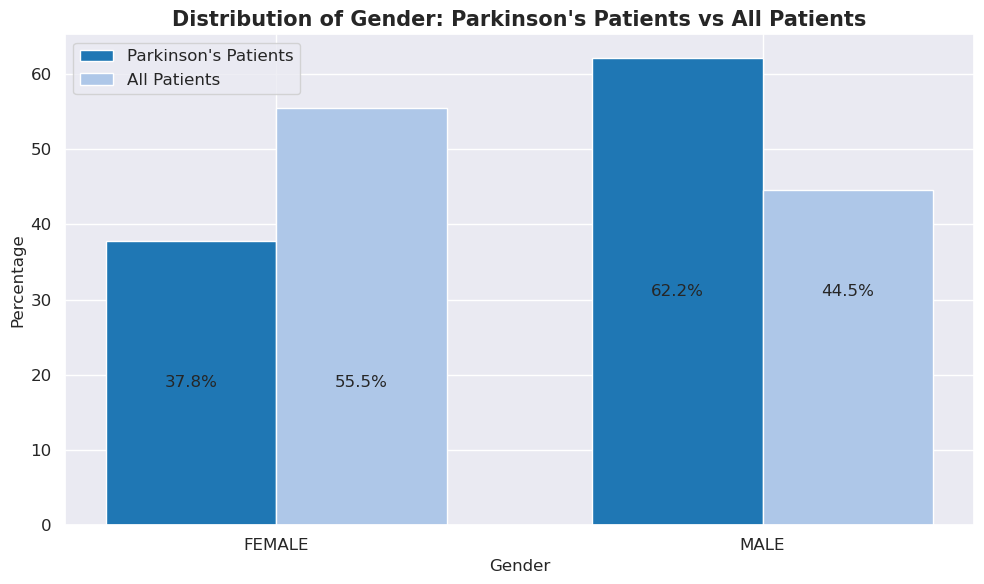

In [478]:
# Plotting the distribution of gender for PD patients vs. all patients
gender_counts = demographics['gender_source_value'].value_counts(normalize=True) * 100
gender_counts_all = demographics_all['gender_source_value'].value_counts(normalize=True)[:2] * 100 # Leaves out 'UNKNOWN' only 1 patient

# Combine percentages into a single DataFrame
combined_percentages = pd.DataFrame({
    "Parkinson's Patients": gender_counts,
    "All Patients": gender_counts_all
}).fillna(0)  # Fill NaN values with 0 in case some genders are missing in either group

# Plotting the percentage distribution of gender for both groups side by side
fig, ax = plt.subplots(figsize=(10, 6))

# Color map for the bar chart
colors = plt.cm.tab20.colors

# Calculate the width for each bar group
bar_width = 0.35

# Create the x positions for the bars
x = range(len(combined_percentages.index))

# Plot bars for Parkinson's patients
parkinsons_bars = ax.bar(x, combined_percentages["Parkinson's Patients"], width=bar_width, label="Parkinson's Patients", color=colors[0])

# Plot bars for all patients (shifted by bar_width)
all_patients_bars = ax.bar([i + bar_width for i in x], combined_percentages["All Patients"], width=bar_width, label="All Patients", color=colors[1])

# Set plot title and labels
ax.set_title("Distribution of Gender: Parkinson's Patients vs All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Gender', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.legend(fontsize=12)

# Set the x-axis ticks to be at the center of the bars
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(combined_percentages.index, fontsize=12)

# Add the percentage values inside each bar
for bar1, bar2 in zip(parkinsons_bars, all_patients_bars):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width() / 2, height1 / 2, f"{height1:.1f}%", ha='center', va='center', fontsize=12)
    ax.text(bar2.get_x() + bar2.get_width() / 2, height1 / 2, f"{height2:.1f}%", ha='center', va='center', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [479]:
demographics['gender_source_value'].value_counts(normalize=False) 

MALE      1693
FEMALE    1031
Name: gender_source_value, dtype: int64

In [480]:
demographics_all['gender_source_value'].value_counts(normalize=False) 

FEMALE     144929
MALE       116224
UNKNOWN         1
Name: gender_source_value, dtype: int64

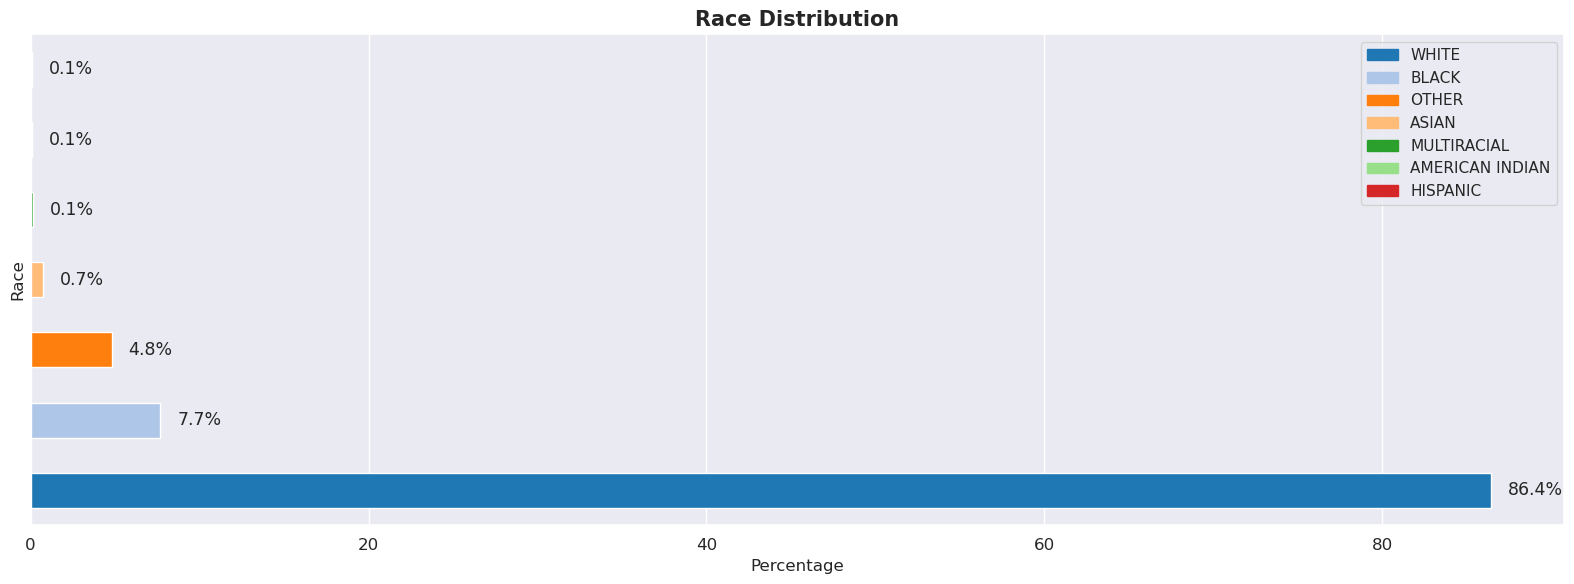

In [481]:
# Sample data (replace this with your actual data from the DataFrame)
race_counts = demographics['race_source_value'].value_counts(normalize=True) * 100

# Create a DataFrame from the data
race_df = pd.DataFrame({'Percentage': race_counts})

# Sort the DataFrame by percentage in descending order
race_df = race_df.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = race_df['Percentage'].plot(kind='barh', figsize=(16, 6), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title('Race Distribution', fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Race', fontsize=12)

# Add labels to the right of each bar
for i, v in enumerate(race_df['Percentage']):
    plt.text(v + 1, i, f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels
plt.yticks([])
plt.xticks(fontsize=12)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, race_counts.index)]

# Show the custom legend
plt.legend(handles=legend_patches, loc='best')

plt.tight_layout()
plt.show()

In [482]:
demographics['ethnicity_source_value'].value_counts()

NOT HISPANIC    2575
HISPANIC         125
Name: ethnicity_source_value, dtype: int64

In [483]:
race_counts

WHITE              86.437546
BLACK               7.686622
OTHER               4.804139
ASIAN               0.739098
MULTIRACIAL         0.147820
AMERICAN INDIAN     0.110865
HISPANIC            0.073910
Name: race_source_value, dtype: float64

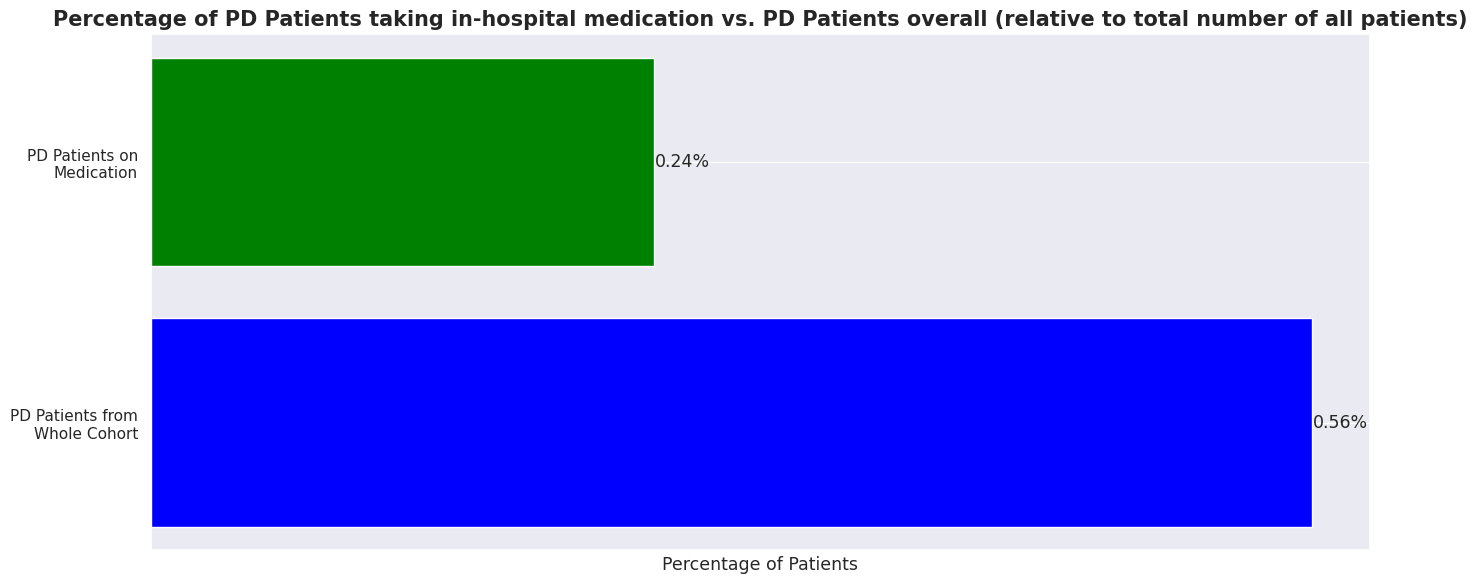

In [484]:
# Calculate the total number of patients in each dataset
total_patients_df = len(df['person_id'].unique())
total_patients_df_pd = len(df_pd['person_id'].unique())
total_patients_demographics_all = len(demographics_all['person_id'].unique())

# Calculate the percentage of PD patients from the whole cohort and PD patients on medication
percentage_pd_patients_df = (total_patients_df / total_patients_demographics_all) * 100
percentage_pd_patients = (total_patients_df_pd / total_patients_demographics_all) * 100

# Create the data for the horizontal bar plot
categories = ['PD Patients from\nWhole Cohort', 'PD Patients on\nMedication']
values = [percentage_pd_patients_df, percentage_pd_patients]

# Set the figure size for the horizontal bar plot
plt.figure(figsize=(14, 6))

# Plot the horizontal bar plot
plt.barh(categories, values, color=['blue', 'green'])
plt.xlabel('Percentage of Patients', fontsize=12.5)
plt.title('Percentage of PD Patients taking in-hospital medication vs. PD Patients overall (relative to total number of all patients)', fontsize=15, fontweight='bold')
plt.ylabel('')
plt.xticks([])

# Display the percentage values inside the bars
for i, v in enumerate(values):
    plt.text(v + 0.0005, i, f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Display the plot
plt.tight_layout()
plt.show()

In [485]:
percentage_pd_patients_df

0.5575254447567336

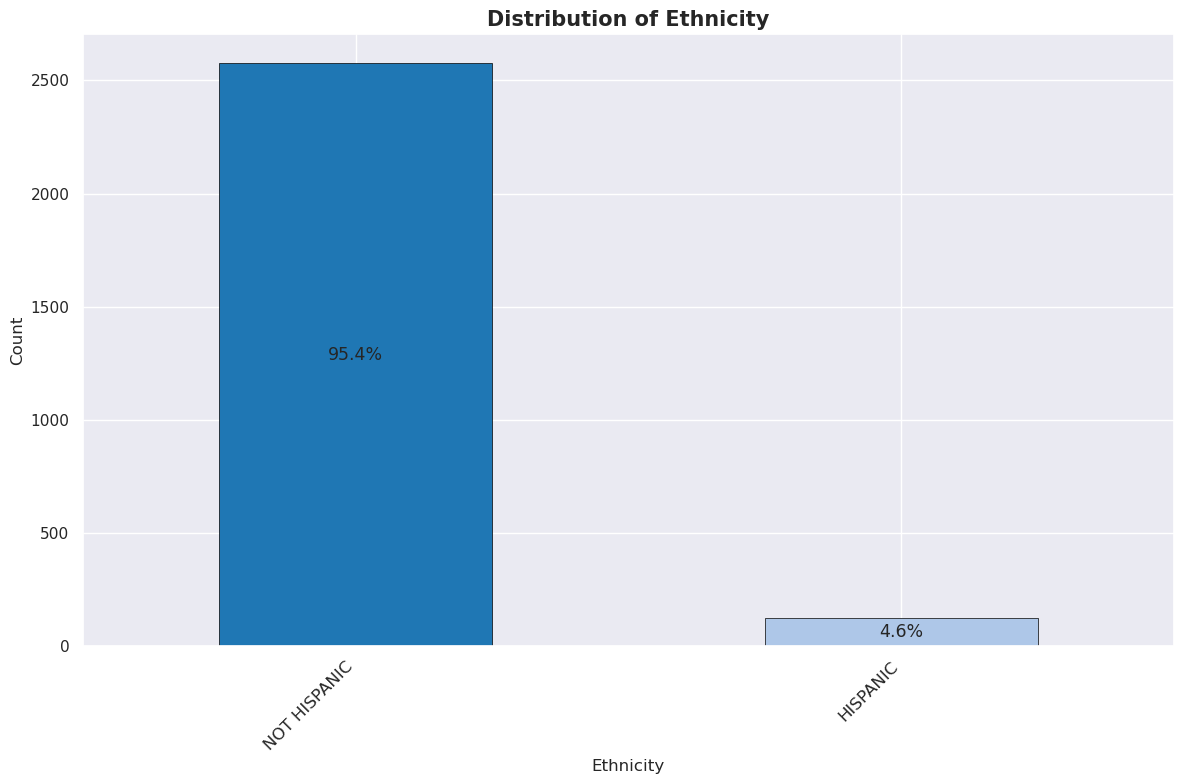

In [486]:
# Plotting value counts of race with percentages
ethnicity = demographics['ethnicity_source_value'].value_counts()
plt.figure(figsize=(12, 8))  # Adjust the values as per your desired size
labels = ethnicity.index
colors = plt.cm.tab20(np.arange(len(labels))) 
ax = ethnicity.plot(kind='bar', color=colors, edgecolor='black', linewidth=0.5)

# Calculate the percentages
total_count = ethnicity.sum()
percentages = [(count / total_count) * 100 for count in ethnicity]

# Display the percentages inside the bars
ax.bar_label(ax.containers[0], labels=[f"{percentage:.1f}%" for percentage in percentages], label_type='center', fontsize=12.5)

plt.title('Distribution of Ethnicity', fontsize=15, fontweight='bold')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

Actual actual way to deal with this lol

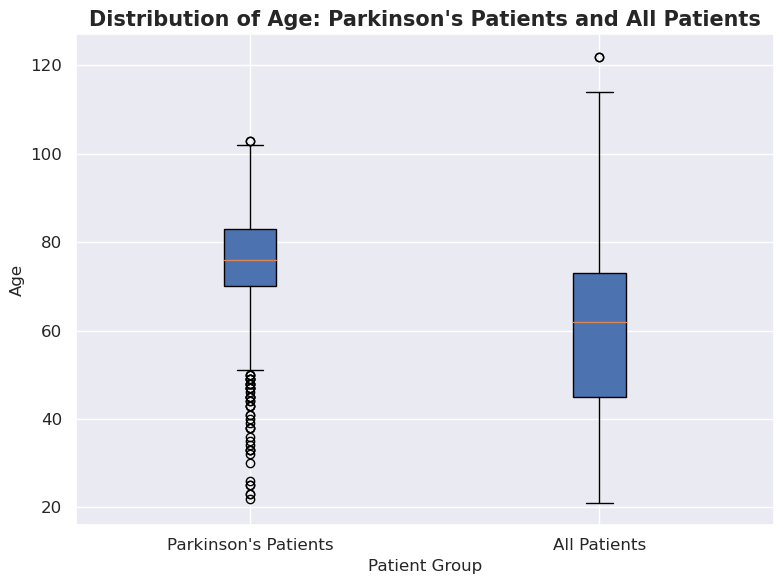

In [487]:
# Plotting the distribution of age for both groups using a box plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the box plot
ax.boxplot([demographics['age'], demographics_all['age']], labels=["Parkinson's Patients", "All Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Parkinson's Patients and All Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

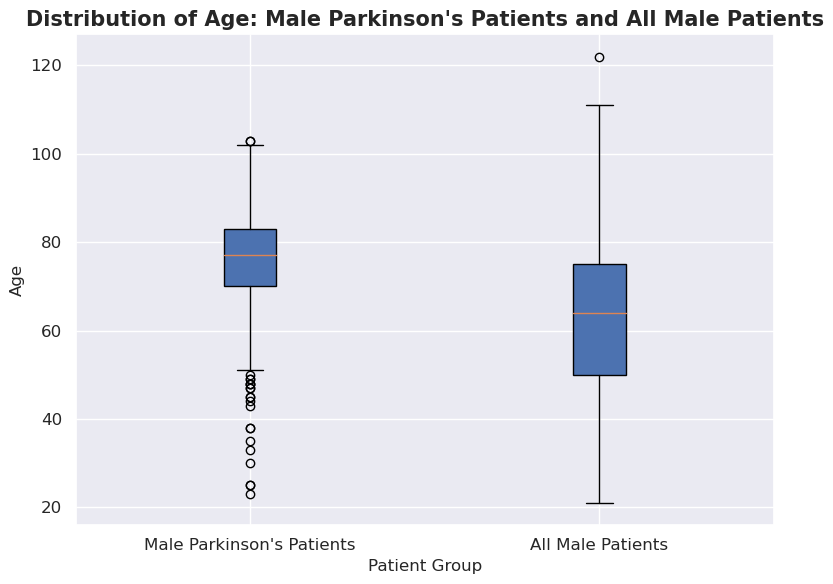

In [488]:
male_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'MALE']['age']
male_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'MALE']['age']# Plotting the distribution of age for both groups using a box plot

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, male_pd_patients_by_age_all], labels=["Male Parkinson's Patients", "All Male Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male Parkinson's Patients and All Male Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

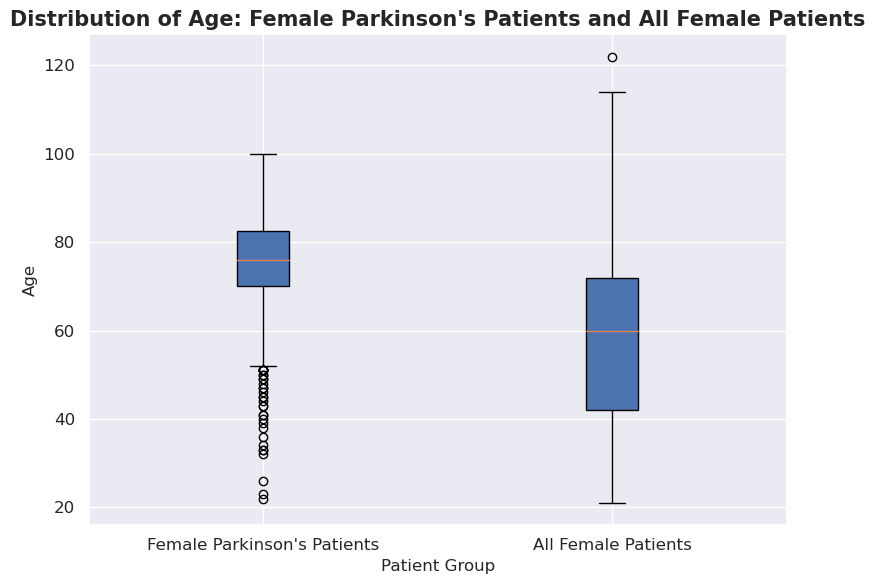

In [489]:
female_pd_patients_by_age = demographics[demographics['gender_source_value'] == 'FEMALE']['age']
female_pd_patients_by_age_all = demographics_all[demographics_all['gender_source_value'] == 'FEMALE']['age']

fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([female_pd_patients_by_age, female_pd_patients_by_age_all], labels=["Female Parkinson's Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Female Parkinson's Patients and All Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

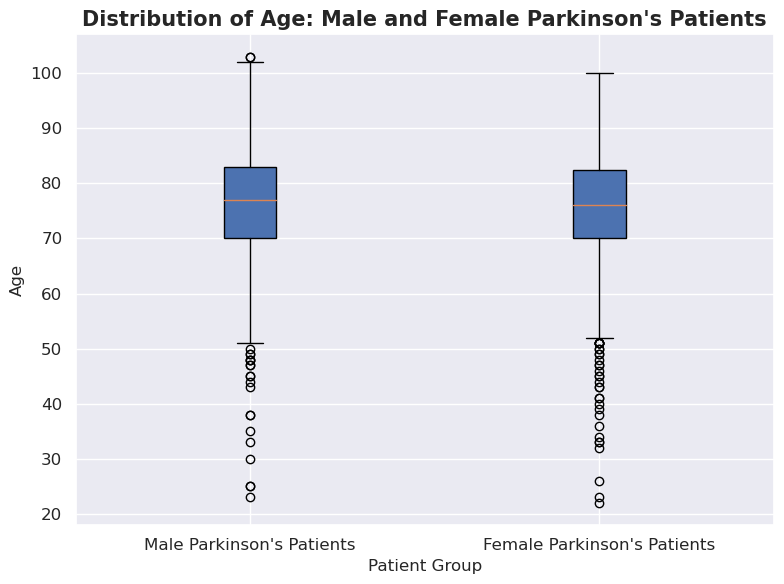

In [490]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age, female_pd_patients_by_age], labels=["Male Parkinson's Patients", "Female Parkinson's Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Parkinson's Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

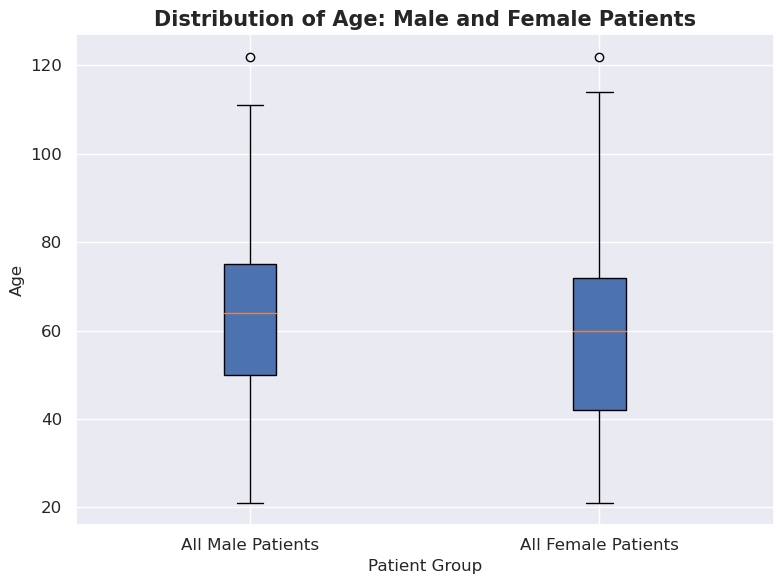

In [491]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the box plot
ax.boxplot([male_pd_patients_by_age_all, female_pd_patients_by_age_all], labels=["All Male Patients", "All Female Patients"], patch_artist=True)

# Set plot title and labels
ax.set_title("Distribution of Age: Male and Female Patients", fontsize=15, fontweight='bold')
ax.set_xlabel('Patient Group', fontsize=12)
ax.set_ylabel('Age', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [492]:
pd_data.value_counts(normalize=True)

generic_name                        brand_name  dosage      
carbidopa-levodopa                  sinemet     25-100 mg       0.477759
                                    sinemet cr  25-100 mg       0.070507
                                    sinemet     12.5-50 mg      0.051743
benztropine                         cogentin    1 mg            0.045095
carbidopa-levodopa                  sinemet cr  50-200 mg       0.042689
                                                                  ...   
carbidopa-levodopa er                rytary     95 mg           0.000087
tolcapone                           tasmar      100 mg          0.000087
amantadine er                       gocovri     274 mg          0.000087
rasagiline                          azilect     1 mg            0.000044
carbidopa and levodopa er capsules  rytary      61.25-245 mg    0.000044
Length: 80, dtype: float64

In [493]:
pd_data['brand_name'].value_counts(normalize=True)

sinemet          0.598478
sinemet cr       0.113196
cogentin         0.079561
mirapex          0.067095
symmetrel        0.038359
comtan           0.034860
artane           0.011022
azilect          0.010629
neupro           0.009972
requip           0.009185
stalevo          0.005336
eldepryl         0.004374
parcopa          0.003543
duopa            0.003543
lodosyn          0.003455
parlodel         0.001881
gocovri          0.001837
rytary           0.001531
tasmar           0.000700
dostinex         0.000350
apokyn           0.000306
ipx203-b16-03    0.000262
nourianz         0.000219
requip xl        0.000219
 rytary          0.000087
Name: brand_name, dtype: float64

## Distribution of drugs

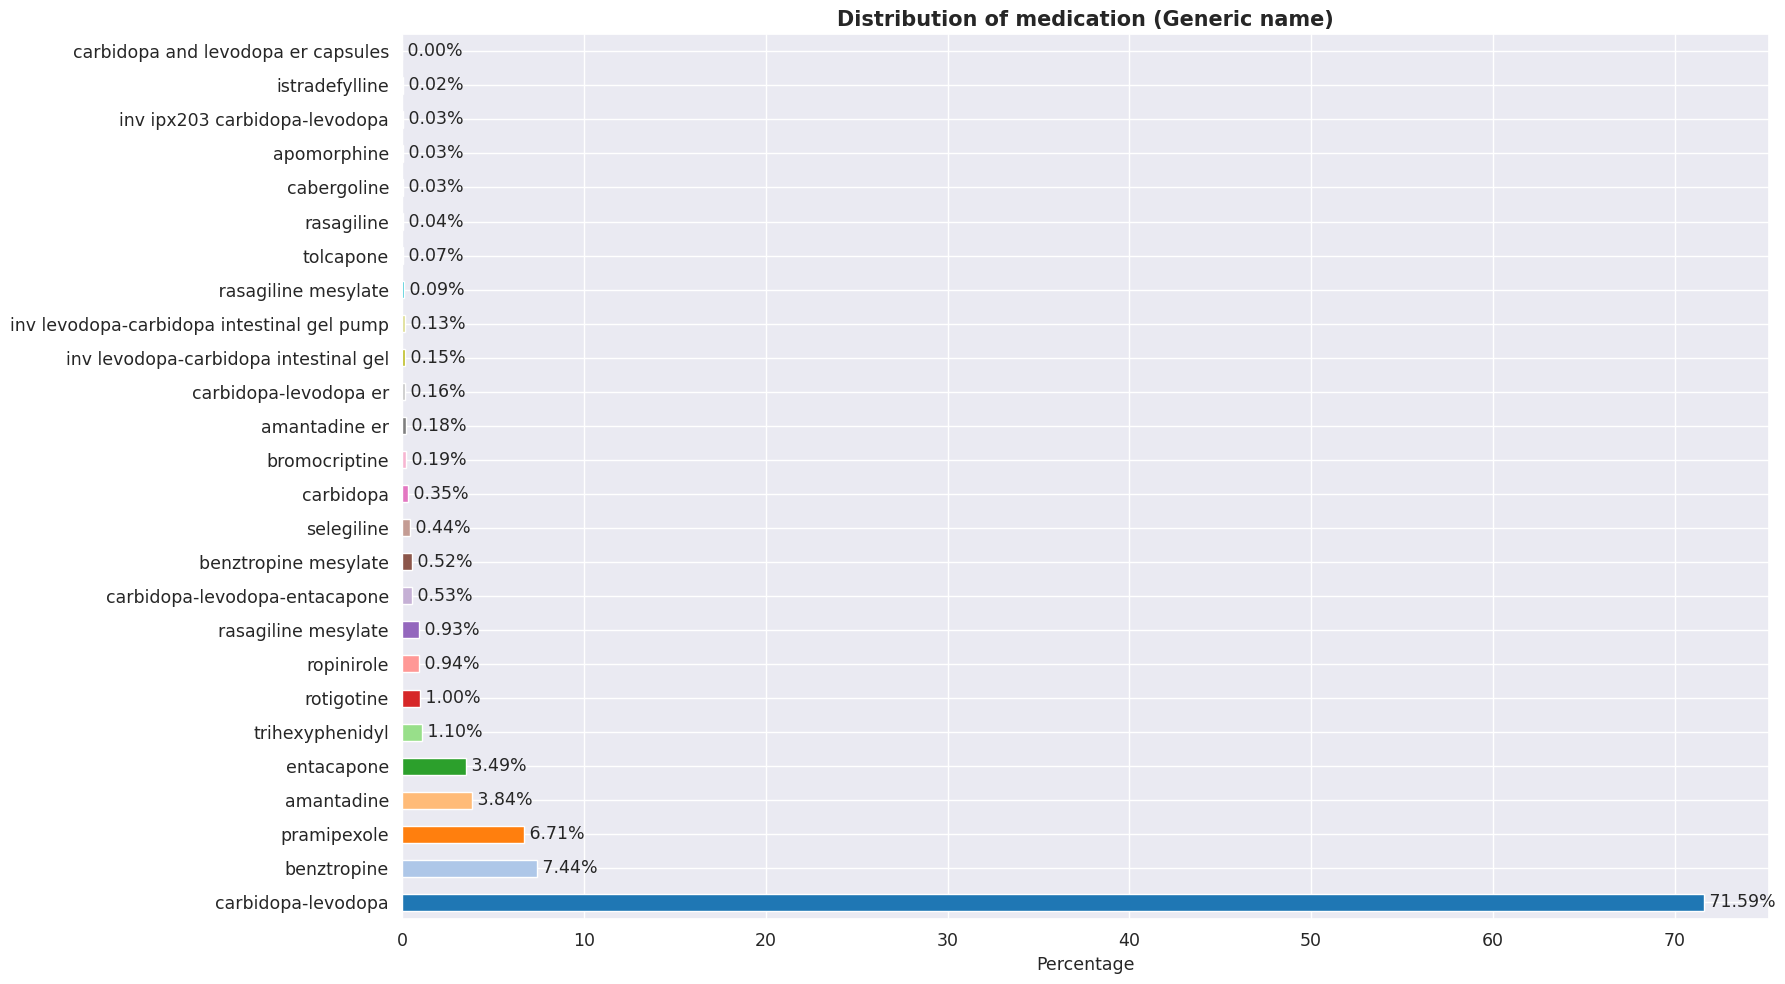

In [494]:
drug_distribution_count = df_pd['generic_name'].value_counts(normalize=True) * 100
drug_distribution = pd.DataFrame({'Percentage': drug_distribution_count})

# Sort the DataFrame by percentage in descending order
drug_distribution = drug_distribution.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_distribution['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Distribution of medication (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_distribution['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.2f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_distribution)), drug_distribution.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_distribution.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [495]:
len(pd_data) == len(df_pd)

True

In [496]:
df_pd.iloc[5187]

person_id                                                            248403
age                                                                      72
gender_source_value                                                  FEMALE
race_source_value                                                     BLACK
ethnicity_source_value                                         NOT HISPANIC
drug_source_value         {"med_display_name": "carbidopa-levodopa (SINE...
drug_info                 carbidopa-levodopa (SINEMET) 25-100 MG per tab...
generic_name                                             carbidopa-levodopa
brand_name                                                          sinemet
dosage                                                            25-100 mg
quantity                                                                1.0
dose_source_value                                                       1.0
dose_unit_source_value                                               tablet
note_text   

In [497]:
pd_data.iloc[5187]

generic_name    carbidopa-levodopa
brand_name                 sinemet
dosage                   25-100 mg
Name: 5187, dtype: object

In [498]:
len(pd_data[pd_data['brand_name'] == 'duopa']) == len(df_pd[df_pd['brand_name'] == 'duopa'])

True

<AxesSubplot: >

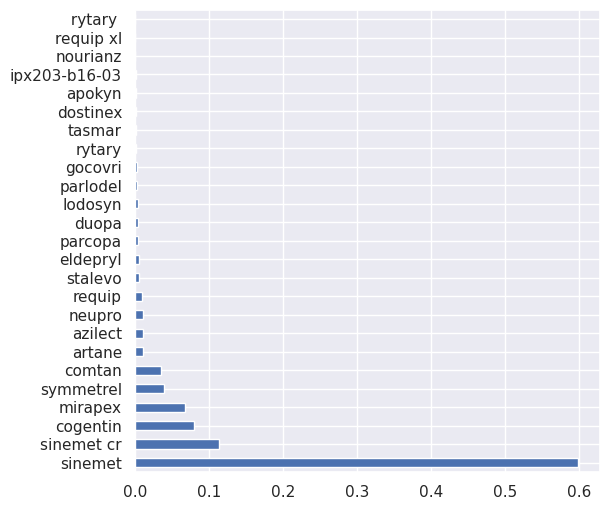

In [499]:
# vlalue_counts: Number of times each unique elements appears
medication_data = pd_data['brand_name'].value_counts(normalize=True)
medication_data.plot(kind='barh')

In [501]:
df_pd.groupby('brand_name')['person_id'].nunique()

brand_name
 rytary            1
apokyn             1
artane            19
azilect           38
cogentin          42
comtan            29
dostinex           1
duopa              3
eldepryl          13
gocovri            2
ipx203-b16-03      1
lodosyn            8
mirapex           65
neupro            22
nourianz           1
parcopa            5
parlodel           3
requip             8
requip xl          1
rytary             6
sinemet          526
sinemet cr       183
stalevo           11
symmetrel         72
tasmar             2
Name: person_id, dtype: int64

In [500]:
df_pd['brand_name'].nunique()

25

In [502]:
df_pd.columns

Index(['person_id', 'age', 'gender_source_value', 'race_source_value',
       'ethnicity_source_value', 'drug_source_value', 'drug_info',
       'generic_name', 'brand_name', 'dosage', 'quantity', 'dose_source_value',
       'dose_unit_source_value', 'note_text'],
      dtype='object')

In [503]:
# Drug usage per patient
drug_percentage = df_pd.groupby('race_source_value')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_percentage.sort_values(ascending=False)
# drug_percentage

race_source_value
WHITE          0.833597
BLACK          0.099842
OTHER          0.053883
ASIAN          0.007924
MULTIRACIAL    0.001585
Name: person_id, dtype: float64

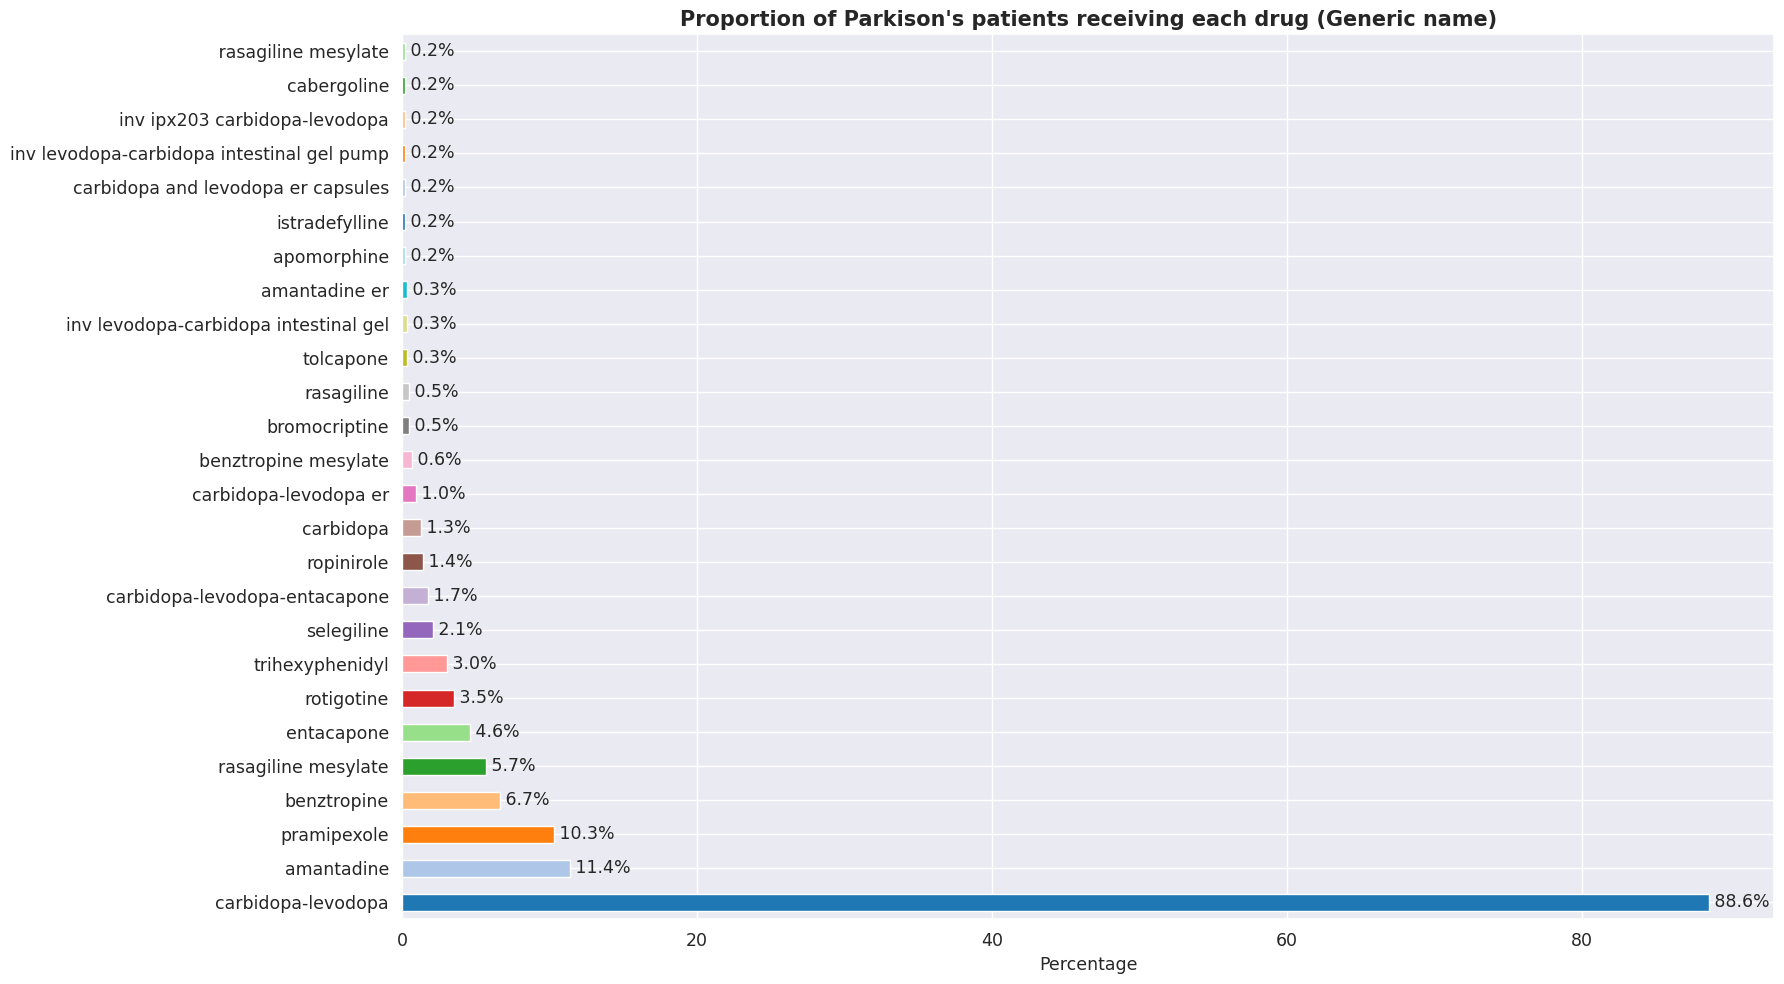

In [504]:
drug_percentage = df_pd.groupby('generic_name')['person_id'].nunique()/ df_pd['person_id'].nunique()
drug_popularity_count = drug_percentage * 100
drug_popularity = pd.DataFrame({'Percentage': drug_popularity_count})

# Sort the DataFrame by percentage in descending order
drug_popularity = drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Parkison's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(drug_popularity)), drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


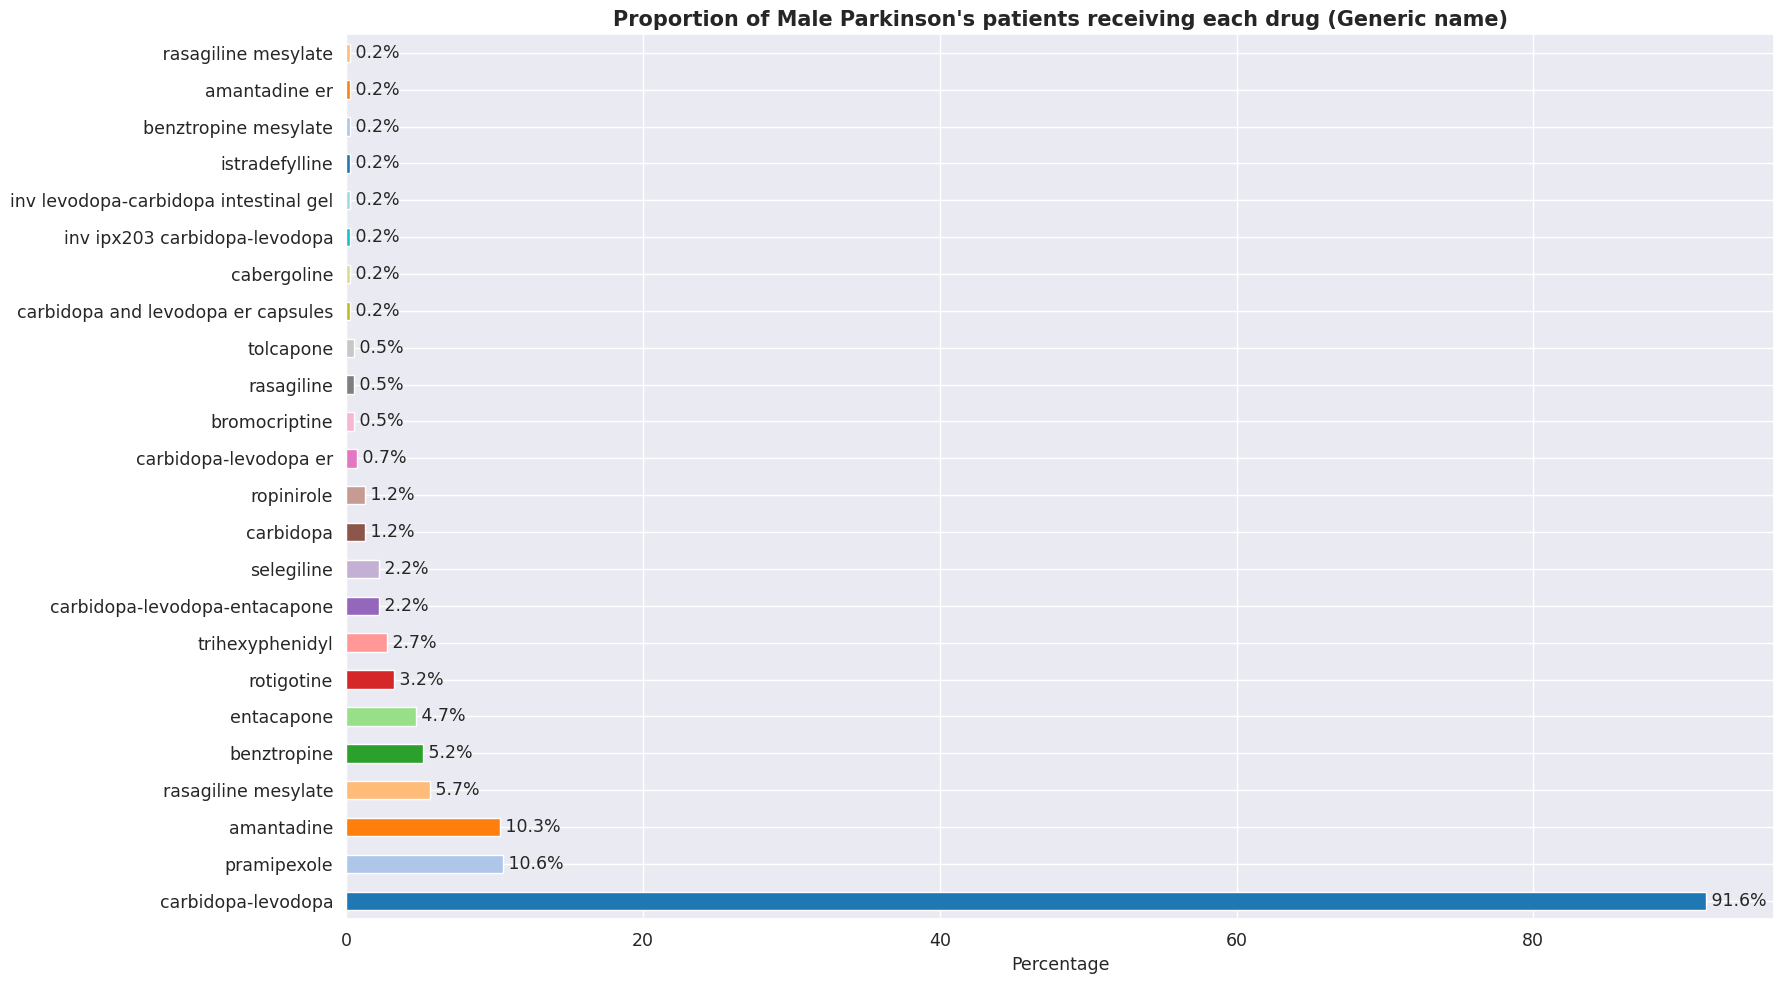

In [505]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
male_pd = df_pd[df_pd['gender_source_value'] == 'MALE']

# Calculate the drug percentage for males
male_drug_percentage = male_pd.groupby('generic_name')['person_id'].nunique() / male_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
male_drug_popularity_count = male_drug_percentage * 100
male_drug_popularity = pd.DataFrame({'Percentage': male_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
male_drug_popularity = male_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = male_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Male Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(male_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(male_drug_popularity)), male_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, male_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()


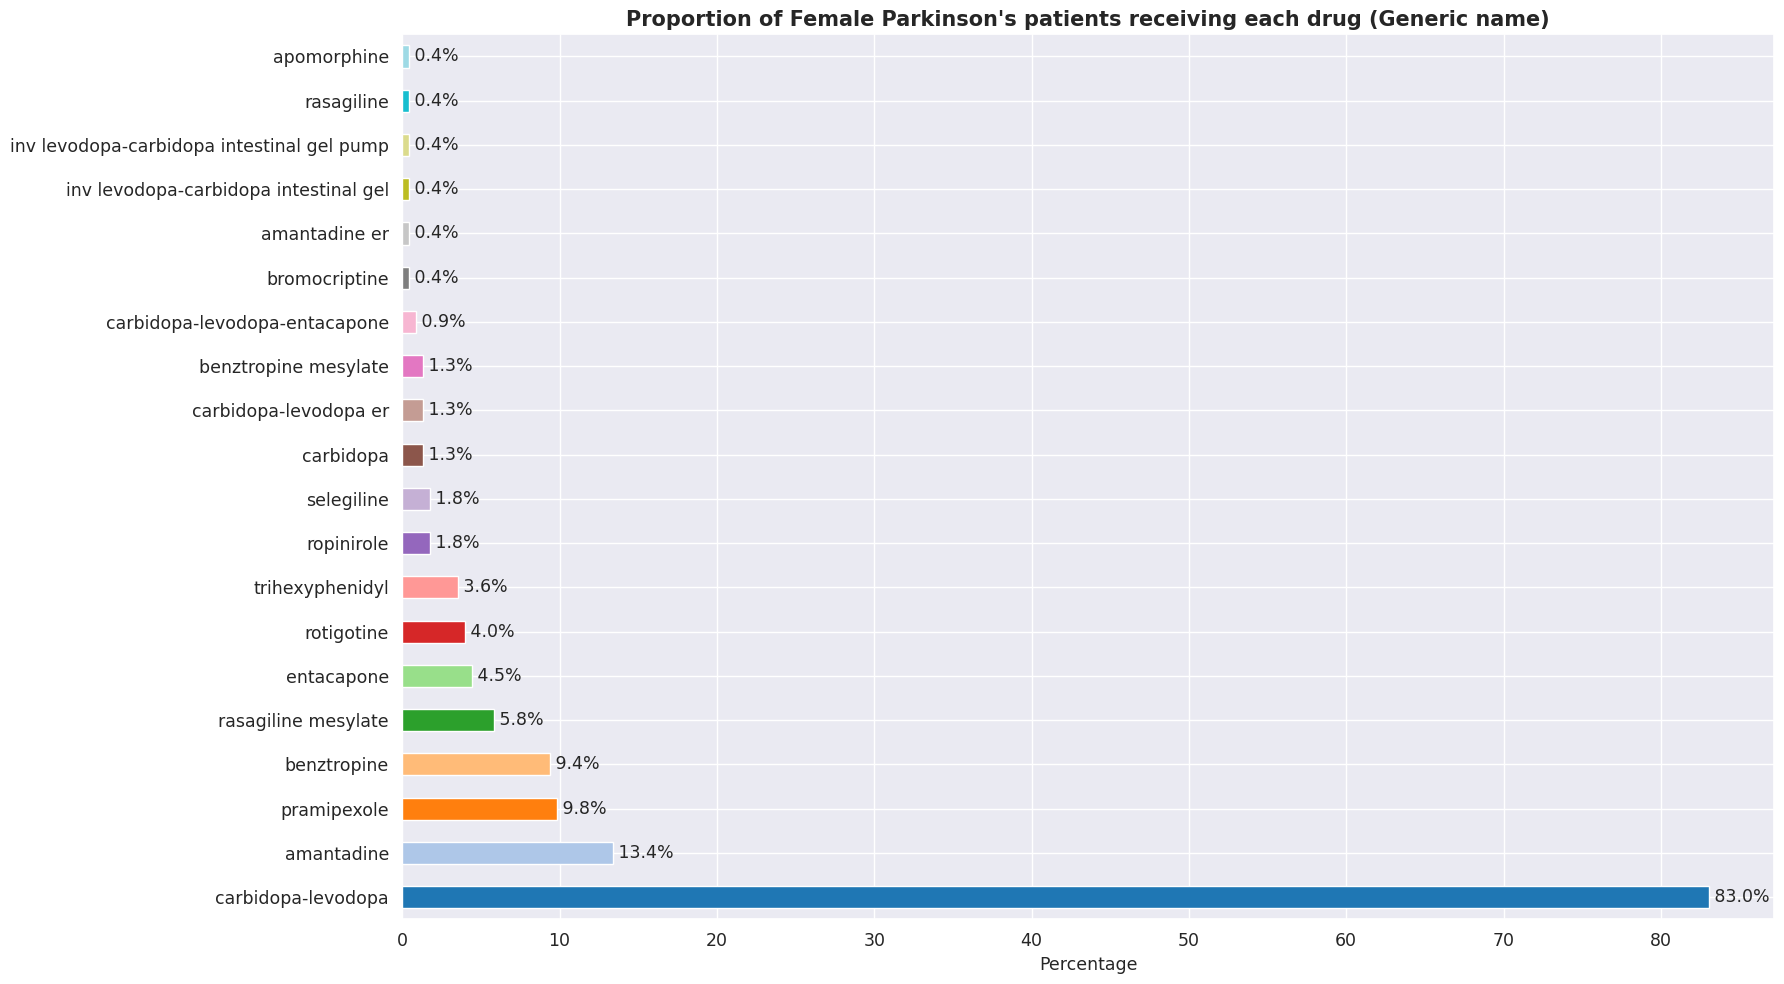

In [506]:
# Assuming df_pd is a DataFrame containing drug data and 'gender_source_value' is a column representing gender

# Filter the DataFrame for 'gender_source_value' == 'MALE'
female_pd = df_pd[df_pd['gender_source_value'] == 'FEMALE']

# Calculate the drug percentage for males
female_drug_percentage = female_pd.groupby('generic_name')['person_id'].nunique() / female_pd['person_id'].nunique()

# Calculate the percentage popularity of each drug for males
female_drug_popularity_count = female_drug_percentage * 100
female_drug_popularity = pd.DataFrame({'Percentage': female_drug_popularity_count})

# Sort the DataFrame by percentage in descending order
female_drug_popularity = female_drug_popularity.sort_values(by='Percentage', ascending=False)

# Create a horizontal bar chart with percentages as labels
ax = female_drug_popularity['Percentage'].plot(kind='barh', figsize=(18, 10), color=plt.cm.tab20.colors)

# Set the title and labels
plt.title("Proportion of Female Parkinson's patients receiving each drug (Generic name)", fontsize=15, fontweight='bold')
plt.xlabel('Percentage', fontsize=12.5)
plt.ylabel('')

# Add labels to the right of each bar
for i, v in enumerate(female_drug_popularity['Percentage']):
    plt.text(v + 0.0005, i, ' ' + f"{v:.1f}%", ha='left', va='center', fontsize=12.5)

# Remove y-axis labels and set drug names in their original order
plt.yticks(range(len(female_drug_popularity)), female_drug_popularity.index, fontsize=12.5)

plt.xticks(fontsize=12.5)

# Create custom legend elements
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors, female_drug_popularity.index)]

# Show the custom legend
# plt.legend(handles=legend_patches, loc='best', fontsize=12.5)

plt.tight_layout()
plt.show()

In [507]:
female_drug_popularity['Percentage']

generic_name
carbidopa-levodopa                            83.035714
amantadine                                    13.392857
pramipexole                                    9.821429
benztropine                                    9.375000
rasagiline mesylate                            5.803571
entacapone                                     4.464286
rotigotine                                     4.017857
trihexyphenidyl                                3.571429
ropinirole                                     1.785714
selegiline                                     1.785714
carbidopa                                      1.339286
carbidopa-levodopa er                          1.339286
benztropine mesylate                           1.339286
carbidopa-levodopa-entacapone                  0.892857
bromocriptine                                  0.446429
amantadine er                                  0.446429
inv levodopa-carbidopa intestinal gel          0.446429
inv levodopa-carbidopa intestinal g

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


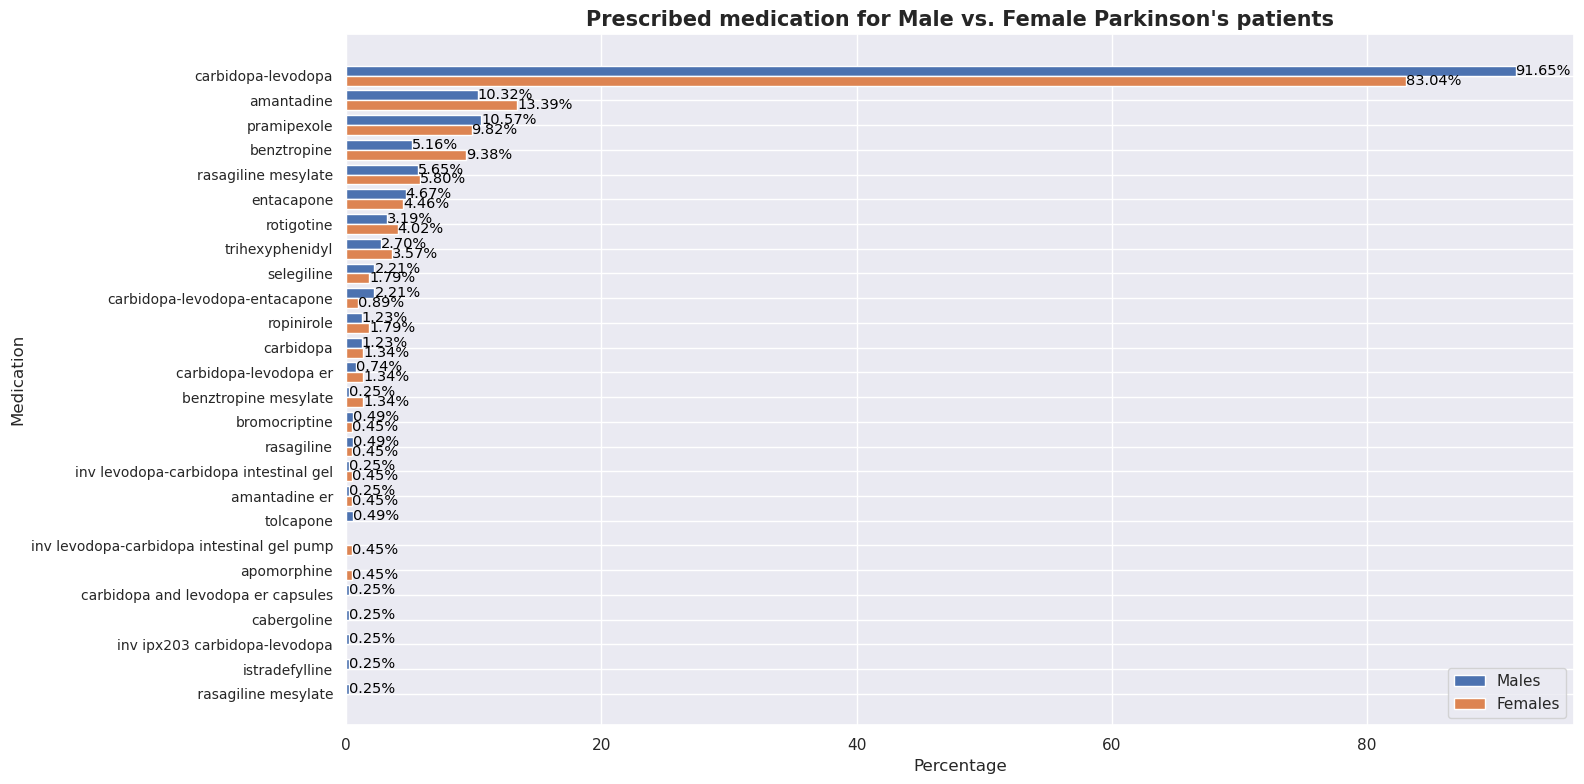

In [508]:
# Assuming you already have these variables as pandas Series
# male_drug_popularity and female_drug_popularity with 'Percentage' as the data and medication names as the index.

# Combine both male and female data for sorting
combined_data = pd.concat([male_drug_popularity, female_drug_popularity], axis=1)
combined_data.columns = ['Males', 'Females']

# Sort the medications based on the sum of percentages (sorting from higher to lower)
sorted_combined = combined_data.sum(axis=1).sort_values(ascending=False)

# Plotting the data as a horizontal bar plot
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

# Increase the width of the bars and adjust figure size for better spacing
width = 0.4

# Bar plot for males
ind_male = range(len(sorted_combined))
bars_male = plt.barh(ind_male, combined_data.loc[sorted_combined.index, 'Males'], height=width, label='Males')

# Bar plot for females
ind_female = [i + width for i in ind_male]
bars_female = plt.barh(ind_female, combined_data.loc[sorted_combined.index, 'Females'], height=width, label='Females')

# Adding percentages to the side of the bars
for i, val in enumerate(combined_data.loc[sorted_combined.index, 'Males']):
    plt.text(val, i, f'{val:.2f}%', va='center', fontsize=10.5, color='black')

for i, val in enumerate(combined_data.loc[sorted_combined.index, 'Females']):
    plt.text(val, i + width, f'{val:.2f}%', va='center', fontsize=10.5, color='black')

# Adding labels, titles, and customizing the plot
plt.xlabel('Percentage')
plt.ylabel('Medication')
plt.title('Prescribed medication for Male vs. Female Parkinson\'s patients', fontsize=15, fontweight='bold')
plt.yticks([i + width / 2 for i in ind_male], sorted_combined.index, fontsize=10)
plt.gca().invert_yaxis()
plt.legend(loc='lower right')  # Move the legend to upper right for better spacing
plt.tight_layout()
plt.show()


In [509]:
df_pd['generic_name'].value_counts(normalize=True) * 100

carbidopa-levodopa                            71.591655
benztropine                                    7.435595
pramipexole                                    6.709531
amantadine                                     3.835892
entacapone                                     3.485982
trihexyphenidyl                                1.102218
rotigotine                                     0.997244
ropinirole                                     0.940384
rasagiline mesylate                            0.931636
carbidopa-levodopa-entacapone                  0.533613
benztropine mesylate                           0.520492
selegiline                                     0.437388
carbidopa                                      0.345536
bromocriptine                                  0.188077
amantadine er                                  0.183703
carbidopa-levodopa er                          0.157460
inv levodopa-carbidopa intestinal gel          0.153086
inv levodopa-carbidopa intestinal gel pump     0

In [510]:
drug_percentage

generic_name
 rasagiline mesylate                          0.001585
amantadine                                    0.114105
amantadine er                                 0.003170
apomorphine                                   0.001585
benztropine                                   0.066561
benztropine mesylate                          0.006339
bromocriptine                                 0.004754
cabergoline                                   0.001585
carbidopa                                     0.012678
carbidopa and levodopa er capsules            0.001585
carbidopa-levodopa                            0.885895
carbidopa-levodopa er                         0.009509
carbidopa-levodopa-entacapone                 0.017433
entacapone                                    0.045959
inv ipx203 carbidopa-levodopa                 0.001585
inv levodopa-carbidopa intestinal gel         0.003170
inv levodopa-carbidopa intestinal gel pump    0.001585
istradefylline                                0.0015

## Calculating LED (Levodopa Dose Equivalent) for Parkinson's patients

In [511]:
# sig stablished how the medication should be taken by the patient
formatted_series = df_pd['dose_source_value'].unique()
format_func = np.vectorize(lambda x: '{:.4}'.format(x))
bla = np.sort(format_func(formatted_series))
bla

array(['0.0', '0.125', '0.25', '0.33', '0.375', '0.5', '0.75', '1.0',
       '1.25', '1.5', '1.75', '100.0', '12.5', '137.0', '2.0', '2.5',
       '20.0', '200.0', '25.0', '274.0', '3.0', '3.5', '32.0', '4.0',
       '40.0', '5.0', '50.0', '8.0', 'nan'], dtype='<U5')

In [512]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79362  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79363  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79364  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79365  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
79361          12629.0  
79362          12629.0  
79363          12629.0  
79364          12629.0  
79365          12629.0  

[79366 rows x 8 columns]

In [513]:
rasagiline_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '1mg'].index
pd_data_drug_exposure.loc[rasagiline_index, 'dosage'] = '1 mg'
pd_data_drug_exposure.iloc[rasagiline_index]['dosage']

12755    1 mg
12756    1 mg
39243    1 mg
39244    1 mg
Name: dosage, dtype: object

In [514]:
entacapone_index = pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '200mg'].index
pd_data_drug_exposure.loc[entacapone_index, 'dosage'] = '200 mg'
pd_data_drug_exposure.iloc[entacapone_index]['dosage']

15678    200 mg
15679    200 mg
15680    200 mg
15681    200 mg
15682    200 mg
15683    200 mg
15684    200 mg
15685    200 mg
15686    200 mg
15687    200 mg
15688    200 mg
15689    200 mg
15690    200 mg
15691    200 mg
15692    200 mg
15693    200 mg
15694    200 mg
15695    200 mg
15696    200 mg
15697    200 mg
15698    200 mg
15699    200 mg
15700    200 mg
15701    200 mg
15702    200 mg
15703    200 mg
15704    200 mg
15705    200 mg
15706    200 mg
15707    200 mg
Name: dosage, dtype: object

In [515]:
pd_data_drug_exposure['dosage']

0        25-100 mg
1        25-100 mg
2        25-100 mg
3        25-100 mg
4        25-100 mg
           ...    
79361    25-100 mg
79362    25-100 mg
79363    25-100 mg
79364    25-100 mg
79365    25-100 mg
Name: dosage, Length: 79366, dtype: object

In [516]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '200 mg', '1 mg',
       '25-250 mg', '8 mg', '2 mg', '1.5 mg', '5 mg', '48.75-195 mg',
       '12.5-50 mg', '37.5-150-200 mg', '0.125 mg', '4 mg',
       '36.25-145 mg', nan, '25 mg', '6 mg', '0.25 mg', '3 mg',
       '12.5-125 mg', '23.75-95 mg', '129 mg', '61.25-245 mg',
       '10-100 mg', '12 mg', '1 ml', '137 mg', '4.63-20 mg/ml',
       '5-20 mg/ml', '50 mg', '2.5 mg', '20-5mg/ml', '52.5-210 mg',
       '18.75-75-200 mg', '25-100-200 mg', '50-200-200 mg', '0.4 ml',
       '31.25-125-200 mg', '0.375 mg', '0.75 mg', '2.25 mg', '6mg',
       '1.25-5 mg/ml', '25mg', '1.25 mg', '100 ml', '95 mg', '100mg',
       '274 mg', '24 mg', '5mg', '150 mg', '10 mg', '8mg', '1.125 mg',
       '12.5-50-200 mg', '0.5-1 mg', '12.5 mg', '400 mg', '600 mg',
       '12mg', '20 ml', '75 mg', '37.5 mg', '0.6 ml', '3mg'], dtype=object)

In [517]:
pd_data_drug_exposure['dosage'].unique()[0].split('-')[1].split()[0]

'100'

In [518]:
led_dose = []
for index, item in enumerate(pd_data_drug_exposure['dosage']):
    if isinstance(item, (float, np.floating)) and np.isnan(item):
        led_dose.append('0')
    else:
        if '-' in item:
            dosage = item.split('-')[1].split()[0]
            led_dose.append(dosage)
        else:
            dosage = item.split()[0]
            led_dose.append(dosage)

In [519]:
len(led_dose)

79366

In [520]:
len(pd_data_drug_exposure)

79366

In [521]:
for index, item in enumerate(pd_data_drug_exposure['generic_name']):
    if 'levodopa-carbidopa' in item:
        print(item)

inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel pump
inv levodopa-carbidopa intestinal gel pump
inv levodopa-carbidopa intestinal gel pump
inv levodopa-carbidopa intestinal gel pump
inv levodopa-carbidopa intestinal gel pump
inv levodopa-carbidopa intestinal gel pump
inv levodopa-carbidopa intestinal gel pump
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel
inv levodopa-carbidopa intestinal gel pump stop
inv levodopa-carbidopa intestinal gel pump stop
inv levodopa-carbidopa intestinal gel pump stop
inv levodopa-carbidopa intestinal gel pump stop
inv levodopa-carbidopa intestinal gel pump stop
inv levodopa-carbidopa or placebo
inv levodopa-carbidopa or placebo
inv levodop

In [522]:
pd_data_drug_exposure['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'entacapone',
       'rasagiline mesylate', 'pramipexole', 'ropinirole',
       'benztropine mesylate', 'selegiline', 'carbidopa-levodopa er',
       'carbidopa-levodopa-entacapone', 'trihexyphenidyl',
       'pramipexole dihydrochloride tb24 1', 'carbidopa', 'rotigotine',
       'amantadine hcl er tb24 129', 'carbidopa and levodopa er capsules',
       'non-formulary carbidopa-levodopa er', 'apomorphine',
       'amantadine er', ' rasagiline mesylate',
       'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump',
       'inv levodopa-carbidopa intestinal gel',
       'inv levodopa-carbidopa intestinal gel pump',
       'inv rasagiline or placebo 1 mg', 'nf selegiline 5 mg',
       'rasagiline', 'cabergoline', 'inv ipx203 carbidopa-levodopa',
       'ropinirole hcl tb24 12', 'pramipexole er', 'ropinirole hcl',
       'ropinirole hcl tb24 6', 'bromocriptine', 'tolcapone',
       'inv levodop

In [523]:
pd_data_drug_exposure

generic_name brand_name     dosage
0      carbidopa-levodopa    sinemet  25-100 mg
1      carbidopa-levodopa    sinemet  25-100 mg
2      carbidopa-levodopa    sinemet  25-100 mg
3      carbidopa-levodopa    sinemet  25-100 mg
4      carbidopa-levodopa    sinemet  25-100 mg
...                   ...        ...        ...
79361  carbidopa-levodopa    sinemet  25-100 mg
79362  carbidopa-levodopa    sinemet  25-100 mg
79363  carbidopa-levodopa    sinemet  25-100 mg
79364  carbidopa-levodopa    sinemet  25-100 mg
79365  carbidopa-levodopa    sinemet  25-100 mg

[79366 rows x 3 columns]

In [524]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79362  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79363  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79364  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79365  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
79361          12629.0  
79362          12629.0  
79363          12629.0  
79364          12629.0  
79365          12629.0  

[79366 rows x 8 columns]

In [525]:
len(df_pd)

22863

In [526]:
led_df = pd.concat([drug_exposure.iloc[:, 0:3], pd_data_drug_exposure, drug_exposure.iloc[:, 3:]], axis=1)

In [527]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value        generic_name  \
0      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
1      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
2      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
3      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
4      {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
...                                                  ...                 ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
79362  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
79363  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
79364  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   
79365  {"med_display_name": "carbidopa-levodopa (SINE...  carbidopa-levodopa   

      brand_name     dosage  dose_source_value dose_unit_source_value  \
0        sinemet  25-100 mg                2.0                 tablet   
1        sinemet  25-100 mg                2.0                 tablet   
2        sinemet  25-100 mg                2.0                 tablet   
3        sinemet  25-100 mg                2.0                 tablet   
4        sinemet  25-100 mg                2.0                 tablet   
...          ...        ...                ...                    ...   
79361    sinemet  25-100 mg                1.0                 tablet   
79362    sinemet  25-100 mg                1.0                 tablet   
79363    sinemet  25-100 mg                1.0                 tablet   
79364    sinemet  25-100 mg                1.0                 tablet   
79365    sinemet  25-100 mg                1.0                 tablet   

      route_source_value  visit_occurrence_id  visit_detail_id  
0                   ORAL             40422623        9880783.0  
1                   ORAL             40422623        9880783.0  
2                   ORAL             40422623        9880783.0  
3                   ORAL             40422623        9880783.0  
4                   ORAL             40422623        9880783.0  
...                  ...                  ...              ...  
79361               ORAL               104832          12629.0  
79362               ORAL               104832          12629.0  
79363               ORAL               104832          12629.0  
79364               ORAL               104832          12629.0  
79365               ORAL               104832          12629.0  

[79366 rows x 11 columns]

In [528]:
drug_info_drug_source_value

{0: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 1: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 2: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 3: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 4: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 5: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 6: 'carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet',
 7: 'amantadine (SYMMETREL) capsule 100 mg',
 8: 'amantadine (SYMMETREL) capsule 100 mg',
 9: 'amantadine (SYMMETREL) capsule 100 mg',
 10: 'amantadine (SYMMETREL) capsule 100 mg',
 11: 'amantadine (SYMMETREL) capsule 100 mg',
 12: 'amantadine (SYMMETREL) capsule 100 mg',
 13: 'amantadine (SYMMETREL) capsule 100 mg',
 14: 'amantadine (SYMMETREL) capsule 100 mg',
 15: 'amantadine (SYMMETREL) capsule 100 mg',
 16: 'amantadine (SYMMETREL) capsule 100 mg',
 17: 'amantadine (SYMMETREL) capsule 100 mg',
 18: 'amantadine (SYMMETREL) capsul

In [529]:
len(led_dose)

79366

In [530]:
led_df.insert(loc=6, column="led_dose", value=led_dose)
led_df.insert(loc=3, column="drug_info", value=drug_info_drug_source_value)
# Properly handling the led_dose and drug_exposure_start_datetime colums
led_df['led_dose'] = pd.to_numeric(led_df['led_dose'], errors='coerce') # Coverting this column to a float type and handling uncommon values
led_df['drug_exposure_start_datetime'] = pd.to_datetime(led_df['drug_exposure_start_datetime'])

In [531]:
len(drug_exposure)

79366

In [532]:
len(pd_data_drug_exposure)

79366

In [533]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79362  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79363  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79364  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79365  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
79361          12629.0  
79362          12629.0  
79363          12629.0  
79364          12629.0  
79365          12629.0  

[79366 rows x 8 columns]

In [534]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...   
79362  {"med_display_name": "carbidopa-levodopa (SINE...   
79363  {"med_display_name": "carbidopa-levodopa (SINE...   
79364  {"med_display_name": "carbidopa-levodopa (SINE...   
79365  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
79361  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79362  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79363  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79364  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79365  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  led_dose  dose_source_value  \
0        sinemet  25-100 mg     100.0                2.0   
1        sinemet  25-100 mg     100.0                2.0   
2        sinemet  25-100 mg     100.0                2.0   
3        sinemet  25-100 mg     100.0                2.0   
4        sinemet  25-100 mg     100.0                2.0   
...          ...        ...       ...                ...   
79361    sinemet  25-100 mg     100.0                1.0   
79362    sinemet  25-100 mg     100.0                1.0   
79363    sinemet  25-100 mg     100.0                1.0   
79364    sinemet  25-100 mg     100.0                1.0   
79365    sinemet  25-100 mg     100.0                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  


Esta bieeeeeeeeeeeeeeeeeeen y funciona

In [535]:
dl = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, tem in enumerate(dl):
    print(index, led_df['person_id'].iloc[index], dl[index]['mar_action'], led_df['drug_source_value'].iloc[index])
len(dl)

0 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
1 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
2 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
3 261006 HELD {"med_display_name": "carbidopa-levodopa (SINEMET) 25-100 MG per tablet 2 tablet", "rxnorm_concat": "| 197444 |", "med_dose_unit_desc": "tablet", "mar_action": "GIVEN", "med_order_desc": "CARBIDOPA-LEVODOPA 25-100 MG PO TABS"}
4 261006 HELD {"med_display_name": "

3557

In [536]:
type(led_df[led_df['dose_source_value'] == 0.0]['drug_source_value'])

pandas.core.series.Series

In [537]:
type(led_df.loc[led_df['dose_source_value'] == 0.0, ['drug_source_value']])

pandas.core.frame.DataFrame

In [538]:
bla = [json.loads(x) for x in led_df[led_df['dose_source_value'] == 0.0]['drug_source_value']]
for index, item in enumerate(bla):
    print(bla[index]['mar_action'])

HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD
HELD


We lose 59% percent of patients because their medication was held

In [539]:
print(len(dl)*100/len(df_pd))

15.5578882911254


In [540]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '200 mg', '1 mg',
       '25-250 mg', '8 mg', '2 mg', '1.5 mg', '5 mg', '48.75-195 mg',
       '12.5-50 mg', '37.5-150-200 mg', '0.125 mg', '4 mg',
       '36.25-145 mg', nan, '25 mg', '6 mg', '0.25 mg', '3 mg',
       '12.5-125 mg', '23.75-95 mg', '129 mg', '61.25-245 mg',
       '10-100 mg', '12 mg', '1 ml', '137 mg', '4.63-20 mg/ml',
       '5-20 mg/ml', '50 mg', '2.5 mg', '20-5mg/ml', '52.5-210 mg',
       '18.75-75-200 mg', '25-100-200 mg', '50-200-200 mg', '0.4 ml',
       '31.25-125-200 mg', '0.375 mg', '0.75 mg', '2.25 mg', '6mg',
       '1.25-5 mg/ml', '25mg', '1.25 mg', '100 ml', '95 mg', '100mg',
       '274 mg', '24 mg', '5mg', '150 mg', '10 mg', '8mg', '1.125 mg',
       '12.5-50-200 mg', '0.5-1 mg', '12.5 mg', '400 mg', '600 mg',
       '12mg', '20 ml', '75 mg', '37.5 mg', '0.6 ml', '3mg'], dtype=object)

In [541]:
pd_data_drug_exposure[pd_data_drug_exposure['dosage'] == '0.5 mg']

generic_name brand_name  dosage
88     benztropine   cogentin  0.5 mg
89     benztropine   cogentin  0.5 mg
90     benztropine   cogentin  0.5 mg
91     benztropine   cogentin  0.5 mg
92     benztropine   cogentin  0.5 mg
...            ...        ...     ...
77615  pramipexole    mirapex  0.5 mg
77616  pramipexole    mirapex  0.5 mg
78580   ropinirole     requip  0.5 mg
78581   ropinirole     requip  0.5 mg
78582   ropinirole     requip  0.5 mg

[2478 rows x 3 columns]

In [542]:
pd_data_drug_exposure['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '200 mg', '1 mg',
       '25-250 mg', '8 mg', '2 mg', '1.5 mg', '5 mg', '48.75-195 mg',
       '12.5-50 mg', '37.5-150-200 mg', '0.125 mg', '4 mg',
       '36.25-145 mg', nan, '25 mg', '6 mg', '0.25 mg', '3 mg',
       '12.5-125 mg', '23.75-95 mg', '129 mg', '61.25-245 mg',
       '10-100 mg', '12 mg', '1 ml', '137 mg', '4.63-20 mg/ml',
       '5-20 mg/ml', '50 mg', '2.5 mg', '20-5mg/ml', '52.5-210 mg',
       '18.75-75-200 mg', '25-100-200 mg', '50-200-200 mg', '0.4 ml',
       '31.25-125-200 mg', '0.375 mg', '0.75 mg', '2.25 mg', '6mg',
       '1.25-5 mg/ml', '25mg', '1.25 mg', '100 ml', '95 mg', '100mg',
       '274 mg', '24 mg', '5mg', '150 mg', '10 mg', '8mg', '1.125 mg',
       '12.5-50-200 mg', '0.5-1 mg', '12.5 mg', '400 mg', '600 mg',
       '12mg', '20 ml', '75 mg', '37.5 mg', '0.6 ml', '3mg'], dtype=object)

In [543]:
led_df['dosage'].unique()

array(['25-100 mg', '100 mg', '0.5 mg', '50-200 mg', '200 mg', '1 mg',
       '25-250 mg', '8 mg', '2 mg', '1.5 mg', '5 mg', '48.75-195 mg',
       '12.5-50 mg', '37.5-150-200 mg', '0.125 mg', '4 mg',
       '36.25-145 mg', nan, '25 mg', '6 mg', '0.25 mg', '3 mg',
       '12.5-125 mg', '23.75-95 mg', '129 mg', '61.25-245 mg',
       '10-100 mg', '12 mg', '1 ml', '137 mg', '4.63-20 mg/ml',
       '5-20 mg/ml', '50 mg', '2.5 mg', '20-5mg/ml', '52.5-210 mg',
       '18.75-75-200 mg', '25-100-200 mg', '50-200-200 mg', '0.4 ml',
       '31.25-125-200 mg', '0.375 mg', '0.75 mg', '2.25 mg', '6mg',
       '1.25-5 mg/ml', '25mg', '1.25 mg', '100 ml', '95 mg', '100mg',
       '274 mg', '24 mg', '5mg', '150 mg', '10 mg', '8mg', '1.125 mg',
       '12.5-50-200 mg', '0.5-1 mg', '12.5 mg', '400 mg', '600 mg',
       '12mg', '20 ml', '75 mg', '37.5 mg', '0.6 ml', '3mg'], dtype=object)

In [544]:
set(led_dose)

{'0',
 '0.125',
 '0.25',
 '0.375',
 '0.4',
 '0.5',
 '0.6',
 '0.75',
 '1',
 '1.125',
 '1.25',
 '1.5',
 '10',
 '100',
 '100mg',
 '12',
 '12.5',
 '125',
 '129',
 '12mg',
 '137',
 '145',
 '150',
 '195',
 '2',
 '2.25',
 '2.5',
 '20',
 '200',
 '210',
 '24',
 '245',
 '25',
 '250',
 '25mg',
 '274',
 '3',
 '37.5',
 '3mg',
 '4',
 '400',
 '5',
 '50',
 '5mg',
 '5mg/ml',
 '6',
 '600',
 '6mg',
 '75',
 '8',
 '8mg',
 '95'}

In [545]:
led_df['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine', 'entacapone',
       'rasagiline mesylate', 'pramipexole', 'ropinirole',
       'benztropine mesylate', 'selegiline', 'carbidopa-levodopa er',
       'carbidopa-levodopa-entacapone', 'trihexyphenidyl',
       'pramipexole dihydrochloride tb24 1', 'carbidopa', 'rotigotine',
       'amantadine hcl er tb24 129', 'carbidopa and levodopa er capsules',
       'non-formulary carbidopa-levodopa er', 'apomorphine',
       'amantadine er', ' rasagiline mesylate',
       'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump',
       'inv levodopa-carbidopa intestinal gel',
       'inv levodopa-carbidopa intestinal gel pump',
       'inv rasagiline or placebo 1 mg', 'nf selegiline 5 mg',
       'rasagiline', 'cabergoline', 'inv ipx203 carbidopa-levodopa',
       'ropinirole hcl tb24 12', 'pramipexole er', 'ropinirole hcl',
       'ropinirole hcl tb24 6', 'bromocriptine', 'tolcapone',
       'inv levodop

In [546]:
led_df[(led_df['brand_name'] == 'rytary') & (led_df['generic_name'] == 'carbidopa-levodopa')]

person_id drug_exposure_start_datetime  \
3573     256936          2020-01-28 21:25:00   
3574     256936          2020-01-29 07:03:00   
3575     256936          2020-01-29 13:43:00   
3576     256936          2020-01-29 21:25:00   
3577     256936          2020-01-30 17:24:00   
...         ...                          ...   
3654     256936          2020-04-30 08:41:00   
3655     256936          2020-04-30 14:48:00   
3656     256936          2020-04-30 21:42:00   
3657     256936          2020-05-01 08:18:00   
3658     256936          2020-05-01 14:21:00   

                                      drug_source_value  \
3573  {"med_display_name": "carbidopa-levodopa (SINE...   
3574  {"med_display_name": "carbidopa-levodopa (SINE...   
3575  {"med_display_name": "carbidopa-levodopa (SINE...   
3576  {"med_display_name": "carbidopa-levodopa (SINE...   
3577  {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                 ...   
3654  {"med_display_name": "carbidopa-levodopa (SINE...   
3655  {"med_display_name": "carbidopa-levodopa (SINE...   
3656  {"med_display_name": "carbidopa-levodopa (SINE...   
3657  {"med_display_name": "carbidopa-levodopa (SINE...   
3658  {"med_display_name": "carbidopa-levodopa (SINE...   

                                              drug_info        generic_name  \
3573  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3574  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3575  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3576  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3577  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                 ...                 ...   
3654  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3655  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3656  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3657  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3658  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

     brand_name     dosage  led_dose  dose_source_value  \
3573     rytary  25-100 mg     100.0                1.0   
3574     rytary  25-100 mg     100.0                1.0   
3575     rytary  25-100 mg     100.0                1.0   
3576     rytary  25-100 mg     100.0                1.0   
3577     rytary  25-100 mg     100.0                1.0   
...         ...        ...       ...                ...   
3654     rytary  25-100 mg     100.0                1.0   
3655     rytary  25-100 mg     100.0                1.0   
3656     rytary  25-100 mg     100.0                1.0   
3657     rytary  25-100 mg     100.0                1.0   
3658     rytary  25-100 mg     100.0                1.0   

     dose_unit_source_value route_source_value  visit_occurrence_id  \
3573                 tablet               ORAL             39520929   
3574                 tablet               ORAL             39520929   
3575                 tablet               ORAL             39520929   
3576                 tablet               ORAL             39520929   
3577                 tablet               ORAL             39520929   
...                     ...                ...                  ...   
3654                 tablet               ORAL             39520932   
3655                 tablet               ORAL             39520932   
3656                 tablet               ORAL             39520932   
3657                 tablet               ORAL             39520932   
3658                 tablet               ORAL             39520932   

      visit_detail_id  
3573        9637989.0  
3574        9637989.0  
3575        9637989.0  
3576        9637989.0  
3577        9637993.0  
...               ...  
3654        9638001.0  
3655        96380

In [547]:
led_df[led_df['dose_unit_source_value'] == 'tablet']['dose_source_value']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
79361    1.0
79362    1.0
79363    1.0
79364    1.0
79365    1.0
Name: dose_source_value, Length: 59300, dtype: float64

In [548]:
led_df[led_df['dose_unit_source_value'] == 'each']#['dose_source_value'].unique()

person_id drug_exposure_start_datetime  \
9626      245457          2013-03-15 23:27:00   
9627      245457          2013-03-16 23:39:00   
9628      245457          2013-03-17 23:15:00   
9629      245457          2013-03-18 23:00:00   
9630      245457          2013-03-19 23:26:00   
9631      245457          2013-03-21 00:00:00   
9632      245457          2013-03-21 23:14:00   
28462     181509          2011-07-07 22:00:00   
28463     181509          2011-07-08 22:00:00   
28464     181509          2011-07-10 22:00:00   
28465     181509          2011-07-11 22:00:00   
28466     181509          2011-07-09 22:01:00   
30506     175414          2011-05-16 22:00:00   

                                       drug_source_value  \
9626   {"med_display_name": "Inv levodopa-carbidopa i...   
9627   {"med_display_name": "Inv levodopa-carbidopa i...   
9628   {"med_display_name": "Inv levodopa-carbidopa i...   
9629   {"med_display_name": "Inv levodopa-carbidopa i...   
9630   {"med_display_name": "Inv levodopa-carbidopa i...   
9631   {"med_display_name": "Inv levodopa-carbidopa i...   
9632   {"med_display_name": "Inv levodopa-carbidopa i...   
28462  {"med_display_name": "Inv levodopa-carbidopa i...   
28463  {"med_display_name": "Inv levodopa-carbidopa i...   
28464  {"med_display_name": "Inv levodopa-carbidopa i...   
28465  {"med_display_name": "Inv levodopa-carbidopa i...   
28466  {"med_display_name": "Inv levodopa-carbidopa i...   
30506  {"med_display_name": "Inv levodopa-carbidopa i...   

                                              drug_info  \
9626    Inv levodopa-carbidopa intestinal gel pump stop   
9627    Inv levodopa-carbidopa intestinal gel pump stop   
9628    Inv levodopa-carbidopa intestinal gel pump stop   
9629    Inv levodopa-carbidopa intestinal gel pump stop   
9630    Inv levodopa-carbidopa intestinal gel pump stop   
9631    Inv levodopa-carbidopa intestinal gel pump stop   
9632    Inv levodopa-carbidopa intestinal gel pump stop   
28462  Inv levodopa-carbidopa intestinal gel pump stop    
28463  Inv levodopa-carbidopa intestinal gel pump stop    
28464  Inv levodopa-carbidopa intestinal gel pump stop    
28465  Inv levodopa-carbidopa intestinal gel pump stop    
28466  Inv levodopa-carbidopa intestinal gel pump stop    
30506  Inv levodopa-carbidopa intestinal gel pump stop    

                                          generic_name brand_name dosage  \
9626        inv levodopa-carbidopa intestinal gel pump        NaN    NaN   
9627        inv levodopa-carbidopa intestinal gel pump        NaN    NaN   
9628        inv levodopa-carbidopa intestinal gel pump        NaN    NaN   
9629        inv levodopa-carbidopa intestinal gel pump        NaN    NaN   
9630        inv levodopa-carbidopa intestinal gel pump        NaN    NaN   
9631        inv levodopa-carbidopa intestinal gel pump        NaN    NaN   
9632        inv levodopa-carbidopa intestinal gel pump        NaN    NaN   
28462  inv levodopa-carbidopa intestinal gel pump stop        NaN    NaN   
28463  inv levodopa-carbidopa intestinal gel pump stop        NaN    NaN   
28464  inv levodopa-carbidopa intestinal gel pump stop        NaN    NaN   
28465  inv levodopa-carbidopa intestinal gel pump stop        NaN    NaN   
28466  inv levodopa-carbidopa intestinal gel pump stop        NaN    NaN   
30506  inv levodopa-carbidopa intestinal gel pump stop        NaN    NaN   

       led_dose  dose_source_value dose_unit_source_value route_source_value  \
9626        0.0                NaN                   each         PEG-J TUBE   
9627        0.0                NaN                   each         PEG-J TUBE   
9628        0.0                NaN                   each         PEG-J TUBE   
9629        0.0                NaN                   each         PEG-J TUBE   
9630        0.0                NaN                   each         PEG-J TUBE   
9631        0.0                0.0                   each         PEG-J TUBE   
9632        0.0            

In [549]:
led_df[led_df['dose_unit_source_value'] != 'tablet'].sample(20)

person_id drug_exposure_start_datetime  \
36279     130445          2018-04-14 20:15:00   
66535      47229          2020-09-19 20:22:00   
42363     107524          2019-08-21 13:12:00   
8190      248844          2017-05-17 14:24:00   
76840       7290          2020-03-13 20:46:00   
64455      51892          2016-08-09 08:20:00   
21877     205200          2017-05-24 10:09:00   
75816       8758          2019-04-14 05:05:00   
51240      93957          2016-12-18 16:48:00   
66608      47229          2020-09-04 13:49:00   
28490     181509          2011-07-10 15:57:00   
28484     181509          2011-07-09 12:11:00   
32908     141900          2018-11-19 14:27:00   
77627       5997          2013-01-11 08:18:00   
60574      68492          2016-07-03 20:39:00   
15833     216583          2014-12-15 17:44:00   
62655      61061          2019-02-15 05:48:00   
62079      64447          2013-02-15 19:22:00   
25382     201023          2017-09-26 08:22:00   
76699       7955          2019-11-06 22:03:00   

                                       drug_source_value  \
36279  {"med_display_name": "rOPINIRole (REQUIP) tabl...   
66535  {"med_display_name": "benztropine (COGENTIN) t...   
42363  {"med_display_name": "carbidopa-levodopa (SINE...   
8190   {"med_display_name": "rOPINIRole (REQUIP) tabl...   
76840  {"med_display_name": "pramipexole (MIRAPEX) ta...   
64455  {"med_display_name": "amantadine (SYMMETREL) c...   
21877  {"med_display_name": "rOPINIRole (REQUIP) tabl...   
75816  {"med_display_name": "entacapone (COMTAN) tabl...   
51240  {"med_display_name": "benztropine (COGENTIN) t...   
66608  {"med_display_name": "carbidopa-levodopa (SINE...   
28490  {"med_display_name": "Inv levodopa-carbidopa o...   
28484  {"med_display_name": "Inv levodopa-carbidopa o...   
32908  {"med_display_name": "entacapone (COMTAN) tabl...   
77627  {"med_display_name": "pramipexole (MIRAPEX) ta...   
60574  {"med_display_name": "pramipexole (MIRAPEX) ta...   
15833  {"med_display_name": "entacapone (COMTAN) tabl...   
62655  {"med_display_name": "entacapone (COMTAN) tabl...   
62079  {"med_display_name": "trihexyphenidyl (ARTANE)...   
25382  {"med_display_name": "entacapone (COMTAN) tabl...   
76699  {"med_display_name": "rOPINIRole (REQUIP) tabl...   

                                               drug_info  \
36279                    rOPINIRole (REQUIP) tablet 1 mg   
66535               benztropine (COGENTIN) tablet 0.5 mg   
42363  carbidopa-levodopa (SINEMET) 1.25-5 mg/mL oral...   
8190                     rOPINIRole (REQUIP) tablet 1 mg   
76840                pramipexole (MIRAPEX) tablet 0.5 mg   
64455              amantadine (SYMMETREL) capsule 100 mg   
21877                  rOPINIRole (REQUIP) tablet 0.5 mg   
75816                  entacapone (COMTAN) tablet 200 mg   
51240               benztropine (COGENTIN) tablet 0.5 mg   
66608  carbidopa-levodopa (SINEMET) 1.25-5 mg/mL oral...   
28490    Inv levodopa-carbidopa or placebo 100/25mg cap    
28484    Inv levodopa-carbidopa or placebo 100/25mg cap    
32908                  entacapone (COMTAN) tablet 200 mg   
77627                  pramipexole (MIRAPEX) tablet 1 mg   
60574                  pramipexole (MIRAPEX) tablet 1 mg   
15833                  entacapone (COMTAN) tablet 200 mg   
62655                  entacapone (COMTAN) tablet 200 mg   
62079               trihexyphenidyl (ARTANE) tablet 5 mg   
25382                  entacapone (COMTAN) tablet 200 mg   
76699                    rOPINIRole (REQUIP) tablet 4 mg   

                            generic_name brand_name        dosage  led_dose  \
36279                         ropinirole     requip          1 mg       1.0   
66535                        benztropine   cogentin        0.5 mg       0.5   
42363                 carbidopa-levodopa    sinemet  1.25-5 mg/ml       5.0   
8190                          ropinirole     requip          1 mg       1.0   
76840                        pramipexole    mirapex        0

Difference betwen ryrary and duopa??
Rytary is carbidopa-levodopa extended release and suopa is carbidopa-levodopa enteral suspension

In [550]:
sorted(led_df['generic_name'].unique())

[' carbidopa-levodopa-entacapone',
 ' patient supplied carbidopa-levodopa-entacapone',
 ' rasagiline mesylate',
 ' selegiline',
 '00',
 'amantadine',
 'amantadine er',
 'amantadine hcl er tb24 129',
 'amantadine hcl tabs 1',
 'amantadine hcl tabs 100',
 'amantadine hcl tabs 50',
 'apomorphine',
 'apomorphine hcl',
 'benztropine',
 'benztropine mesylate',
 'bromocriptine',
 'cabergoline',
 'carbidopa',
 'carbidopa and levodopa er capsules',
 'carbidopa-levodopa',
 'carbidopa-levodopa enteral suspension',
 'carbidopa-levodopa enteral suspension susp 100',
 'carbidopa-levodopa enteral suspension susp 20',
 'carbidopa-levodopa er',
 'carbidopa-levodopa-entacapone',
 'entacapone',
 'inv',
 'inv carbidopa-levodopa intestinal gel',
 'inv carbidopa-levodopa intestinal gel pump',
 'inv ipx203 carbidopa-levodopa',
 'inv levodopa-carbidopa intestinal gel',
 'inv levodopa-carbidopa intestinal gel pump',
 'inv levodopa-carbidopa intestinal gel pump stop',
 'inv levodopa-carbidopa or placebo',
 'inv

Setting conversion factors for Parkinson's drugs and calculating LED

In [551]:
# Conversion factors from: https://movementdisorders.onlinelibrary.wiley.com/doi/full/10.1002/mds.29410
conversion_factors = {
    'amantadine': 1.0,
    'amantadine er': 1.25, 
    'apomorphine': 10.0,
    # trihexyphenidyl and benztropine aren't as unified but the paper proposes a conversion factor of 1
    'benztropine': 1.0,
    'benztropine mesylate': 1.0,
    'bromocriptine': 10.0,
    'cabergoline': 66.7,
    'carbidopa-levodopa': 1.0,
    'inv carbidopa-levodopa intestinal gel': 1.0,
    'inv carbidopa-levodopa intestinal gel pump': 1.0,
    'carbidopa': 0.1,
    'carbidopa-levodopa er': 0.5,
    'carbidopa-levodopa-entacapone': 1.33,
    'entacapone': 1.33, # Double-check this
    'pramipexole': 100.0,
    'pramipexole er': 100.0,
    'trihexyphenidyl': 1.0,
    'rasagiline': 100.0,
    ' rasagiline mesylate': 100.0,
    'ropinirole': 20.0,
    'rotigotine': 30.0, 
    'selegiline': 10.0, # All the rows relating to selegiline are oral
    'tolcapone': 1.5,
    'ropinirole': 0.5,
}

# Convert 'drug_exposure_start_datetime' to datetime format
def calculate_led(row):
    """ The logic goes as follows: We will map the conversion factors to the generic_name found in the led_df dataframe. All of the generic_names are contained into the dictionary.
    We check the led_dose calculated. If it's equal to the dose_source_value it means that the medication is probably carbidopa-levodopa, so we will skip it and we do that by setting dose_source_value to 1.
    That way when we multiply it will be as if nothing happened.

    Then we check if dose_source_value is zero. If that happends, then that drug was not administered but held (look at mar_action in the drug_source column). If it's zero we put the equivalent to np.nan into that row

    If everything goes well and the dose_source_value is actually something we can work with, then the led will be the multiplication of the dose_sourve_value, the led_dose and the conversion factor

    If the dose_source_value is something we can't work with, the led will exclude that info from the multiplication.

    At the end we apply the function into a new column called led. 
    """
    dose_source_value = row['dose_source_value']
    led_dose = row['led_dose']
    conversion_factor = conversion_factors.get(row['generic_name'], 0)
    if led_dose == dose_source_value:
        dose_source_value = 1.0
    if dose_source_value == 0.0:
        return None
    if pd.notna(dose_source_value):
        return dose_source_value * row['led_dose'] * conversion_factor
    else:
        return row['led_dose'] * conversion_factor

led_df['led'] = led_df.apply(calculate_led, axis=1)

Adding diagnosis date

In [552]:
led_df

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...   
79362  {"med_display_name": "carbidopa-levodopa (SINE...   
79363  {"med_display_name": "carbidopa-levodopa (SINE...   
79364  {"med_display_name": "carbidopa-levodopa (SINE...   
79365  {"med_display_name": "carbidopa-levodopa (SINE...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
79361  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79362  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79363  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79364  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
79365  carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   

      brand_name     dosage  led_dose  dose_source_value  \
0        sinemet  25-100 mg     100.0                2.0   
1        sinemet  25-100 mg     100.0                2.0   
2        sinemet  25-100 mg     100.0                2.0   
3        sinemet  25-100 mg     100.0                2.0   
4        sinemet  25-100 mg     100.0                2.0   
...          ...        ...       ...                ...   
79361    sinemet  25-100 mg     100.0                1.0   
79362    sinemet  25-100 mg     100.0                1.0   
79363    sinemet  25-100 mg     100.0                1.0   
79364    sinemet  25-100 mg     100.0                1.0   
79365    sinemet  25-100 mg     100.0                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id    led  
0            9880783.0  200.0  
1            9880783.0  200.0  
2            9880783.0  200.0  
3            9880783.0

In [553]:
diagnosis_date = pd.read_csv('data/DIAGNOSIS_DATE.csv')
diagnosis_date["diagnosis_date"] = pd.to_datetime(diagnosis_date["diagnosis_date"], format='%Y-%m-%d')

# led_df = led_df.merge(diagnosis_date, on='person_id', how='inner')
# led_df = led_df[['person_id', 'drug_exposure_start_datetime', 'diagnosis_date', 'drug_source_value', 'drug_info', 'generic_name', 'brand_name', 'dosage', 'led_dose', 'dose_source_value', 'dose_unit_source_value', 'route_source_value','visit_occurrence_id', 'visit_detail_id', 'led']]

Different kinds of LED by patient, administration date, drug, and visit

In [554]:
# We use the aggreagte function to find the min and max date of drugs being administered
# TODO: Estoy usando el min y el max de la fecha de administracion de la droga, pero deberia usar el min y el max de la fecha de la visita
patient_stay = led_df.groupby('person_id')['drug_exposure_start_datetime'].agg(['min', 'max']).reset_index()
# Compute the mean LED per patiient
mean_led_per_patient = led_df.groupby('person_id')['led'].mean().reset_index() # Mean LED per patient
mean_led_per_administration_date= led_df.groupby(['person_id', led_df['drug_exposure_start_datetime'].dt.date])['led'].mean().reset_index()
mean_led_per_drug = led_df.groupby(['person_id', led_df['generic_name']])['led'].mean().reset_index()
# mean_led_per_visit = led_df.groupby(['person_id', led_df['visit_occurrence_id']])['led'].mean().reset_index()
# Assing the mean LED to the DataFrame
patient_stay['mean_led_per_patient'] = mean_led_per_patient['led']
patient_stay['mean_led_per_administration_date'] = mean_led_per_administration_date['led']
patient_stay['mean_led_per_drug'] = mean_led_per_drug['led']
# patient_stay['mean_led_per_visit'] = mean_led_per_visit['led']
# Compute and add the patient stay in format days and hours, and patient stay in years
patient_stay['stay'] = patient_stay['max'] - patient_stay['min']
patient_stay['stay_in_years'] = (patient_stay['max'] - patient_stay['min']) / np.timedelta64(1, 'Y')
# Sort values by patient stay
# patient_stay = patient_stay[['person_id', 'stay', 'stay_in_years', 'mean_led_per_patient', 'mean_led_per_administration_date', 'mean_led_per_drug', 'mean_led_per_visit' ]].sort_values(by=['stay_in_years'], ascending=False)
patient_stay = patient_stay[['person_id', 'stay', 'stay_in_years', 'mean_led_per_patient', 'mean_led_per_administration_date', 'mean_led_per_drug' ]].sort_values(by=['stay_in_years'], ascending=False)

In [555]:
patient_stay

person_id               stay  stay_in_years  mean_led_per_patient  \
141       35122 3606 days 14:16:00       9.874520             29.094828   
155       41178 3419 days 20:52:00       9.363285            147.685315   
1100     216583 3348 days 19:06:00       9.168692            136.266748   
615      107324 3346 days 19:17:00       9.163237            227.777778   
1305     253410 3308 days 21:15:00       9.059421            195.942408   
...         ...                ...            ...                   ...   
746      123022    0 days 00:00:00       0.000000            100.000000   
195       51920    0 days 00:00:00       0.000000            100.000000   
175       46170    0 days 00:00:00       0.000000            250.000000   
294       70257    0 days 00:00:00       0.000000              0.500000   
712      115910    0 days 00:00:00       0.000000              2.000000   

      mean_led_per_administration_date  mean_led_per_drug  
141                              100.0           0.000000  
155                              100.0         100.000000  
1100                             100.0         200.000000  
615                              125.0                NaN  
1305                             200.0         266.000000  
...                                ...                ...  
746                              100.0          36.111111  
195                              100.0         100.000000  
175                              125.0         160.317460  
294                              150.0          85.714286  
712                              200.0         142.272727  

[1424 rows x 6 columns]

In [556]:
mean_led_per_administration_date

person_id drug_exposure_start_datetime    led
0            136                   2016-12-15    1.0
1            136                   2016-12-16    1.0
2            136                   2017-03-26    NaN
3            136                   2017-03-27    1.0
4            136                   2017-03-28    1.0
...          ...                          ...    ...
20541     260996                   2013-05-28  100.0
20542     260996                   2013-05-29  100.0
20543     260996                   2013-05-30  100.0
20544     261006                   2021-04-11  200.0
20545     261006                   2021-04-12  200.0

[20546 rows x 3 columns]

In [557]:
mean_led_per_drug

person_id        generic_name         led
0           136         benztropine    1.000000
1           136  carbidopa-levodopa  100.000000
2           668  carbidopa-levodopa  100.000000
3           668         pramipexole   12.500000
4           936  carbidopa-levodopa  100.000000
...         ...                 ...         ...
2415     260956  carbidopa-levodopa  159.375000
2416     260996          amantadine  100.000000
2417     260996         benztropine    0.500000
2418     260996  carbidopa-levodopa  105.335157
2419     261006  carbidopa-levodopa  200.000000

[2420 rows x 3 columns]

In [558]:
patient_stay

person_id               stay  stay_in_years  mean_led_per_patient  \
141       35122 3606 days 14:16:00       9.874520             29.094828   
155       41178 3419 days 20:52:00       9.363285            147.685315   
1100     216583 3348 days 19:06:00       9.168692            136.266748   
615      107324 3346 days 19:17:00       9.163237            227.777778   
1305     253410 3308 days 21:15:00       9.059421            195.942408   
...         ...                ...            ...                   ...   
746      123022    0 days 00:00:00       0.000000            100.000000   
195       51920    0 days 00:00:00       0.000000            100.000000   
175       46170    0 days 00:00:00       0.000000            250.000000   
294       70257    0 days 00:00:00       0.000000              0.500000   
712      115910    0 days 00:00:00       0.000000              2.000000   

      mean_led_per_administration_date  mean_led_per_drug  
141                              100.0           0.000000  
155                              100.0         100.000000  
1100                             100.0         200.000000  
615                              125.0                NaN  
1305                             200.0         266.000000  
...                                ...                ...  
746                              100.0          36.111111  
195                              100.0         100.000000  
175                              125.0         160.317460  
294                              150.0          85.714286  
712                              200.0         142.272727  

[1424 rows x 6 columns]

In [559]:
years_of_stay = patient_stay[patient_stay['stay_in_years'] >= 3]
years_of_stay_person_id = years_of_stay['person_id'].tolist()

In [560]:
years_of_stay_person_id

[35122,
 41178,
 216583,
 107324,
 253410,
 229924,
 105518,
 213120,
 65574,
 253711,
 8510,
 47992,
 114674,
 76382,
 21409,
 82728,
 215395,
 153163,
 222938,
 81742,
 158001,
 243410,
 134638,
 196471,
 83446,
 257569,
 252255,
 126970,
 47229,
 201711,
 113218,
 212715,
 99932,
 209423,
 21664,
 104620,
 68602,
 235373,
 21186,
 106450,
 249161,
 104337,
 42075,
 104666,
 252548,
 58502,
 220195,
 230650,
 5997,
 68220,
 21973,
 180079,
 77974,
 17203,
 99551,
 65578,
 91263,
 69729,
 13600,
 92623,
 160801,
 215742,
 52721,
 109467,
 249691,
 155544,
 90832,
 109750,
 69388,
 109310,
 249643,
 76503,
 103442,
 84870,
 256708,
 81988,
 245208,
 150341,
 93977,
 258899,
 28080,
 106439,
 247440,
 100791,
 109654,
 259937,
 53571,
 102364,
 64308,
 95126,
 65122,
 93458,
 51477,
 147080,
 234048,
 79180,
 258074,
 238662,
 103424,
 97519,
 113851,
 256706,
 100625,
 56513,
 204379,
 201132,
 80373,
 71064,
 94999,
 205200,
 198706,
 107090,
 258015,
 234554,
 21950,
 175532,
 14821,

In [561]:
mean_led_per_administration_date[mean_led_per_administration_date['person_id'] == years_of_stay_person_id[0]].sort_values(by='drug_exposure_start_datetime')

person_id drug_exposure_start_datetime   led
2881      35122                   2011-06-21  25.0
2882      35122                   2011-06-22  25.0
2883      35122                   2011-06-23  25.0
2884      35122                   2011-06-24  25.0
2885      35122                   2011-06-25  25.0
...         ...                          ...   ...
2962      35122                   2021-05-01  25.0
2963      35122                   2021-05-02  25.0
2964      35122                   2021-05-03  25.0
2965      35122                   2021-05-04  25.0
2966      35122                   2021-05-05  25.0

[86 rows x 3 columns]

In [562]:
diagnosis_date[diagnosis_date['person_id'].isin(years_of_stay_person_id)]

person_id diagnosis_date condition_poa
12      260769     2016-02-19           NaN
25      259937     2017-01-19           NaN
26      259937     2017-01-19          True
31      259217     2015-12-01           NaN
32      259217     2015-12-03          True
..         ...            ...           ...
446     197743     2016-02-13          True
449     196471     2019-05-29          True
458     191277     2017-01-23           NaN
465     187758     2015-10-12           NaN
466     187758     2015-10-20          True

[102 rows x 3 columns]

In [563]:
led_df.loc[led_df['person_id'] == 209423, ['generic_name', 'drug_exposure_start_datetime', 'dosage']].head(20)

generic_name drug_exposure_start_datetime     dosage
20590  carbidopa-levodopa          2020-11-12 13:32:00  25-100 mg
20591  carbidopa-levodopa          2020-11-13 11:49:00  25-100 mg
20592  carbidopa-levodopa          2020-11-14 11:23:00  25-100 mg
20593  carbidopa-levodopa          2020-11-15 12:20:00  25-100 mg
20594  carbidopa-levodopa          2020-11-12 23:58:00  25-100 mg
20595  carbidopa-levodopa          2020-11-13 09:16:00  25-100 mg
20596  carbidopa-levodopa          2020-11-13 22:15:00  25-100 mg
20597  carbidopa-levodopa          2020-11-14 08:20:00  25-100 mg
20598  carbidopa-levodopa          2020-11-14 20:59:00  25-100 mg
20599  carbidopa-levodopa          2020-11-15 08:15:00  25-100 mg
20600  carbidopa-levodopa          2020-11-12 01:20:00  25-100 mg
20601  carbidopa-levodopa          2020-11-12 10:51:00  25-100 mg
20602  carbidopa-levodopa          2014-03-27 21:21:00  50-200 mg
20603  carbidopa-levodopa          2014-03-28 09:01:00  50-200 mg
20604  carbidopa-levodopa          2020-10-25 12:42:00  25-100 mg
20605  carbidopa-levodopa          2020-10-26 13:24:00  25-100 mg
20606  carbidopa-levodopa          2020-10-27 12:44:00  25-100 mg
20607  carbidopa-levodopa          2020-10-28 11:04:00  25-100 mg
20608  carbidopa-levodopa          2019-10-03 13:45:00  25-100 mg
20609  carbidopa-levodopa          2019-10-03 19:02:00  25-100 mg

In [564]:
# The visit_occurrence table has been already filtered with the kind of visits we care about
# It contains more detailed information for drug_exposure and visits because it takes into account ALL the drugs being administered, not only PD drugs
visit_occurrence = pd.read_csv('data/CROSSOVER.csv') # I believe this has the H&P notes
visit_occurrence["visit_start_datetime"] = pd.to_datetime(visit_occurrence["visit_start_datetime"], format='%Y-%m-%d')

In [565]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

In [566]:
visit_occurrence['visit_occurrence_id'].nunique()

4834

In [567]:
visit_occurrence['visit_concept_id'].unique()

array([    8717,  4004517,     8870,     8756,   581477,  4203722,
              0, 38004515, 44791812,     9202])

In [568]:
led_df['visit_occurrence_id'].nunique()

3537

In [569]:
led_df['led'].describe()

count     75698.000000
mean        148.407137
std        1017.223316
min           0.000000
25%         100.000000
50%         100.000000
75%         200.000000
max      159600.000000
Name: led, dtype: float64

In [570]:
# # TAKES A LOT OF TIME. LOOK AT years_of_stay_person_id

# import matplotlib.lines as mlines
# # Create individual subplots for each patient
# fig, axes = plt.subplots(len(years_of_stay_person_id), 1, figsize=(12, 6 * len(years_of_stay_person_id)))

# for i, person_id in enumerate(years_of_stay_person_id):
#     person_data = mean_led_per_administration_date[mean_led_per_administration_date['person_id'] == person_id]
    
#     # Smooth out the LED values using a moving average
#     window_size = 5  # Adjust this value to control the smoothing level
#     smoothed_led = person_data['led'].rolling(window=window_size, min_periods=1).mean()
    
#     ax = axes[i]
    
#     # Plot the data points with dots
#     ax.plot(person_data['drug_exposure_start_datetime'], person_data['led'], marker='x', markersize=4, label='Data Points') #-> Normal
#     # ax.plot(person_data['drug_exposure_start_datetime'], smoothed_led, marker='x', markersize=4, label='Data Points')
#     ax.set_title(f'Person ID {person_id}')
    
#     # Set X-axis tick frequency and formatting
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     ax.xaxis.set_major_locator(mdates.YearLocator())
    
#     for date, condition_poa in diagnosis_date[diagnosis_date['person_id'] == person_id][['diagnosis_date', 'condition_poa']].values:
#         if condition_poa == True:
#             ax.axvline(x=date, color='blue', linestyle='--', alpha=0.7, linewidth=2)  # Customize color, linestyle, and alpha as needed
#         # The times where there's only one dotted blue line is becasue the earliest date is the POA date
#         else:
#             ax.axvline(x=date, color='red', linestyle='-.', alpha=0.7, linewidth=2)  # Dash-dot line

#     for another_date in visit_occurrence[visit_occurrence['person_id'] == person_id]['visit_start_datetime'].values:
#         ax.axvline(x=another_date, color='gray', linestyle=':', alpha=0.7, linewidth=1)

#     # Get the generic name for the current person_id
#     # generic_name = led_df[led_df['person_id'] == person_id]['generic_name'].values[0]
    
#     # Add the generic name to the legend
#     # ax.legend([f'LED ({generic_name})'], loc='upper left')
    
#     # Create custom legend elements with specified colors
#     poa_legend = mlines.Line2D([], [], color='blue', linestyle='--', label='Present On Admission')
#     diagnosis_legend = mlines.Line2D([], [], color='red', linestyle='-.', label='Diagnosis Date')
#     visit_legend = mlines.Line2D([], [], color='gray', linestyle=':', label='Visit')


#     # Add the custom legend elements to the legend
#     ax.legend(handles=[diagnosis_legend, poa_legend, visit_legend])
#     ax.set_xlabel('Date')
#     ax.set_ylabel('LED')
#     ax.grid(False)
#     ax.tick_params(axis='x', rotation=45)
#     ax.set_title(f'Mean LED per administration date: person_id {person_id}')
    
# plt.tight_layout()
# plt.show()

249161 Is another patient to follow up for further something

In [571]:
visit_occurrence['person_id'].nunique() == led_df['person_id'].nunique()

False

In [572]:
inpatient_hospital_ids = visit_occurrence[visit_occurrence['visit_concept_id'] == 8717]['person_id'].unique()
outpatient_hospital_ids = visit_occurrence[visit_occurrence['visit_concept_id'] == 8756]['person_id'].unique()

In [573]:
print(len(outpatient_hospital_ids))

160


In [574]:
led_df[led_df['person_id'].isin(outpatient_hospital_ids)]['generic_name'].unique()

array(['carbidopa-levodopa', 'amantadine', 'benztropine',
       'benztropine mesylate', 'pramipexole', 'selegiline',
       'carbidopa-levodopa-entacapone', 'entacapone', 'ropinirole',
       'carbidopa', 'rasagiline mesylate', 'rotigotine',
       'carbidopa-levodopa er', 'trihexyphenidyl', 'apomorphine',
       'amantadine er', ' rasagiline mesylate',
       'inv carbidopa-levodopa intestinal gel',
       'inv carbidopa-levodopa intestinal gel pump', 'nf selegiline 5 mg',
       'rasagiline', 'cabergoline', 'pramipexole er', 'tolcapone',
       'bromocriptine'], dtype=object)

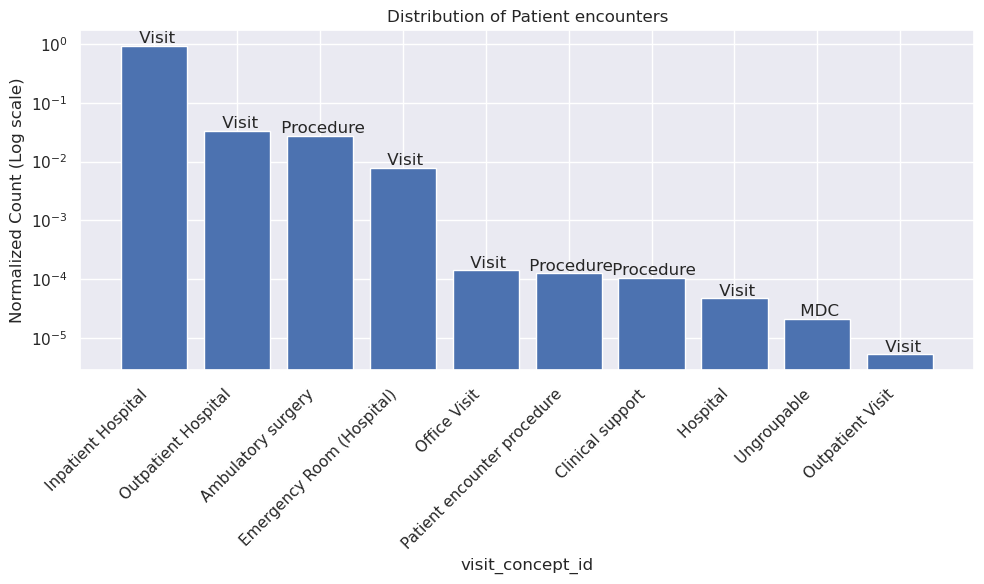

In [575]:
unique_visits = visit_occurrence['visit_concept_id'].unique()
label = {
    8717: 'Inpatient Hospital - Visit',
    8756: 'Outpatient Hospital - Visit',
    4004517: 'Ambulatory surgery - Procedure',
    8870: 'Emergency Room (Hospital) - Visit',
    581477: 'Office Visit - Visit',
    4203722: 'Patient encounter procedure - Procedure',
    44791812: 'Clinical support - Procedure',
    38004515: 'Hospital - Visit',
    0: 'Ungroupable - MDC',
    9202: 'Outpatient Visit - Visit'
}
visit_label = [word.split('-')[0] for word in list(label.values())] 
visit_type = [word.split('-')[1] for word in list(label.values())] 
value_counts = visit_occurrence['visit_concept_id'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
bars = plt.bar(visit_label, value_counts)

# Adding labels and title
plt.xlabel('visit_concept_id')
plt.ylabel('Normalized Count (Log scale)')
plt.title('Distribution of Patient encounters')
plt.yscale('log')

for bar, v_type in zip(bars, visit_type):
    x_pos = bar.get_x() + bar.get_width() / 2 # Adjusted x-coordinate
    y_pos = bar.get_height() / 0.9
    plt.text(x_pos, y_pos, v_type, ha='center')

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [576]:
visit_occurrence.groupby('person_id')['visit_start_datetime'].nunique().describe()

count    286.000000
mean      16.895105
std       67.609219
min        1.000000
25%        3.000000
50%        8.000000
75%       13.000000
max      837.000000
Name: visit_start_datetime, dtype: float64

In [577]:
visit_occurrence.loc[visit_occurrence['person_id'] == 175605, ['visit_start_datetime', 'visit_occurrence_id']].head(15)

visit_start_datetime  visit_occurrence_id
190977  2016-02-03 10:23:00             27807625
190978  2016-02-03 10:23:00             27807625
190979  2016-02-03 10:23:00             27807625
190980  2016-05-12 11:00:00             27800762
190981  2016-11-10 09:04:00             27807626
190982  2016-11-10 09:04:00             27807626
190983  2016-11-10 09:04:00             27807626
190984  2016-11-10 09:04:00             27807626
190985  2016-11-10 09:04:00             27807626
190986  2016-11-10 09:04:00             27807626
190987  2016-11-10 09:04:00             27807626
190988  2016-11-10 09:04:00             27807626
190989  2016-11-10 09:04:00             27807626
190990  2016-11-10 09:04:00             27807626
190991  2016-11-10 09:04:00             27807626

In [578]:
led_df = led_df.sort_values(by=['drug_exposure_start_datetime'], ascending=True)

In [579]:
led_df

person_id drug_exposure_start_datetime  \
30554     175414          2011-05-13 17:00:00   
30542     175414          2011-05-13 18:00:00   
30558     175414          2011-05-13 21:00:00   
30543     175414          2011-05-13 21:00:00   
30544     175414          2011-05-13 22:00:00   
...          ...                          ...   
71531      21186          2021-05-07 13:51:00   
71532      21186          2021-05-07 20:51:00   
71547      21186          2021-05-08 09:00:00   
71533      21186          2021-05-08 13:11:00   
71534      21186          2021-05-08 22:51:00   

                                       drug_source_value  \
30554  {"med_display_name": "rasagiline mesylate (AZI...   
30542  {"med_display_name": "Inv levodopa-carbidopa o...   
30558  {"med_display_name": "ropinirole (REQUIP XL) T...   
30543  {"med_display_name": "Inv levodopa-carbidopa o...   
30544  {"med_display_name": "Inv levodopa-carbidopa o...   
...                                                  ...   
71531  {"med_display_name": "benztropine (COGENTIN) t...   
71532  {"med_display_name": "benztropine (COGENTIN) t...   
71547  {"med_display_name": "benztropine (COGENTIN) t...   
71533  {"med_display_name": "benztropine (COGENTIN) t...   
71534  {"med_display_name": "benztropine (COGENTIN) t...   

                                             drug_info  \
30554        rasagiline mesylate (AZILECT) tablet 1 mg   
30542  Inv levodopa-carbidopa or placebo 100/25mg cap    
30558                 ropinirole (REQUIP XL) TB24 4 mg   
30543  Inv levodopa-carbidopa or placebo 100/25mg cap    
30544  Inv levodopa-carbidopa or placebo 100/25mg cap    
...                                                ...   
71531               benztropine (COGENTIN) tablet 1 mg   
71532               benztropine (COGENTIN) tablet 1 mg   
71547               benztropine (COGENTIN) tablet 1 mg   
71533               benztropine (COGENTIN) tablet 1 mg   
71534               benztropine (COGENTIN) tablet 1 mg   

                            generic_name brand_name dosage  led_dose  \
30554                rasagiline mesylate    azilect   1 mg       1.0   
30542  inv levodopa-carbidopa or placebo        NaN   25mg       NaN   
30558                         ropinirole  requip xl   4 mg       4.0   
30543  inv levodopa-carbidopa or placebo        NaN   25mg       NaN   
30544  inv levodopa-carbidopa or placebo        NaN   25mg       NaN   
...                                  ...        ...    ...       ...   
71531                        benztropine   cogentin   1 mg       1.0   
71532                        benztropine   cogentin   1 mg       1.0   
71547                        benztropine   cogentin   1 mg       1.0   
71533                        benztropine   cogentin   1 mg       1.0   
71534                        benztropine   cogentin   1 mg       1.0   

       dose_source_value dose_unit_source_value route_source_value  \
30554                1.0                     mg               ORAL   
30542                2.0                capsule               ORAL   
30558                4.0                     mg               ORAL   
30543                2.0                capsule               ORAL   
30544                1.0                capsule               ORAL   
...                  ...                    ...                ...   
71531                1.0                     mg         PER G TUBE   
71532                1.0                     mg         PER G TUBE   
71547                0.0                     mg         PER G TUBE   
71533                1.0                     mg         PER G TUBE   
71534                1.0                     mg         PER G TUBE   

       visit_occurrence_id  visit_detail_id  led  
30554             27770310              NaN  0.0  
30542             27770310              NaN  NaN  
30558             27770310              NaN  2.0  
30543             27770310              NaN  NaN  
30544             27770310             

### Finding Home Medications

In [580]:
from collections import Counter

count_comma = 0
count_asterisc = 0
comma_delimiter = False
target_word = 'Home Medications'
# Add pattern to avoid numbers. Maybe also limit words to 1-3 chars
pattern = r'([\w\s-]+)\s(?:\(([\w\s-]+)\)\s*)'
dosage = r'\d+(?:\.\d+)?(?:-\d+(?:\.\d+)?)*(?:\s*(?:mg/ml|mg|ml|%))(?:/hr)?'
home_meds_pattern = r"Home Medications:? ([\w\s\d\(\)]+)"

generic_names= []
brand_names = []
target = []
home_meds_note = []
home_meds_portion = []
medications_appearance = ""
bleh = []
after_home_meds = []
rest_note = []
temp = corpus_clean # list(set(corpus_clean))
count = 0

# Goes over corpus_clean (which contains the notes for each patient) and uses a regex to find "Home Medications(:)"
# After that it restricts the note to Home Medications and everything after that

raro = {}
medications_data = []

for index, row in df_pd.iterrows():
    person_id, note_text = row['person_id'], corpus_clean[index]
    raro[index] = {
        'person_id': person_id,
        'note_text': note_text
    }


for index, item in enumerate(temp): # Make sure to sure the whole array next
    match = re.search(home_meds_pattern, item)
    if  match:
        # Little count to see how many notes contain home meds
        count = count + 1
        # Actual index where the word is inside of the string
        word_index = item.find(target_word) 
        # Truncated_note
        home_meds_note.append(item[word_index:])
        # What it actually matches
        home_meds_portion.append(match.group(0))
        # Array contianing the indexes of the notes that contain home meds
        bleh.append(index)

# Replaces the matched portion of home meds for a "". In other words, deletes the matched portion from the array
result = [note.replace(portion, "") for note, portion in zip(home_meds_note, home_meds_portion)]      
# Splits the notes by whitespaces. Note the list comprehension: words is a list of lists that contains words that have been separated by a whitespace
words = [word.split(' ') for word in result]

# Go through the ists of lists and look for the word "Medication". 
# When found concatenate th 2 words prior to the word, the word and the 2 words before the word  
for i, item in enumerate(words):
    for j, word in enumerate(item):
        if "Medications" in word:
            # Avoid getting the word at the end of the array
            if j-2 == -1:
                medications_appearance = " ".join([words[i][j-1], words[i][j], words[i][j+1], words[i][j+2]])
            else:
                medications_appearance = " ".join([words[i][j-2], words[i][j-1], words[i][j], words[i][j+1], words[i][j+2]])
            
            target.append(medications_appearance)
            # if not medications_appearance.startswith("caused by Medications"):
            #     target.append(medications_appearance)
        
        # Get the current word and two more, if it matches any of the 2 key words, attach them to the target array
        # target is a list that contains potential words that are going to be the stopwords.
        multi_word_phrase = " ".join(item[j:j+3])  # Adjust the slice range as needed
        multi_word_phrase_other = " ".join(item[j:j+2])
        if 'Allergies Allergen Reactions' in multi_word_phrase:
            target.append(multi_word_phrase)
        
        if 'Family History' in multi_word_phrase_other:
            target.append(multi_word_phrase_other)

# Here we count how many times a potential stopword is in the array and we sort them by importance
element_counts = Counter(target)
sorted_target = sorted(target, key=lambda x: (-element_counts[x], x))
target_unique = []
seen = set()

for element in sorted_target:
    if element not in seen:
        target_unique.append(element)
        seen.add(element)

whats = []
ble = []
# We iterate from the truncated note up until potential target and count the number of commas and asteriscs so that it can be the delimiter.
# Whatever is higher (commas or astheriscs) is gonna be used to split the string and get the meds
for item in result:
    for stop_word in target_unique:
        if stop_word in item:
            word_index = item.find(stop_word)
            epa = item[:word_index]
            count_comma = epa.count(',')
            count_asterisc = epa.count('*')
            whats.append(epa)
            break
        comma_delimiter = False    
        if count_comma > count_asterisc:
            comma_delimiter = True
        ble.append(comma_delimiter)

# We use the delimiter to separate the string and then ue another regex to find the generic and brand name of the drug    
for index, item in enumerate(whats):
    delimiter = ',' if ble[index] else '*'
    potential_drugs = item.split(delimiter)
    for indo, string in enumerate(potential_drugs):
        drug_name_match = re.findall(pattern, string)
        if drug_name_match:
            # I have to use temp variables beecause tuples are not mutable in Python
            for match in drug_name_match:
                # Removing the words Authorizing Provider and Historical
                if "Authorizing Provider" in match[0]:
                    temp_match = match[0].replace("Authorizing Provider", "")
                elif "Historical" in match[0]:
                    temp_match = match[0].replace("Historical", "")
                else:
                    temp_match = match[0]
                # Making the drug names lowercase and removing whitespaces
                updated_match = (temp_match.lower().strip(), match[1].lower().strip())
                generic_name, brand_name = updated_match
                generic_names.append(generic_name)
                if brand_name:
                    brand_names.append(brand_name)
                else:
                    brand_names.append(np.nan)

                person_id = raro[bleh[index]]['person_id']
                medications_data.append({
                    'person_id': person_id,
                    'index': bleh[index],
                    'generic_name': generic_name,
                    'brand_name': brand_name
                })        

medications_df = pd.DataFrame(medications_data)

In [581]:
medications_df

person_id  index             generic_name     brand_name
0         261006      0             aripiprazole        abilify
1         261006      0                 baclofen       lioresal
2         261006      0            bupropion hcl  wellbutrin xl
3         261006      0   carboxymethylcellulose        refresh
4         261006      0               clobetasol       temovate
...          ...    ...                      ...            ...
69977     205269  10080  pa-c   insulin glargine         lantus
69978     205269  10080               omeprazole       prilosec
69979     205269  10080       potassium chloride          k-dur
69980     205269  10080               ranolazine         ranexa
69981     205269  10080                terazosin         hytrin

[69982 rows x 4 columns]

In [582]:
# Create a boolean mask by applying str.contains() to each element in pd_medications
mask = medications_df['generic_name'].apply(lambda x: any(med in x for med in pd_medication))
# Use the mask to filter medications_df
filtered_df = medications_df[mask]

In [583]:
filtered_df

person_id  index        generic_name  brand_name
239       261006     14         benztropine    cogentin
240       261006     16          amantadine   symmetrel
242       261006     16  carbidopa-levodopa  sinemet cr
243       261006     16  carbidopa-levodopa     sinemet
255       261006     18         benztropine    cogentin
...          ...    ...                 ...         ...
69826     206133  10025  carbidopa-levodopa     sinemet
69843     206133  10027  carbidopa-levodopa     sinemet
69858     206133  10028  carbidopa-levodopa     sinemet
69873     205269  10032  carbidopa-levodopa     sinemet
69890     205269  10034  carbidopa-levodopa     sinemet

[6858 rows x 4 columns]

In [584]:
# Replacing manually the instances where the drugs still contain an string before the name
filtered_df.loc[:, 'generic_name'] = filtered_df['generic_name'].replace({
    'do carbidopa-levodopa': 'carbidopa-levodopa',
    'pa-c carbidopa-levodopa': 'carbidopa-levodopa',
    'np carbidopa-levodopa': 'carbidopa-levodopa',
    'ap carbidopa-levodopa': 'carbidopa-levodopa',
    '2  carbidopa-levodopa': 'carbidopa-levodopa',
    '2 tabs 3 times daily  carbidopa-levodopa': 'carbidopa-levodopa',
    '1  calcium 500 mg tablet chewable  carbidopa-levodopa': 'carbidopa-levodopa',
    'gastroparesis  carbidopa-levodopa': 'carbidopa-levodopa',
    'yes  information carbidopa-levodopa': 'carbidopa-levodopa',
    'pa-c benztropine': 'benztropine',
    'ap ropinirole': 'ropinirole',
    'do ropinirole': 'ropinirole',
    'pa-c ropinirole': 'ropinirole',
    's disease with unknown cause  ropinirole': 'ropinirole',
    'ureteral stone  ropinirole': 'ropinirole',
    'soda coffee or tea daily for bowel movement and then once a week as needed  selegiline': 'selegiline',
    '-levodopa': 'levodopa',
    'ap entacapone': 'entacapone',
    'pa-c selegiline': 'selegiline'
      })


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [585]:
filtered_df

person_id  index        generic_name  brand_name
239       261006     14         benztropine    cogentin
240       261006     16          amantadine   symmetrel
242       261006     16  carbidopa-levodopa  sinemet cr
243       261006     16  carbidopa-levodopa     sinemet
255       261006     18         benztropine    cogentin
...          ...    ...                 ...         ...
69826     206133  10025  carbidopa-levodopa     sinemet
69843     206133  10027  carbidopa-levodopa     sinemet
69858     206133  10028  carbidopa-levodopa     sinemet
69873     205269  10032  carbidopa-levodopa     sinemet
69890     205269  10034  carbidopa-levodopa     sinemet

[6858 rows x 4 columns]

In [586]:
# result_df contains the home medications for each patient
result_df = filtered_df.groupby('person_id').agg({
    'generic_name': lambda x: ', '.join(sorted(x.unique())),
    'brand_name': lambda x: ', '.join(sorted(x.unique())),
    'index': lambda x: ', '.join(map(str, x.unique()))
}).reset_index()
result_df = result_df.sort_values(by='person_id', ascending=False)

In [587]:
result_df

person_id                                       generic_name  \
178     261006        amantadine, benztropine, carbidopa-levodopa   
177     260996  amantadine, benztropine, carbidopa-levodopa, n...   
176     260953  carbidopa-levodopa, np   carbidopa-levodopa, p...   
175     260918  carbidopa-levodopa, np   carbidopa-levodopa, p...   
174     260872  carbidopa-levodopa, np   carbidopa-levodopa, p...   
..         ...                                                ...   
4       207746      carbidopa-levodopa, pa-c   carbidopa-levodopa   
3       206828  ap   carbidopa-levodopa, carbidopa-levodopa, d...   
2       206303                                 carbidopa-levodopa   
1       206133                                 carbidopa-levodopa   
0       205269                                 carbidopa-levodopa   

                                           brand_name  \
178          cogentin, sinemet, sinemet cr, symmetrel   
177  cogentin, requip, sinemet, sinemet cr, symmetrel   
176                       requip, sinemet, sinemet cr   
175                       requip, sinemet, sinemet cr   
174                       requip, sinemet, sinemet cr   
..                                                ...   
4                                 sinemet, sinemet cr   
3           comtan, mirapex, neupro, parcopa, sinemet   
2                                             sinemet   
1                                             sinemet   
0                                             sinemet   

                                                 index  
178             14, 16, 18, 19, 20, 21, 22, 23, 25, 26  
177  29, 30, 31, 32, 34, 35, 36, 41, 42, 44, 46, 47...  
176                       176, 177, 178, 180, 182, 183  
175                  185, 186, 187, 188, 189, 191, 192  
174                            194, 195, 200, 203, 204  
..                                                 ...  
4    9800, 9801, 9802, 9804, 9805, 9806, 9807, 9808...  
3    9857, 9862, 9864, 9866, 9869, 9872, 9873, 9876...  
2    9998, 9999, 10001, 10004, 10005, 10006, 10007,...  
1    10012, 10013, 10016, 10019, 10020, 10022, 1002...  
0                                         10032, 10034  

[179 rows x 4 columns]

In [588]:
led_df['brand_name'].replace({np.nan: 'None'}, inplace=True)

In [589]:
led_df['brand_name'].unique()

array(['azilect', 'None', 'requip xl', 'sinemet', 'sinemet cr', 'comtan',
       'artane', 'mirapex', 'symmetrel', 'requip', 'stalevo', 'duopa',
       'lodosyn', 'eldepryl', 'cogentin', 'parcopa', 'carbidopa-levodopa',
       'neupro', 'dostinex', 'apokyn', 'tasmar', 'rytary', 'azalect',
       'parlodel', 'gocovri', ' rytary ', 'ipx203-b16-03'], dtype=object)

In [590]:
# resultado contains the generic_name and brand_name for inpatient drugs
resultado = led_df.groupby('person_id').agg({
    'generic_name': lambda x: ', '.join(sorted(x.unique())),
    'brand_name': lambda x: ', '.join(sorted(x.unique())),
}).reset_index()
resultado = resultado.sort_values(by='person_id', ascending=False)
resultado_df = resultado[resultado['person_id'].isin(filtered_df['person_id'].unique())]
resultado_df

person_id                                       generic_name  \
1423     261006                                 carbidopa-levodopa   
1422     260996        amantadine, benztropine, carbidopa-levodopa   
1420     260953  amantadine, carbidopa-levodopa, entacapone, ra...   
1418     260918                                 carbidopa-levodopa   
1417     260872                    carbidopa-levodopa, pramipexole   
...         ...                                                ...   
1070     207746                                 carbidopa-levodopa   
1069     206828                                        benztropine   
1068     206303         carbidopa-levodopa, ropinirole, selegiline   
1067     206133                                 carbidopa-levodopa   
1066     205269                      carbidopa, carbidopa-levodopa   

                                           brand_name  
1423                                          sinemet  
1422         cogentin, sinemet, sinemet cr, symmetrel  
1420  azilect, comtan, sinemet, sinemet cr, symmetrel  
1418                                          sinemet  
1417                                 mirapex, sinemet  
...                                               ...  
1070                                          sinemet  
1069                                         cogentin  
1068            eldepryl, requip, sinemet, sinemet cr  
1067                                          sinemet  
1066                                 lodosyn, sinemet  

[179 rows x 3 columns]

In [591]:
comparison_generic_name = pd.merge(result_df[['person_id', 'generic_name']], resultado_df[['person_id', 'generic_name']], on='person_id', how='outer', suffixes=('_filtered', '_led'))
comparison_brand_name = pd.merge(result_df[['person_id', 'brand_name']], resultado_df[['person_id', 'brand_name']], on='person_id', how='outer', suffixes=('_filtered', '_led'))
# comparison_generic_name.to_csv('comparison_generic_name.csv', index=False)
# comparison_brand_name.to_csv('comparison_brand_name.csv', index=False)

In [592]:
comparison_generic_name

person_id                              generic_name_filtered  \
0       261006        amantadine, benztropine, carbidopa-levodopa   
1       260996  amantadine, benztropine, carbidopa-levodopa, n...   
2       260953  carbidopa-levodopa, np   carbidopa-levodopa, p...   
3       260918  carbidopa-levodopa, np   carbidopa-levodopa, p...   
4       260872  carbidopa-levodopa, np   carbidopa-levodopa, p...   
..         ...                                                ...   
174     207746      carbidopa-levodopa, pa-c   carbidopa-levodopa   
175     206828  ap   carbidopa-levodopa, carbidopa-levodopa, d...   
176     206303                                 carbidopa-levodopa   
177     206133                                 carbidopa-levodopa   
178     205269                                 carbidopa-levodopa   

                                      generic_name_led  
0                                   carbidopa-levodopa  
1          amantadine, benztropine, carbidopa-levodopa  
2    amantadine, carbidopa-levodopa, entacapone, ra...  
3                                   carbidopa-levodopa  
4                      carbidopa-levodopa, pramipexole  
..                                                 ...  
174                                 carbidopa-levodopa  
175                                        benztropine  
176         carbidopa-levodopa, ropinirole, selegiline  
177                                 carbidopa-levodopa  
178                      carbidopa, carbidopa-levodopa  

[179 rows x 3 columns]

In [593]:
comparison_brand_name

person_id                               brand_name_filtered  \
0       261006          cogentin, sinemet, sinemet cr, symmetrel   
1       260996  cogentin, requip, sinemet, sinemet cr, symmetrel   
2       260953                       requip, sinemet, sinemet cr   
3       260918                       requip, sinemet, sinemet cr   
4       260872                       requip, sinemet, sinemet cr   
..         ...                                               ...   
174     207746                               sinemet, sinemet cr   
175     206828         comtan, mirapex, neupro, parcopa, sinemet   
176     206303                                           sinemet   
177     206133                                           sinemet   
178     205269                                           sinemet   

                                      brand_name_led  
0                                            sinemet  
1           cogentin, sinemet, sinemet cr, symmetrel  
2    azilect, comtan, sinemet, sinemet cr, symmetrel  
3                                            sinemet  
4                                   mirapex, sinemet  
..                                               ...  
174                                          sinemet  
175                                         cogentin  
176            eldepryl, requip, sinemet, sinemet cr  
177                                          sinemet  
178                                 lodosyn, sinemet  

[179 rows x 3 columns]

In [594]:
# Split the medication lists into sets for comparison
comparison_generic_name['filtered_set'] = comparison_generic_name['generic_name_filtered'].apply(lambda x: set(x.split(', ')))
comparison_generic_name['led_set'] = comparison_generic_name['generic_name_led'].apply(lambda x: set(x.split(', ')))
comparison_generic_name['union'] = comparison_generic_name.apply(lambda row: row['filtered_set'].union(row['led_set']), axis=1)
comparison_generic_name['intersection'] = comparison_generic_name.apply(lambda row: row['filtered_set'].intersection(row['led_set']), axis=1)
comparison_generic_name['match'] = comparison_generic_name.apply(lambda row: round(len(row['intersection']) / len(row['union']) * 100, 0), axis=1)
comparison_generic_name['difference'] = comparison_generic_name.apply(lambda row: row['union'].difference(row['intersection']), axis=1)

In [595]:
comparison_generic_name['match'].describe()

count    179.000000
mean      43.631285
std       34.739453
min        0.000000
25%       17.000000
50%       33.000000
75%       50.000000
max      100.000000
Name: match, dtype: float64

In [596]:
comparison_generic_name['match'].value_counts(normalize=True)

100.0    0.229050
50.0     0.206704
0.0      0.145251
33.0     0.145251
25.0     0.094972
20.0     0.044693
17.0     0.044693
12.0     0.027933
14.0     0.016760
6.0      0.005587
67.0     0.005587
9.0      0.005587
11.0     0.005587
40.0     0.005587
29.0     0.005587
10.0     0.005587
7.0      0.005587
Name: match, dtype: float64

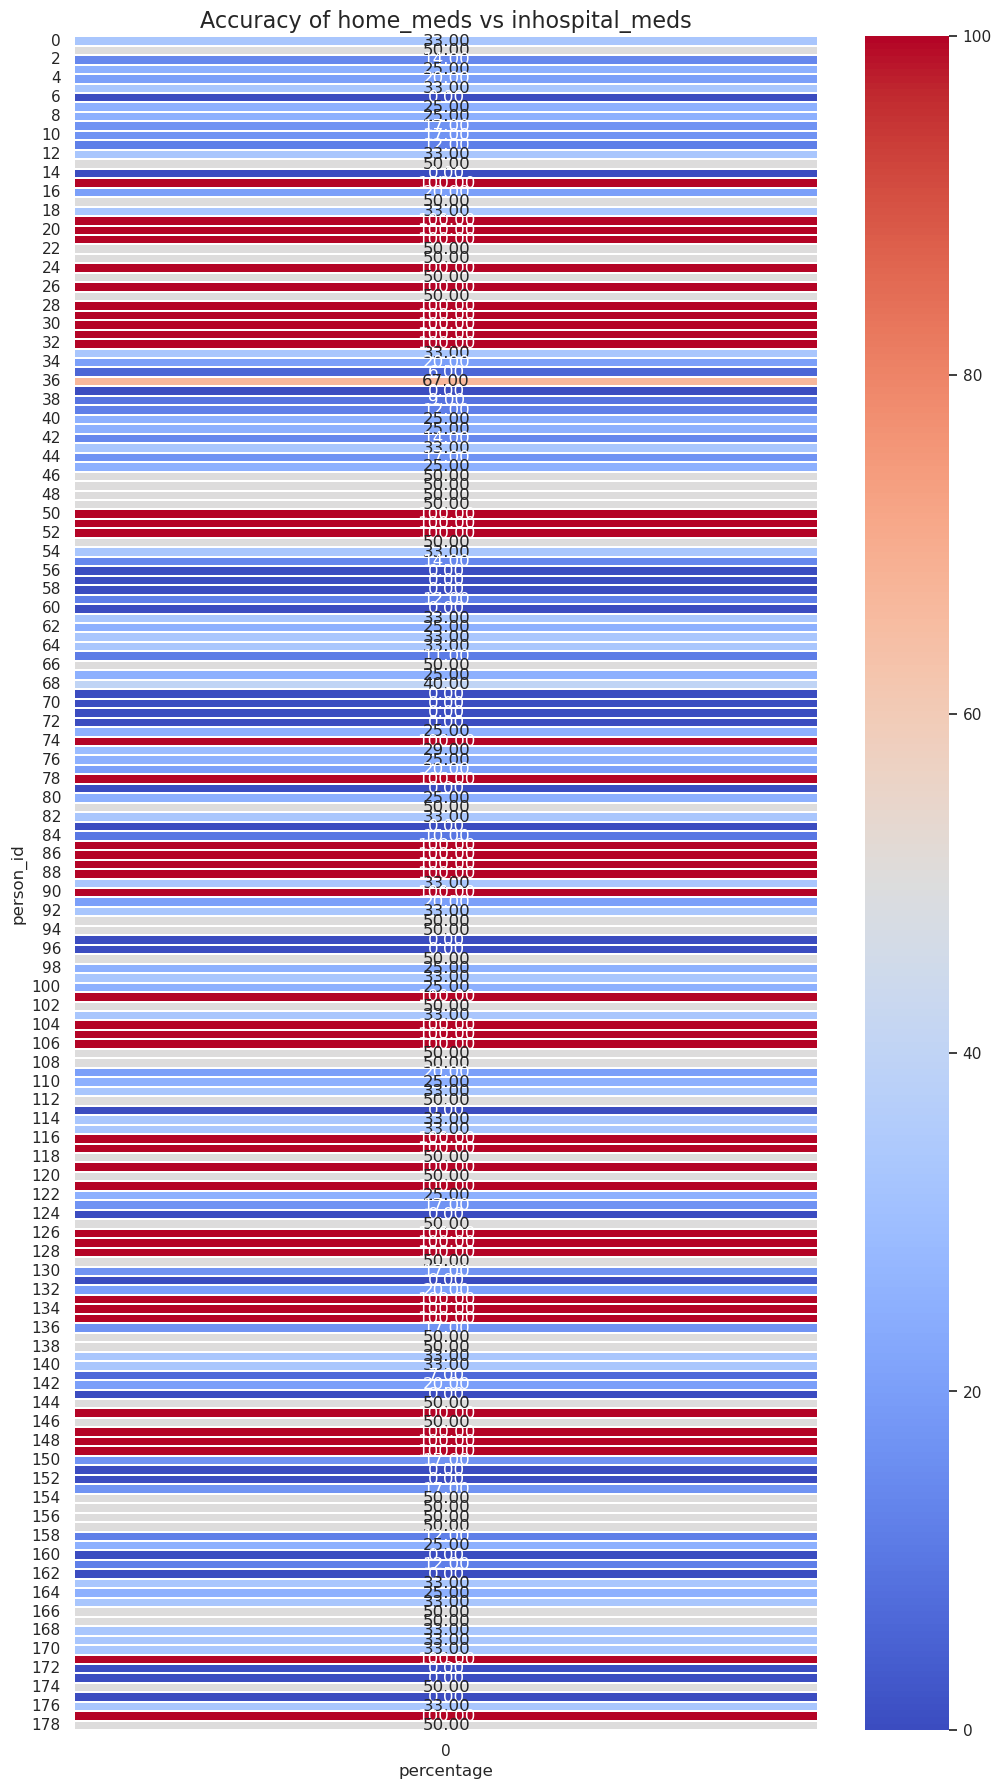

In [597]:
# Transform the matching percentages into a NumPy array
heatmap_data = comparison_generic_name['match'].values.reshape(-1, 1)

# Set the figure size
plt.figure(figsize=(12, 22))

# Create a heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.2)

# Customize the plot
plt.title('Accuracy of home_meds vs inhospital_meds', fontsize=16)
plt.xlabel('percentage', fontsize=12)
plt.ylabel('person_id', fontsize=12)

# Show the plot
plt.show()

In [598]:
comparison_generic_name.describe()

person_id       match
count     179.000000  179.000000
mean   238744.720670   43.631285
std     17606.106388   34.739453
min    205269.000000    0.000000
25%    221553.000000   17.000000
50%    241867.000000   33.000000
75%    255186.500000   50.000000
max    261006.000000  100.000000

Allergies Allergen Reactions, Physical Exam, Family History, Allergies Allergen Reactions

In [599]:
# corpus_clean

In [600]:
# set(corpus_clean)

In [601]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

In [602]:
# This person probably had restless leg syndrome or Parkinsonism
led_df.loc[led_df['person_id'] == 258899, ['drug_exposure_start_datetime', 'generic_name']]

drug_exposure_start_datetime        generic_name
1840          2011-12-05 06:25:00         pramipexole
1841          2012-02-06 22:15:00         pramipexole
1842          2012-02-09 11:00:00         pramipexole
1843          2012-02-09 14:46:00         pramipexole
1844          2012-02-09 20:58:00         pramipexole
...                           ...                 ...
1916          2014-02-07 05:52:00         pramipexole
1836          2017-01-07 13:26:00  carbidopa-levodopa
1837          2017-01-07 17:17:00  carbidopa-levodopa
1838          2017-01-07 23:41:00  carbidopa-levodopa
1839          2017-01-08 08:00:00  carbidopa-levodopa

[81 rows x 2 columns]

In [603]:
led_df.groupby('person_id')['visit_occurrence_id'].nunique().sort_values(ascending=False)

person_id
52721     25
249161    25
256936    24
84870     23
76382     22
          ..
117306     1
117326     1
117372     1
117791     1
261006     1
Name: visit_occurrence_id, Length: 1424, dtype: int64

In [604]:
visit_occurrence[visit_occurrence['person_id'] == 261006]['visit_occurrence_id'].unique()

array([40382465, 40422617, 40422624, 40384038, 40422625, 40422626,
       40422627, 40382459, 40422628, 40382460, 40382461, 40422629,
       40384085, 40382213, 40382462, 40382466, 40422630, 40422631,
       40422618, 40382464, 40422620, 40382312, 40382316, 40382320,
       40382325, 40422621, 40422622, 40382467, 40422623])

In [605]:
visit_occurrence

person_id drug_exposure_start_datetime  visit_occurrence_id  \
0          261006          2011-09-06 17:50:00             40382465   
1          261006          2011-09-06 18:10:00             40382465   
2          261006          2011-09-06 19:21:00             40382465   
3          261006          2011-09-06 21:33:00             40382465   
4          261006          2011-09-06 21:45:00             40382465   
...           ...                          ...                  ...   
191689     175605          2017-09-26 23:04:00             27807633   
191690     175605          2017-09-27 05:49:00             27807633   
191691     175605          2017-09-27 10:14:00             27807633   
191692     175605          2017-09-27 10:15:00             27807633   
191693     175605          2017-09-27 13:45:00             27807633   

        visit_concept_id visit_start_datetime  
0                   8717  2011-09-06 10:48:00  
1                   8717  2011-09-06 10:48:00  
2                   8717  2011-09-06 10:48:00  
3                   8717  2011-09-06 10:48:00  
4                   8717  2011-09-06 10:48:00  
...                  ...                  ...  
191689              8717  2017-09-18 15:31:00  
191690              8717  2017-09-18 15:31:00  
191691              8717  2017-09-18 15:31:00  
191692              8717  2017-09-18 15:31:00  
191693              8717  2017-09-18 15:31:00  

[191694 rows x 5 columns]

In [606]:
# So this is critical step in the model. When I drop the duplicates the accuracy drops. But I feel like it's a neccesary step
# The reason why it's dropped is because we are only interested in the visits. led_df already has accurate info on the drugs
visit_occurrence_modified = visit_occurrence.drop(columns=['drug_exposure_start_datetime'])
visit_occurrence_modified.drop_duplicates(inplace=True)

In [607]:
led_df = led_df.merge(visit_occurrence_modified, on=['person_id', 'visit_occurrence_id'], how='inner')

In [608]:
led_df["visit_start_datetime"] = pd.to_datetime(led_df["visit_start_datetime"], format='%Y-%m-%d')
led_df["drug_exposure_start_datetime"] = pd.to_datetime(led_df["drug_exposure_start_datetime"], format='%Y-%m-%d')

In [609]:
years = 5
days_to_years = years * 365
time_window = str(days_to_years) + 'D'
# It looks like rolling only allows to use the most basic unit of each time variable (days, seconds)
mean_led_per_visit = led_df.set_index('visit_start_datetime').groupby('person_id')['led'].rolling(time_window).mean().reset_index() # Using the time window
# mean_led_per_visit = led_df.set_index('visit_start_datetime').groupby('person_id')['led'].mean().reset_index() # Without time window
mean_led_per_visit = mean_led_per_visit.rename(columns={'led':'mean_led_per_visit'})
patient_stay['mean_led_per_visit'] = mean_led_per_visit['mean_led_per_visit']

array_temp = mean_led_per_visit['mean_led_per_visit'].to_list()
prediction = [0] * len(array_temp)  # Initialize with 0 for all elements
prediction[1:] = [1 if array_temp[i+1] > array_temp[i] else 0 for i in range(len(array_temp)-1)]
# prediction = [1 if array_temp[i + 1] > array_temp[i] else (2 if array_temp[i + 1] == array_temp[i] else 0) for i in range(len(array_temp) - 1)]
mean_led_per_visit['prediction'] = prediction

In [610]:
mean_led_per_visit['prediction'].value_counts(normalize=True)

0    0.615787
1    0.384213
Name: prediction, dtype: float64

In [611]:
mean_led_per_visit[mean_led_per_visit['mean_led_per_visit'].isna() == True]

person_id visit_start_datetime  mean_led_per_visit  prediction
225       176706  2021-04-28 12:06:00                 NaN           0
391       179263  2019-04-03 18:18:00                 NaN           0
392       179263  2019-04-03 18:18:00                 NaN           0
393       179263  2019-04-03 18:18:00                 NaN           0
1661      185090  2020-09-30 12:10:00                 NaN           0
1749      185491  2019-10-08 18:28:00                 NaN           0
2981      189637  2021-03-09 00:15:00                 NaN           0
2982      189637  2021-03-09 00:15:00                 NaN           0
4965      201288  2019-10-10 19:54:00                 NaN           0
7457      203744  2020-09-17 07:23:00                 NaN           0
7464      203750  2020-08-26 06:37:00                 NaN           0
7465      203750  2020-08-26 06:37:00                 NaN           0
8843      207746  2017-12-11 18:51:00                 NaN           0
9016      210100  2018-01-19 06:13:00                 NaN           0
10911     215768  2020-01-31 22:13:00                 NaN           0
11300     215778  2019-01-13 13:03:00                 NaN           0
11301     215778  2019-01-13 13:03:00                 NaN           0
14943     218618  2017-09-11 22:44:00                 NaN           0
15912     220761  2017-09-06 11:41:00                 NaN           0
15913     220761  2017-09-06 11:41:00                 NaN           0
15943     221162  2017-11-08 10:54:00                 NaN           0
15944     221295  2018-01-18 12:59:00                 NaN           0
16786     223037  2018-07-05 06:04:00                 NaN           0
16787     223037  2018-07-05 06:04:00                 NaN           0
16788     223037  2018-07-05 06:04:00                 NaN           0
16789     223037  2018-09-12 00:19:00                 NaN           0
16821     223756  2017-07-31 13:42:00                 NaN           0
16822     223756  2017-07-31 13:42:00                 NaN           0
17038     227415  2019-12-05 23:58:00                 NaN           0
17039     227415  2019-12-05 23:58:00                 NaN           0
17834     235403  2020-02-07 10:20:00                 NaN           0
17893     236915  2018-02-10 00:55:00                 NaN           0
18382     241733  2012-11-09 15:39:00                 NaN           0
18796     245457  2013-03-14 23:36:00                 NaN           0
19650     247690  2014-12-27 08:49:00                 NaN           0
20952     250804  2019-12-30 21:16:00                 NaN           0
22221     253679  2013-12-08 07:36:00                 NaN           0
22387     254301  2020-11-30 08:44:00                 NaN           0
25673     260382  2020-07-04 16:31:00                 NaN           0
25674     260382  2020-07-04 16:31:00                 NaN           0
25675     260382  2020-07-04 16:31:00                 NaN           0
25676     260382  2020-07-04 16:31:00                 NaN           0
25677     260382  2020-07-04 16:31:00                 NaN           0
25678     260382  2020-07-04 16:31:00                 NaN           0
25679     260382  2020-07-04 16:31:00                 NaN           0
25680     260382  2020-07-04 16:31:00                 NaN           0

In [612]:
mean_led_per_visit = mean_led_per_visit.merge(demographics, on='person_id', how='right')

Length of stay relative to overall visits and not only drug administration

In [613]:
length_of_stay = visit_occurrence.groupby('person_id')['visit_start_datetime'].agg(['min', 'max']).reset_index()
length_of_stay['length_of_stay'] = ((length_of_stay['max'] - length_of_stay['min']) / np.timedelta64(1, 'D')).astype(int)
length_of_stay['days_since_last_visit'] = ((pd.to_datetime('today') - length_of_stay['max']) / np.timedelta64(1, 'D')).astype(int)
length_of_stay.drop(columns=['min', 'max'], inplace=True)

In [614]:
mean_led_per_visit = mean_led_per_visit.merge(length_of_stay, on='person_id', how='right')

In [615]:
# aggregations = {'generic_name': lambda x: ', '.join(x), 'dosage': lambda x: ', '.join(x)}
aggregations = {'generic_name': lambda x: ', '.join(x)}
# CPT CODES FOR DBS, TF/IDF FOR TEXT, CLINICALBIOBET FOR NOTES, RNN LSTM FOR NOTES FOT TEMPORL INPUVT, PROCESSES THE EVENT AT A TIME AND OUTPUTS PREDICTION
# CONTEX WINDOWS FOR CLINICAL BIOBERT. HIERARCHY PASS EMBEDS INTO OTHER BERT.
# TRANSFORMERXL, LONGFORMER, TPIC MODELING
# CLUSTER ON EVERYTHING LOOK FOR DISTINCT THINGS
# PICK AVG IF EACH FEATURES ACCROSS MODELS}
# result = led_df.set_index('visit_start_datetime').groupby('person_id').rolling(time_window).agg(aggregations).reset_index() # Using time window
result = led_df.set_index('visit_start_datetime').groupby('person_id').agg(aggregations).reset_index() # Without time window

In [616]:
result

person_id                                       generic_name
0       175605  carbidopa-levodopa, carbidopa-levodopa, carbid...
1       175744  carbidopa-levodopa, carbidopa-levodopa, carbid...
2       176417  carbidopa-levodopa, carbidopa-levodopa, carbid...
3       176462                           pramipexole, pramipexole
4       176706  carbidopa-levodopa, carbidopa-levodopa, carbid...
..         ...                                                ...
281     260872  carbidopa-levodopa, carbidopa-levodopa, carbid...
282     260918  carbidopa-levodopa, carbidopa-levodopa, carbid...
283     260956  carbidopa-levodopa, carbidopa-levodopa, carbid...
284     260996  amantadine, carbidopa-levodopa, amantadine, ca...
285     261006  carbidopa-levodopa, carbidopa-levodopa, carbid...

[286 rows x 2 columns]

In [617]:
mean_led_per_visit.drop_duplicates()

person_id visit_start_datetime  mean_led_per_visit  prediction  age  \
0         175605  2017-05-28 11:45:00          100.000000         0.0   89   
7         175605  2017-05-28 11:45:00           93.750000         0.0   89   
8         175605  2017-05-28 11:45:00           88.888889         0.0   89   
9         175605  2017-05-28 11:45:00           85.000000         0.0   89   
10        175605  2017-05-28 11:45:00           81.818182         0.0   89   
...          ...                  ...                 ...         ...  ...   
26936     260996  2013-05-09 20:23:00           95.326404         1.0   77   
26937     260996  2013-05-09 20:23:00           95.331650         1.0   77   
26938     260996  2013-05-09 20:23:00           95.336883         1.0   77   
26939     261006  2021-04-09 20:05:00          200.000000         1.0   74   
26940     261006  2021-04-09 20:05:00          200.000000         0.0   74   

      gender_source_value race_source_value ethnicity_source_value  \
0                    MALE             OTHER               HISPANIC   
7                    MALE             OTHER               HISPANIC   
8                    MALE             OTHER               HISPANIC   
9                    MALE             OTHER               HISPANIC   
10                   MALE             OTHER               HISPANIC   
...                   ...               ...                    ...   
26936              FEMALE             WHITE           NOT HISPANIC   
26937              FEMALE             WHITE           NOT HISPANIC   
26938              FEMALE             WHITE           NOT HISPANIC   
26939                MALE             WHITE           NOT HISPANIC   
26940                MALE             WHITE           NOT HISPANIC   

       length_of_stay  days_since_last_visit  
0                 593                   2307  
7                 593                   2307  
8                 593                   2307  
9                 593                   2307  
10                593                   2307  
...               ...                    ...  
26936            2146                   1964  
26937            2146                   1964  
26938            2146                   1964  
26939            3503                   1008  
26940            3503                   1008  

[19764 rows x 10 columns]

In [618]:
# Shit happens
result.iloc[132]

person_id                                                  221386
generic_name    carbidopa-levodopa, carbidopa-levodopa, carbid...
Name: 132, dtype: object

In [619]:
drug_exposure

person_id drug_exposure_start_datetime  \
0         261006          2021-04-11 10:53:00   
1         261006          2021-04-11 14:58:00   
2         261006          2021-04-11 17:32:00   
3         261006          2021-04-11 21:31:00   
4         261006          2021-04-12 02:52:00   
...          ...                          ...   
79361        136          2020-01-09 20:32:00   
79362        136          2020-01-10 09:25:00   
79363        136          2020-01-10 16:10:00   
79364        136          2020-01-10 20:03:00   
79365        136          2020-01-11 08:34:00   

                                       drug_source_value  dose_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
1      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
2      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
3      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
4      {"med_display_name": "carbidopa-levodopa (SINE...                2.0   
...                                                  ...                ...   
79361  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79362  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79363  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79364  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   
79365  {"med_display_name": "carbidopa-levodopa (SINE...                1.0   

      dose_unit_source_value route_source_value  visit_occurrence_id  \
0                     tablet               ORAL             40422623   
1                     tablet               ORAL             40422623   
2                     tablet               ORAL             40422623   
3                     tablet               ORAL             40422623   
4                     tablet               ORAL             40422623   
...                      ...                ...                  ...   
79361                 tablet               ORAL               104832   
79362                 tablet               ORAL               104832   
79363                 tablet               ORAL               104832   
79364                 tablet               ORAL               104832   
79365                 tablet               ORAL               104832   

       visit_detail_id  
0            9880783.0  
1            9880783.0  
2            9880783.0  
3            9880783.0  
4            9880783.0  
...                ...  
79361          12629.0  
79362          12629.0  
79363          12629.0  
79364          12629.0  
79365          12629.0  

[79366 rows x 8 columns]

In [620]:
result.iloc[0, :]

person_id                                                  175605
generic_name    carbidopa-levodopa, carbidopa-levodopa, carbid...
Name: 0, dtype: object

Here's where we ONLY use the generic_name instead of generic_name + dosage

In [621]:
# Taking the unique elements from the result array. What we are doing is that we are taking the unique drugs for each patient
epa = []
unique_elements = []

for i in range(len(result)):
    generic_names = result['generic_name'][i].split(', ')
    # dosages = result['dosage'][i].split(', ')
    
    visit_drugs = set()
    
    # ONLY TAKING USING GENERIC_NAME AND NOT DOSAGES
    for generic_name in generic_names:
        visit_drugs.add(f"{generic_name}")
    
    # This is how it was before
    # for generic_name, dosage in zip(generic_names, dosages):
    #     visit_drugs.add(f"{generic_name} {dosage}")

    unique_elements.append(visit_drugs)

patient_drugs_list = [', '.join(visit_drugs) for visit_drugs in unique_elements]
patient_drugs = pd.DataFrame(patient_drugs_list, columns=['drugs_per_visit'])
patient_drugs['person_id'] = result['person_id']
# mean_led_per_visit['drugs_per_visit'] = [', '.join(visit_drugs) for visit_drugs in unique_elements]

In [622]:
patient_drugs

drugs_per_visit  person_id
0                             carbidopa-levodopa     175605
1                             carbidopa-levodopa     175744
2                             carbidopa-levodopa     176417
3                                    pramipexole     176462
4                             carbidopa-levodopa     176706
..                                           ...        ...
281              carbidopa-levodopa, pramipexole     260872
282                           carbidopa-levodopa     260918
283                           carbidopa-levodopa     260956
284  amantadine, carbidopa-levodopa, benztropine     260996
285                           carbidopa-levodopa     261006

[286 rows x 2 columns]

In [623]:
# I didn't use this

# drugs_list = patient_drugs['drugs_per_visit'].str.split(', ')

# # Create a DataFrame with one-hot encoding
# one_hot_encoded = pd.get_dummies(drugs_list.apply(pd.Series).stack()).sum(level=0)

# # Concatenate the one-hot encoded DataFrame with the original DataFrame
# patient_drugs_encoded = pd.concat([patient_drugs, one_hot_encoded], axis=1)

# # Drop the original 'drugs_per_visit' column as it's no longer needed
# patient_drugs_encoded = patient_drugs_encoded.drop('drugs_per_visit', axis=1)

In [624]:
# Putting the inpatient drugs into the dataset
# mean_led_per_visit = mean_led_per_visit.merge(patient_drugs, on='person_id', how='right')

In [625]:
# Filling nan values with None
# mean_led_per_visit['drugs_per_visit'].fillna('None', inplace=True)

In [626]:
# Assesing if they were diagnosed and have poa in the current visit
# Note: These two variables do nothing for the model
mean_led_per_visit['diagnosed_current_visit'] = mean_led_per_visit.apply(lambda row: 1 if row['person_id'] in diagnosis_date[diagnosis_date['diagnosis_date'] == row['visit_start_datetime']]['person_id'].values else 0, axis=1)
mean_led_per_visit['poa_current_visit'] = mean_led_per_visit.apply(lambda row: 1 if row['person_id'] in diagnosis_date[(diagnosis_date['condition_poa'] == True) & (diagnosis_date['diagnosis_date'] == row['visit_start_datetime'])]['person_id'].values else 0, axis=1)

In [627]:
# Calculating days to diagnosis
# Note: This variable also does nothing for the model
first_visit_per_patient = visit_occurrence.groupby('person_id')['visit_start_datetime'].agg('min').reset_index()
first_visit_diagnosis_date = diagnosis_date.groupby('person_id')['diagnosis_date'].agg('min').reset_index()
days_to_diagnosis = pd.DataFrame()
days_to_diagnosis['person_id'] = first_visit_per_patient['person_id']
days_to_diagnosis['days_to_diagnosis'] = ((first_visit_diagnosis_date['diagnosis_date'] - first_visit_per_patient['visit_start_datetime']) / np.timedelta64(1, 'D')).astype(int)

In [628]:
df_pd['person_id'].nunique()

631

In [629]:
mean_led_per_visit

person_id visit_start_datetime  mean_led_per_visit  prediction  age  \
0         175605  2017-05-28 11:45:00               100.0         0.0   89   
1         175605  2017-05-28 11:45:00               100.0         0.0   89   
2         175605  2017-05-28 11:45:00               100.0         0.0   89   
3         175605  2017-05-28 11:45:00               100.0         0.0   89   
4         175605  2017-05-28 11:45:00               100.0         0.0   89   
...          ...                  ...                 ...         ...  ...   
26941     261006  2021-04-09 20:05:00               200.0         0.0   74   
26942     261006  2021-04-09 20:05:00               200.0         0.0   74   
26943     261006  2021-04-09 20:05:00               200.0         0.0   74   
26944     261006  2021-04-09 20:05:00               200.0         0.0   74   
26945     261006  2021-04-09 20:05:00               200.0         0.0   74   

      gender_source_value race_source_value ethnicity_source_value  \
0                    MALE             OTHER               HISPANIC   
1                    MALE             OTHER               HISPANIC   
2                    MALE             OTHER               HISPANIC   
3                    MALE             OTHER               HISPANIC   
4                    MALE             OTHER               HISPANIC   
...                   ...               ...                    ...   
26941                MALE             WHITE           NOT HISPANIC   
26942                MALE             WHITE           NOT HISPANIC   
26943                MALE             WHITE           NOT HISPANIC   
26944                MALE             WHITE           NOT HISPANIC   
26945                MALE             WHITE           NOT HISPANIC   

       length_of_stay  days_since_last_visit  diagnosed_current_visit  \
0                 593                   2307                        0   
1                 593                   2307                        0   
2                 593                   2307                        0   
3                 593                   2307                        0   
4                 593                   2307                        0   
...               ...                    ...                      ...   
26941            3503                   1008                        0   
26942            3503                   1008                        0   
26943            3503                   1008                        0   
26944            3503                   1008                        0   
26945            3503                   1008                        0   

       poa_current_visit  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
...                  ...  
26941                  0  
26942                  0  
26943                  0  
26944                  0  
26945                  0  

[26946 rows x 12 columns]

In [630]:
# Including temporal data into the dataset
mean_led_per_visit = mean_led_per_visit.merge(days_to_diagnosis, on='person_id', how='right')

In [631]:
# Note: When I avoid dropping nas accuracy bumps to 91%
# mean_led_per_visit = mean_led_per_visit.dropna()

In [632]:
# The column 'drugs_per_visit' is the one in patient_drugs. What we do here is create a one hot enconding if inpatient drugs
# drugs_list = mean_led_per_visit['drugs_per_visit'].str.split(', ')
# one_hot_encoding_drugs = pd.get_dummies(drugs_list.apply(pd.Series).stack()).sum(level=0)
# Adding the one hot encoding to the dataset and then deleting the original column
# mean_led_per_visit = pd.concat([mean_led_per_visit, one_hot_encoding_drugs], axis=1)
# mean_led_per_visit.drop(columns=['drugs_per_visit'], inplace=True)

In [633]:
patient_drugs

drugs_per_visit  person_id
0                             carbidopa-levodopa     175605
1                             carbidopa-levodopa     175744
2                             carbidopa-levodopa     176417
3                                    pramipexole     176462
4                             carbidopa-levodopa     176706
..                                           ...        ...
281              carbidopa-levodopa, pramipexole     260872
282                           carbidopa-levodopa     260918
283                           carbidopa-levodopa     260956
284  amantadine, carbidopa-levodopa, benztropine     260996
285                           carbidopa-levodopa     261006

[286 rows x 2 columns]

In [634]:
led_df['dose_unit_source_value'].replace({'Tablet': 'tablet', 'tablet': 'tablet'}, inplace=True)
# apomorphine? something with thius

Adding the home_meds information

In [635]:
result_df.drop(columns=['index', 'brand_name'], inplace=True)
result_df = result_df.rename(columns={'generic_name': 'home_meds_generic_name'})
home_meds_patients = result_df['person_id'].unique().tolist()
mean_led_per_visit['home_meds'] = mean_led_per_visit['person_id'].isin(home_meds_patients)
mean_led_per_visit['home_meds'].replace({True: 1, False: 0}, inplace=True)

In [636]:
mean_led_per_visit = mean_led_per_visit.merge(result_df, on='person_id', how='left')

In [637]:
mean_led_per_visit['home_meds_generic_name'].fillna('None', inplace=True)

In [638]:
patient_drugs

drugs_per_visit  person_id
0                             carbidopa-levodopa     175605
1                             carbidopa-levodopa     175744
2                             carbidopa-levodopa     176417
3                                    pramipexole     176462
4                             carbidopa-levodopa     176706
..                                           ...        ...
281              carbidopa-levodopa, pramipexole     260872
282                           carbidopa-levodopa     260918
283                           carbidopa-levodopa     260956
284  amantadine, carbidopa-levodopa, benztropine     260996
285                           carbidopa-levodopa     261006

[286 rows x 2 columns]

In [639]:
result_df

person_id                             home_meds_generic_name
178     261006        amantadine, benztropine, carbidopa-levodopa
177     260996  amantadine, benztropine, carbidopa-levodopa, n...
176     260953  carbidopa-levodopa, np   carbidopa-levodopa, p...
175     260918  carbidopa-levodopa, np   carbidopa-levodopa, p...
174     260872  carbidopa-levodopa, np   carbidopa-levodopa, p...
..         ...                                                ...
4       207746      carbidopa-levodopa, pa-c   carbidopa-levodopa
3       206828  ap   carbidopa-levodopa, carbidopa-levodopa, d...
2       206303                                 carbidopa-levodopa
1       206133                                 carbidopa-levodopa
0       205269                                 carbidopa-levodopa

[179 rows x 2 columns]

In [640]:
experiment_df = patient_drugs.copy()
experiment_df = experiment_df.merge(result_df, on='person_id', how='left')

In [641]:
experiment_df['drugs_per_visit'] = experiment_df['drugs_per_visit'].apply(lambda x: ', '.join(sorted(str(x).split(', '))))

In [642]:
experiment_df = experiment_df[['person_id', 'home_meds_generic_name', 'drugs_per_visit']]

In [643]:
def combine_columns(row):
    values = set()
    for col in ['home_meds_generic_name', 'drugs_per_visit']:
        if not pd.isna(row[col]):
            values.add(row[col])
    return ', '.join(sorted(values))

# Apply the custom function to create a new column
experiment_df['combined'] = experiment_df.apply(combine_columns, axis=1)

In [644]:
experiment_df = experiment_df.drop(columns=['home_meds_generic_name', 'drugs_per_visit'])
experiment_df

person_id                                           combined
0       175605                                 carbidopa-levodopa
1       175744                                 carbidopa-levodopa
2       176417                                 carbidopa-levodopa
3       176462                                        pramipexole
4       176706                                 carbidopa-levodopa
..         ...                                                ...
281     260872  carbidopa-levodopa, np   carbidopa-levodopa, p...
282     260918  carbidopa-levodopa, carbidopa-levodopa, np   c...
283     260956                                 carbidopa-levodopa
284     260996  amantadine, benztropine, carbidopa-levodopa, a...
285     261006  amantadine, benztropine, carbidopa-levodopa, c...

[286 rows x 2 columns]

In [645]:
mean_led_per_visit = mean_led_per_visit.merge(experiment_df, on='person_id', how='right')

In [646]:
drugs_list = mean_led_per_visit['combined'].str.split(', ')
one_hot_encoding_home_drugs = pd.get_dummies(drugs_list.apply(pd.Series).stack()).sum(level=0)
# This is in case I decide to only use the generic name from the mean_led_per_visit and not a combination of generic name + dosage
# duplicate_columns = mean_led_per_visit.columns[mean_led_per_visit.columns.isin(one_hot_encoding_home_drugs.columns)]
# for column in duplicate_columns:
#     mean_led_per_visit.rename(columns={column: column + '_2'}, inplace=True)
    
mean_led_per_visit = pd.concat([mean_led_per_visit, one_hot_encoding_home_drugs], axis=1, verify_integrity=True)
mean_led_per_visit.drop(columns=['home_meds_generic_name'], inplace=True)
mean_led_per_visit.drop(columns=['combined'], inplace=True)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [647]:
mean_led_per_visit.drop(columns=['person_id', 'visit_start_datetime'], inplace=True)

In [648]:
mean_led_per_visit.columns

Index(['mean_led_per_visit', 'prediction', 'age', 'gender_source_value',
       'race_source_value', 'ethnicity_source_value', 'length_of_stay',
       'days_since_last_visit', 'diagnosed_current_visit', 'poa_current_visit',
       'days_to_diagnosis', 'home_meds', ' rasagiline mesylate',
       '112 mcg tablet    take 1 tablet by mouth every moing on an empty stomach    pramipexole',
       '150 mg oral tablet extended release 24 hour     carbidopa-levodopa',
       '25-100 mg oral tablet extended release     carbidopa-levodopa',
       '25-100 mg per tablet    take 2 tablets by mouth every 2 hours    rotigotine',
       '40 mg tablet    take 1 tablet by mouth every day   pramipexole',
       '50-200 mg oral tablet extended release     carbidopa-levodopa',
       'amantadine', 'amantadine er', 'ap   amantadine',
       'ap   carbidopa-levodopa', 'ap   entacapone', 'ap   ropinirole',
       'apomorphine', 'benztropine', 'benztropine mesylate', 'bromocriptine',
       'but not at night 

In [649]:
file_path = 'acc.txt'
file = open(file_path, 'a')

In [650]:
mean_led_per_visit.columns

Index(['mean_led_per_visit', 'prediction', 'age', 'gender_source_value',
       'race_source_value', 'ethnicity_source_value', 'length_of_stay',
       'days_since_last_visit', 'diagnosed_current_visit', 'poa_current_visit',
       'days_to_diagnosis', 'home_meds', ' rasagiline mesylate',
       '112 mcg tablet    take 1 tablet by mouth every moing on an empty stomach    pramipexole',
       '150 mg oral tablet extended release 24 hour     carbidopa-levodopa',
       '25-100 mg oral tablet extended release     carbidopa-levodopa',
       '25-100 mg per tablet    take 2 tablets by mouth every 2 hours    rotigotine',
       '40 mg tablet    take 1 tablet by mouth every day   pramipexole',
       '50-200 mg oral tablet extended release     carbidopa-levodopa',
       'amantadine', 'amantadine er', 'ap   amantadine',
       'ap   carbidopa-levodopa', 'ap   entacapone', 'ap   ropinirole',
       'apomorphine', 'benztropine', 'benztropine mesylate', 'bromocriptine',
       'but not at night 

In [651]:
df_pd

person_id  age gender_source_value race_source_value  \
0         261006   74                MALE             WHITE   
1         261006   74                MALE             WHITE   
2         261006   74                MALE             WHITE   
3         261006   74                MALE             WHITE   
4         261006   74                MALE             WHITE   
...          ...  ...                 ...               ...   
22858      83371   73                MALE             WHITE   
22859      83371   73                MALE             WHITE   
22860      83371   73                MALE             WHITE   
22861      83371   73                MALE             WHITE   
22862      83371   73                MALE             WHITE   

      ethnicity_source_value  \
0               NOT HISPANIC   
1               NOT HISPANIC   
2               NOT HISPANIC   
3               NOT HISPANIC   
4               NOT HISPANIC   
...                      ...   
22858           NOT HISPANIC   
22859           NOT HISPANIC   
22860           NOT HISPANIC   
22861           NOT HISPANIC   
22862           NOT HISPANIC   

                                       drug_source_value  \
0      {"med_display_name": "carbidopa-levodopa (SINE...   
1      {"med_display_name": "carbidopa-levodopa (SINE...   
2      {"med_display_name": "carbidopa-levodopa (SINE...   
3      {"med_display_name": "carbidopa-levodopa (SINE...   
4      {"med_display_name": "carbidopa-levodopa (SINE...   
...                                                  ...   
22858  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22859  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22860  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22861  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   
22862  {"med_display_name": "rotigotine (NEUPRO) 8 MG...   

                                               drug_info        generic_name  \
0      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
1      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
2      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
3      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
4      carbidopa-levodopa (SINEMET) 25-100 MG per tab...  carbidopa-levodopa   
...                                                  ...                 ...   
22858  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22859  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22860  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22861  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   
22862  rotigotine (NEUPRO) 8 MG/24HR patch 1 patch **...          rotigotine   

      brand_name     dosage  quantity  dose_source_value  \
0        sinemet  25-100 mg       2.0                2.0   
1        sinemet  25-100 mg       2.0                2.0   
2        sinemet  25-100 mg       2.0                2.0   
3        sinemet  25-100 mg       2.0                2.0   
4        sinemet  25-100 mg       2.0                2.0   
...          ...        ...       ...                ...   
22858     neupro       8 mg       1.0                1.0   
22859     neupro       8 mg       1.0                1.0   
22860     neupro       8 mg       1.0                1.0   
22861     neupro       8 mg       1.0                1.0   
22862     neupro       8 mg       1.0                1.0   

      dose_unit_source_value  \
0                     tablet   
1                     tablet   
2                     tablet   
3                     tablet   
4                     tablet   
...                      ...   
22858                  patch   
22859                  patch   
22860                  patch   
22861                  patch   
22862                  patch   

                                               note_text  
0      "department

In [652]:
mean_led_per_visit

mean_led_per_visit  prediction  age gender_source_value  \
0                   100.0         0.0   89                MALE   
1                   100.0         0.0   89                MALE   
2                   100.0         0.0   89                MALE   
3                   100.0         0.0   89                MALE   
4                   100.0         0.0   89                MALE   
...                   ...         ...  ...                 ...   
26941               200.0         0.0   74                MALE   
26942               200.0         0.0   74                MALE   
26943               200.0         0.0   74                MALE   
26944               200.0         0.0   74                MALE   
26945               200.0         0.0   74                MALE   

      race_source_value ethnicity_source_value  length_of_stay  \
0                 OTHER               HISPANIC             593   
1                 OTHER               HISPANIC             593   
2                 OTHER               HISPANIC             593   
3                 OTHER               HISPANIC             593   
4                 OTHER               HISPANIC             593   
...                 ...                    ...             ...   
26941             WHITE           NOT HISPANIC            3503   
26942             WHITE           NOT HISPANIC            3503   
26943             WHITE           NOT HISPANIC            3503   
26944             WHITE           NOT HISPANIC            3503   
26945             WHITE           NOT HISPANIC            3503   

       days_since_last_visit  diagnosed_current_visit  poa_current_visit  ...  \
0                       2307                        0                  0  ...   
1                       2307                        0                  0  ...   
2                       2307                        0                  0  ...   
3                       2307                        0                  0  ...   
4                       2307                        0                  0  ...   
...                      ...                      ...                ...  ...   
26941                   1008                        0                  0  ...   
26942                   1008                        0                  0  ...   
26943                   1008                        0                  0  ...   
26944                   1008                        0                  0  ...   
26945                   1008                        0                  0  ...   

       ropinirole  ropinirole hcl  rotigotine  \
0               0               0           0   
1               0               0           0   
2               0               0           0   
3               0               0           0   
4               0               0           0   
...           ...             ...         ...   
26941           0               0           0   
26942           0               0           0   
26943           0               0           0   
26944           0               0           0   
26945           0               0           0   

       s disease with unknown cause   rasagiline mesylate  \
0                                                      0    
1                                                      0    
2                                                      0    
3                                                      0    
4                                                      0    
...                                                  ...    
26941                                                  0    
26942                                                  0    
26943                                                  0    
26944                                                  0    
26945                                                  0    

       s medications   new prescriptions    no medications on file   previous medications    carbidopa-levodopa  \
0          

In [653]:
model_embeddings = SentenceTransformer("../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT")

No sentence-transformers model found with name ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.


In [654]:
model_embeddings

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [655]:
# embeddings = model_embeddings.encode(corpus, show_progress_bar=True)

In [656]:
# embeddings.shape

In [657]:
# TOKENIZERS_PARALLELISM = False
# optimalK = OptimalK(n_jobs=10, parallel_backend='joblib')
# num_clusters = optimalK(embeddings, n_refs=50, cluster_array=np.arange(1,30))
# print(f"The correct number of clusters is:{num_clusters}") #29 clusters

In [658]:
# reducer = umap.UMAP(metric="cosine", n_neighbors=num_clusters, n_components=2)
# umap_embedding = reducer.fit_transform(embeddings)
# umap_embedding.shape

In [659]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming umap_embedding is a 2D array with shape (22863, 2)
# # Assuming labels is an array with cluster or group labels for each sample

# # Generate example cluster labels for testing
# labels = np.random.randint(0, 9, size=(22863,))  # Replace this line with your actual cluster labels

# # Convert labels to integers if needed
# labels = labels.astype(int)

# # Define unique colors for each cluster
# colors = plt.cm.tab10(np.linspace(0, 1, 9))  # Assuming 9 clusters

# plt.figure(figsize=(10, 8))

# # Scatter plot with different colors for each cluster
# for i in range(159):
#     indices = labels == i
#     plt.scatter(umap_embedding[indices, 0], umap_embedding[indices, 1], label=f'Cluster {i + 1}', 
#                 marker='o', s=50, alpha=0.6, color=colors[i])

# plt.title('UMAP Embedding with Different Colors for Clusters')
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.legend()
# plt.show()


In [660]:
# # Prepare data
# result = pd.DataFrame(umap_embedding, columns=['x', 'y'])
# # result['labels'] = clustered.labels_

# # Visualize clusters
# fig, ax = plt.subplots(figsize=(15, 10))
# outliers = result.loc[result.labels == -1, :]
# clustered = result.loc[result.labels != -1, :]
# plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=95)
# plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=95, cmap='hsv_r')
# plt.colorbar()
# plt.axis('off')

XGBoost Model

In [661]:
xgboost_df = mean_led_per_visit.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1]
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
# I don't need to use cupy or cudf to send the data to the GPU because I'm using DMatrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)

# Parameter previously calculated by doing hyperparameter tuning
# Note: Accuracy drops with L2 regularization and higher depth. A smaller L1 regularization bumps the model
# Note: When I avoid dropping nas in mean_led_per_patient accuracy bumps to 91%
# Note: -> Remove the least importanf features in the model and run until you find the appropiate number of features
# Model seems to perform better when I use train instead of XGBClassifier
best_params = {
    "eval_metric": "auc", # Area under the curve
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'alpha': 10, # L1 regularization
    'lambda': 1, # L2 regularization
    'learning_rate': 0.001, 
    'max_depth': 4, 
    'n_estimators': 700,
    'tree_method': 'hist', 
    'device': "cuda",
}

# Create and train the XGBoost model
# model = xgb.XGBClassifier(**best_params, verbosity=2, tree_method="hist", device="cuda")
# model = xgb.XGBClassifier(verbosity=2, tree_method="hist", device="cuda")
# model.fit(X_train, y_train)
model = xgb.train(best_params, d_train, num_boost_round=best_params['n_estimators'], evals=((d_test, "test"),),verbose_eval=True)

# Make predictions
y_pred = model.predict(d_test)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred] # Look what this is
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
results = model.eval(d_test)
print('AUC:', results)
print("ACC:", accuracy)
file.write(f"AUC XGBoost Model: {accuracy} Time Window: {time_window}\n")

[0]	test-auc:0.78838
[1]	test-auc:0.78838
[2]	test-auc:0.78838
[3]	test-auc:0.78838
[4]	test-auc:0.78838
[5]	test-auc:0.78838
[6]	test-auc:0.78838
[7]	test-auc:0.78838
[8]	test-auc:0.78838
[9]	test-auc:0.78838
[10]	test-auc:0.78838
[11]	test-auc:0.78838
[12]	test-auc:0.78838
[13]	test-auc:0.78838
[14]	test-auc:0.78838
[15]	test-auc:0.78838
[16]	test-auc:0.78838
[17]	test-auc:0.78838
[18]	test-auc:0.78838
[19]	test-auc:0.78838
[20]	test-auc:0.78838
[21]	test-auc:0.78838
[22]	test-auc:0.78838
[23]	test-auc:0.78838
[24]	test-auc:0.78838
[25]	test-auc:0.78838
[26]	test-auc:0.78838
[27]	test-auc:0.78838
[28]	test-auc:0.78838
[29]	test-auc:0.78838
[30]	test-auc:0.78838
[31]	test-auc:0.78838
[32]	test-auc:0.78838
[33]	test-auc:0.78838
[34]	test-auc:0.78838
[35]	test-auc:0.78838
[36]	test-auc:0.78838
[37]	test-auc:0.78838
[38]	test-auc:0.78838
[39]	test-auc:0.78838
[40]	test-auc:0.78838
[41]	test-auc:0.78838
[42]	test-auc:0.78838
[43]	test-auc:0.78838
[44]	test-auc:0.78838
[45]	test-auc:0.7883

[22:58:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.



[47]	test-auc:0.78838
[48]	test-auc:0.78838
[49]	test-auc:0.78838
[50]	test-auc:0.78838
[51]	test-auc:0.78838
[52]	test-auc:0.78838
[53]	test-auc:0.78838
[54]	test-auc:0.78838
[55]	test-auc:0.78838
[56]	test-auc:0.78838
[57]	test-auc:0.78838
[58]	test-auc:0.78838
[59]	test-auc:0.78838
[60]	test-auc:0.78838
[61]	test-auc:0.78838
[62]	test-auc:0.78838
[63]	test-auc:0.78838
[64]	test-auc:0.78838
[65]	test-auc:0.78838
[66]	test-auc:0.78838
[67]	test-auc:0.78838
[68]	test-auc:0.78838
[69]	test-auc:0.78838
[70]	test-auc:0.78838
[71]	test-auc:0.78838
[72]	test-auc:0.78838
[73]	test-auc:0.78838
[74]	test-auc:0.78838
[75]	test-auc:0.78838
[76]	test-auc:0.78838
[77]	test-auc:0.78838
[78]	test-auc:0.78838
[79]	test-auc:0.78838
[80]	test-auc:0.78838
[81]	test-auc:0.78838
[82]	test-auc:0.78838
[83]	test-auc:0.78838
[84]	test-auc:0.78838
[85]	test-auc:0.78838
[86]	test-auc:0.78838
[87]	test-auc:0.78838
[88]	test-auc:0.78838
[89]	test-auc:0.78948
[90]	test-auc:0.78948
[91]	test-auc:0.78948
[92]	test-

57

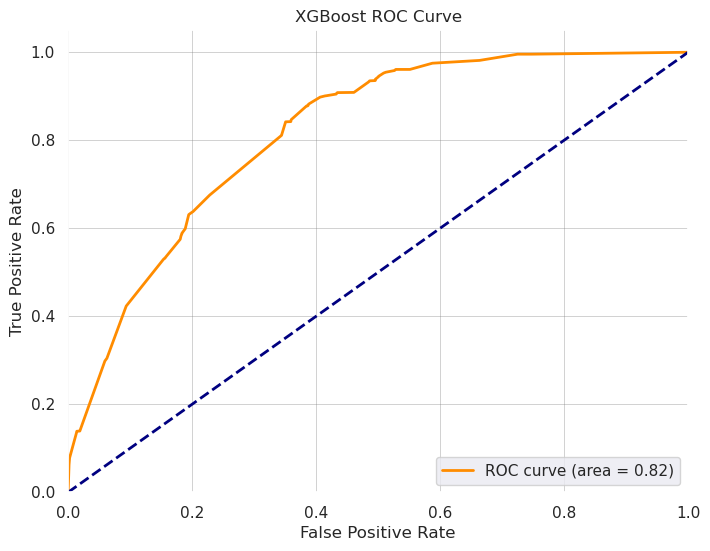

In [662]:
y_probs = model.predict(d_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')
plt.savefig(f'xgboost_roc_{time_window}.png')
plt.show()

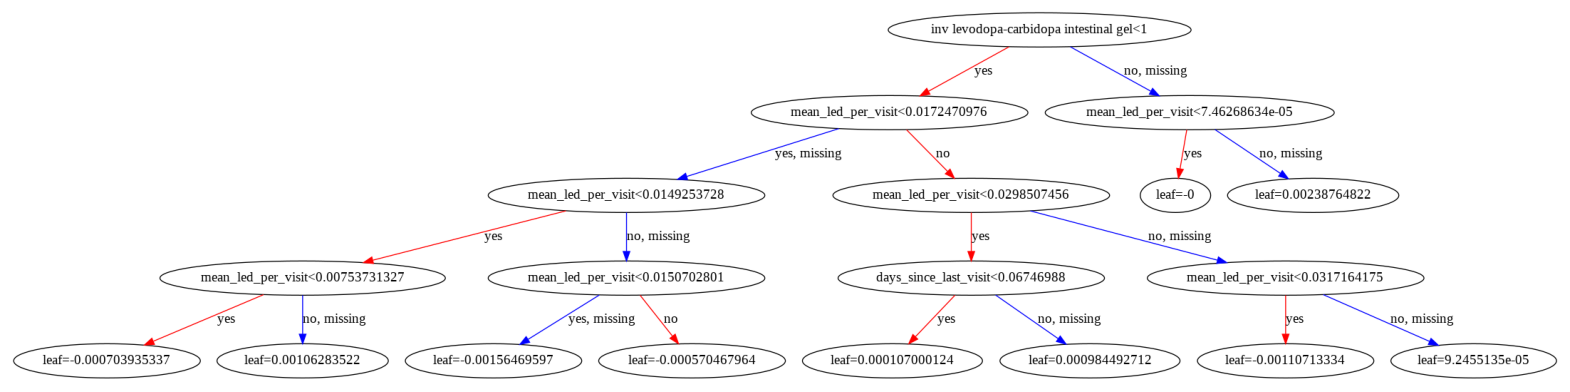

In [663]:
xgb.plot_tree(model, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(20, 20)
fig.savefig(f'xgboost_tree_{time_window}.png')

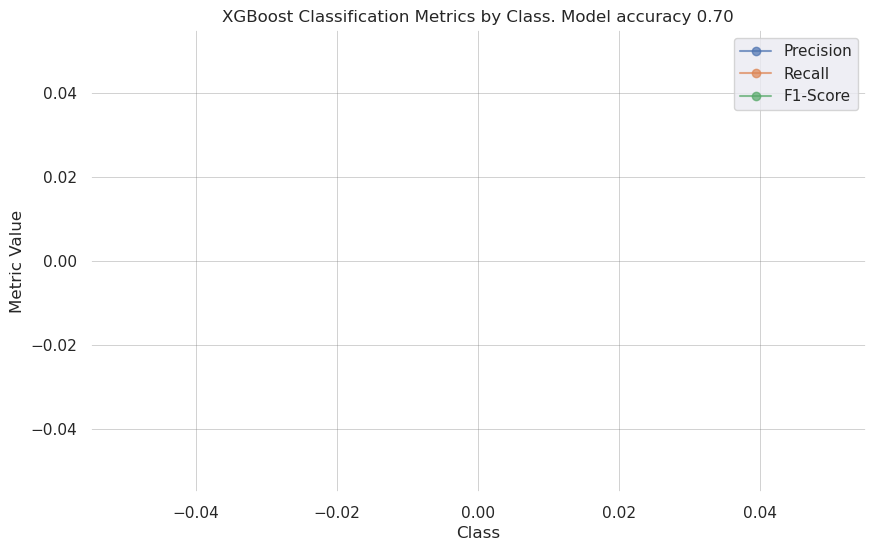

In [664]:
# Extract precision, recall, f1-score for each class
class_metrics = []
for key, value in report.items():
    if key.isdigit():
        class_metrics.append([int(key), value['precision'], value['recall'], value['f1-score']])

class_metrics.sort()  # Sort by class label

# Extract metrics for plotting
classes = [row[0] for row in class_metrics]
precision = [row[1] for row in class_metrics]
recall = [row[2] for row in class_metrics]
f1_score = [row[3] for row in class_metrics]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(classes, precision, marker='o', label='Precision', alpha=0.7)
plt.plot(classes, recall, marker='o', label='Recall', alpha=0.7)
plt.plot(classes, f1_score, marker='o', label='F1-Score', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title(f'XGBoost Classification Metrics by Class. Model accuracy {accuracy:.2f}')
plt.legend()
plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')
plt.savefig(f'xgboost_acc_{time_window}.png')
plt.show()

In [665]:
model.get_score(importance_type='weight')

{'mean_led_per_visit': 4493.0,
 'age': 45.0,
 'days_since_last_visit': 519.0,
 'home_meds': 155.0,
 'carbidopa-levodopa er': 8.0,
 'inv levodopa-carbidopa intestinal gel': 700.0,
 'pramipexole er': 22.0,
 'rasagiline mesylate': 262.0,
 'ropinirole': 96.0}

In [666]:
# Calculating the feature importance
feature_list = model.get_score(importance_type='weight')
feature_imp = pd.Series(feature_list).sort_values(ascending=False)
feature_imp_percentage = (feature_imp / feature_imp.sum()) * 100
feature_imp_percentage

mean_led_per_visit                       71.317460
inv levodopa-carbidopa intestinal gel    11.111111
days_since_last_visit                     8.238095
rasagiline mesylate                       4.158730
home_meds                                 2.460317
ropinirole                                1.523810
age                                       0.714286
pramipexole er                            0.349206
carbidopa-levodopa er                     0.126984
dtype: float64

In [667]:
non_zero_feature_imp = feature_imp_percentage[feature_imp_percentage > 1.0]
non_zero_feature_imp

mean_led_per_visit                       71.317460
inv levodopa-carbidopa intestinal gel    11.111111
days_since_last_visit                     8.238095
rasagiline mesylate                       4.158730
home_meds                                 2.460317
ropinirole                                1.523810
dtype: float64

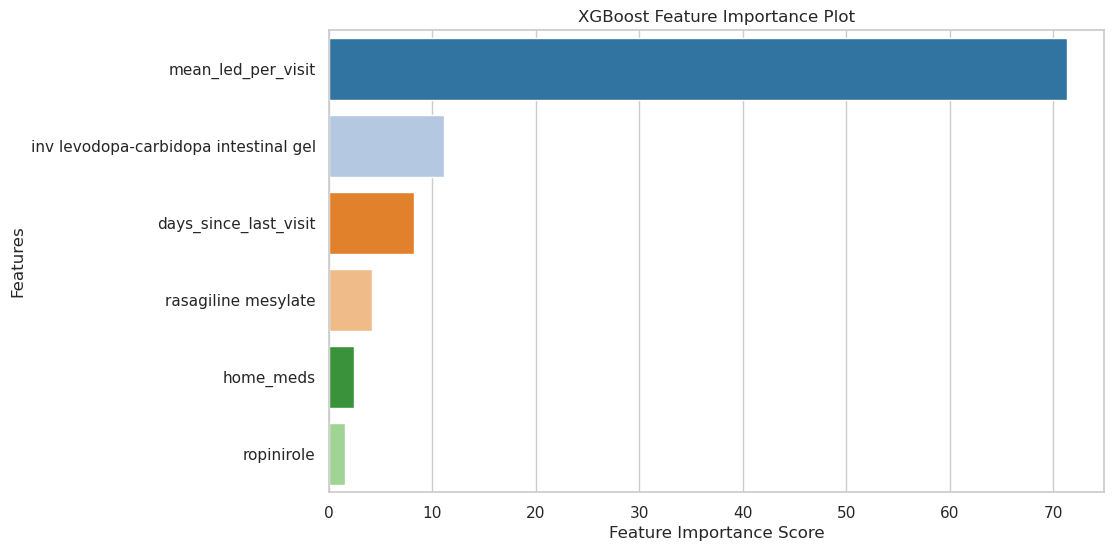

In [668]:
# Plotting feature importance
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# plt.xscale('log')
# Create a bar plot using Seaborn
sns.barplot(x=non_zero_feature_imp, y=non_zero_feature_imp.index, palette='tab20')

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance Plot')

# Show the plot
plt.savefig(f'xgboost_feature_importance_{time_window}.png')
plt.show()

Confusion Matrix

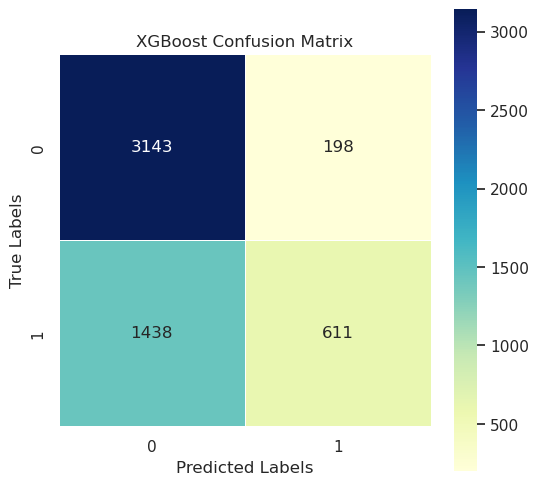

In [669]:
cm = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(6, 6)}, font_scale=1.0)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.title('XGBoost Confusion Matrix')
plt.savefig(f'xgboost_confusion_matrix_{time_window}.png')

In [670]:
shap.initjs()

In [671]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[22:59:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [672]:
shap_values.shape

(26946, 73)

In [673]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

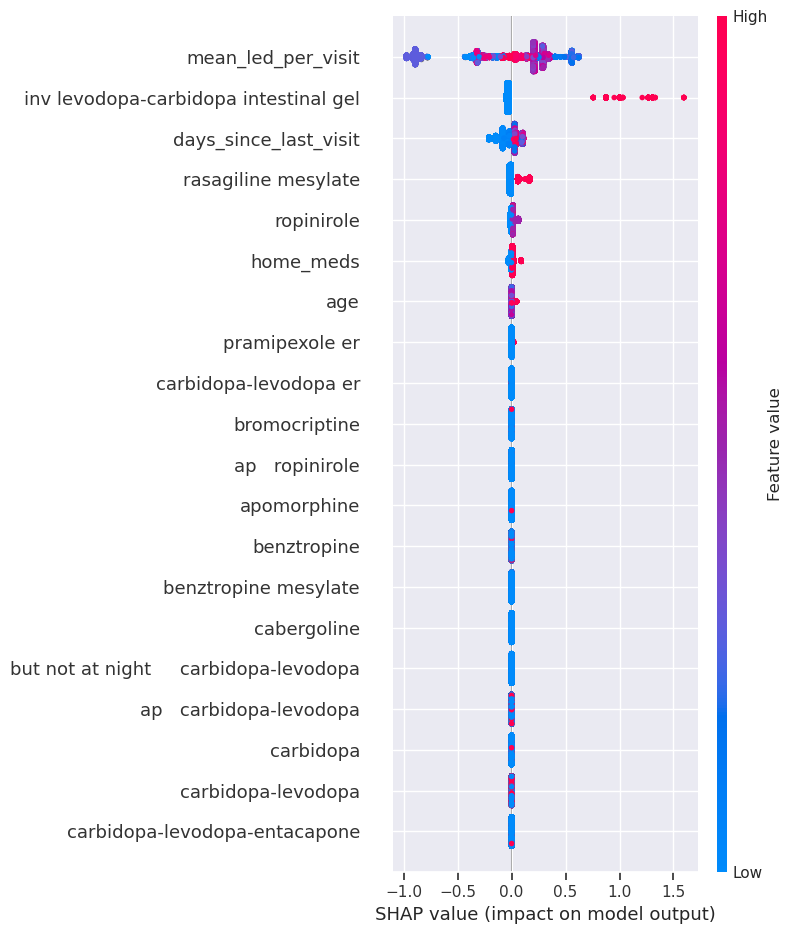

In [674]:
shap.summary_plot(shap_values, X)

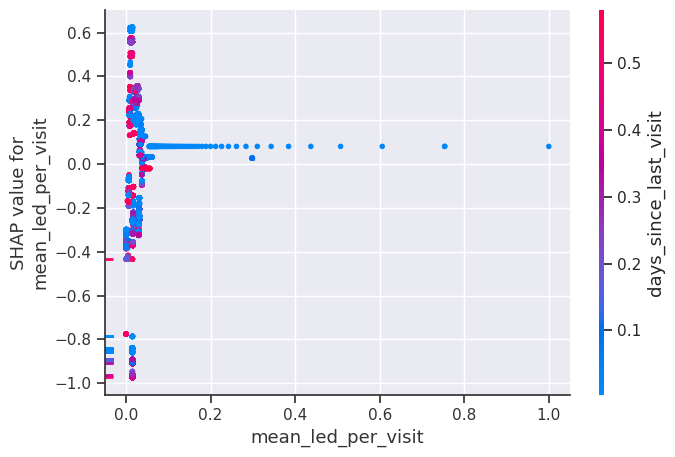

In [675]:
shap.dependence_plot("mean_led_per_visit", shap_values, X)

In [ ]:
# shap.force_plot(
#     explainer.expected_value, shap_values[:1000, :], X.iloc[:1000, :]
# )

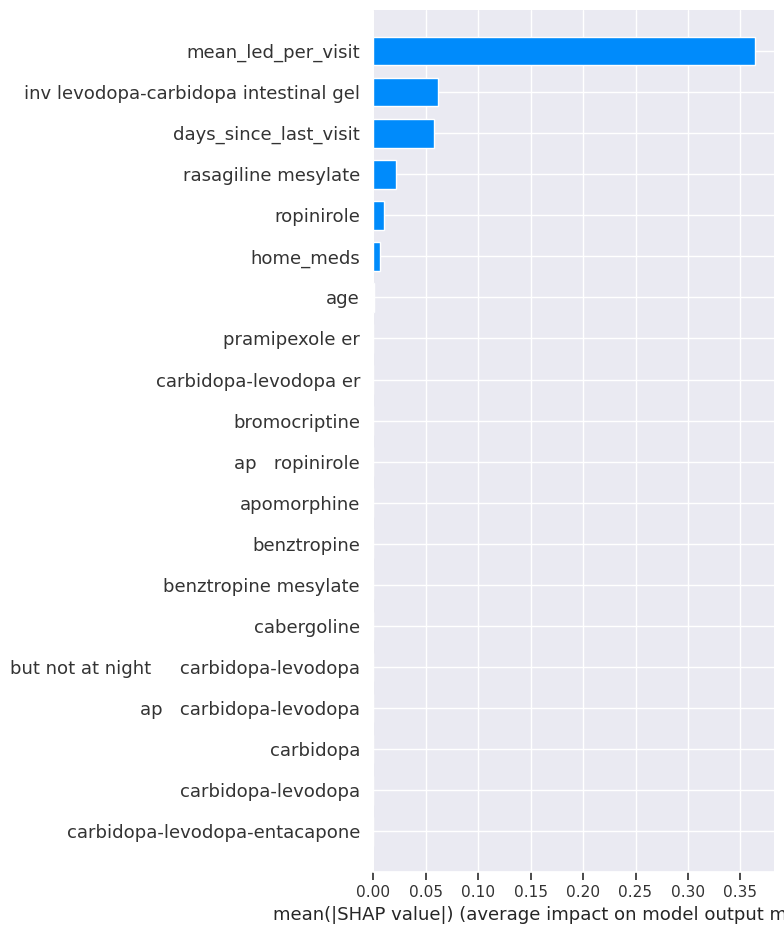

In [679]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [678]:
# for name in X_train.columns:
#     shap.dependence_plot(name, shap_values, X, display_features=X)

CatBoost Model

In [680]:
df['person_id'].nunique()

1456

In [681]:
best_params = {
    "loss_function": "Logloss",  # You can choose the appropriate loss function
    "eval_metric": "AUC",  # Area under the curve or other suitable metrics
    "iterations": 600,  # Number of trees
    "learning_rate": 0.01,
    "depth": 4,  # Max depth of trees
    "l2_leaf_reg": 0.01,  # L2 regularization
    "verbose": 100,  # Output verbosity
    "task_type": "GPU",  # If you have a GPU available, use it
}

# Create and train the CatBoost model
model = CatBoostClassifier(**best_params)
model.fit(X_train, y_train, verbose=True)  # Use verbose=True to see the training process

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("Accuracy:", accuracy)
file.write(f"AUC CatBoost Model: {accuracy} Time Window: {time_window}\n")
file.close()

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 80.4ms	remaining: 48.1s
1:	total: 99.3ms	remaining: 29.7s
2:	total: 116ms	remaining: 23.1s
3:	total: 133ms	remaining: 19.8s
4:	total: 150ms	remaining: 17.8s
5:	total: 167ms	remaining: 16.5s
6:	total: 186ms	remaining: 15.8s
7:	total: 204ms	remaining: 15.1s
8:	total: 221ms	remaining: 14.5s
9:	total: 238ms	remaining: 14s
10:	total: 255ms	remaining: 13.6s
11:	total: 271ms	remaining: 13.3s
12:	total: 291ms	remaining: 13.1s
13:	total: 308ms	remaining: 12.9s
14:	total: 324ms	remaining: 12.7s
15:	total: 342ms	remaining: 12.5s
16:	total: 358ms	remaining: 12.3s
17:	total: 375ms	remaining: 12.1s
18:	total: 392ms	remaining: 12s
19:	total: 411ms	remaining: 11.9s
20:	total: 428ms	remaining: 11.8s
21:	total: 446ms	remaining: 11.7s
22:	total: 462ms	remaining: 11.6s
23:	total: 479ms	remaining: 11.5s
24:	total: 495ms	remaining: 11.4s
25:	total: 515ms	remaining: 11.4s
26:	total: 531ms	remaining: 11.3s
27:	total: 547ms	remaining: 11.2s
28:	total: 563ms	remaining: 11.1s
29:	total: 578ms	remaining

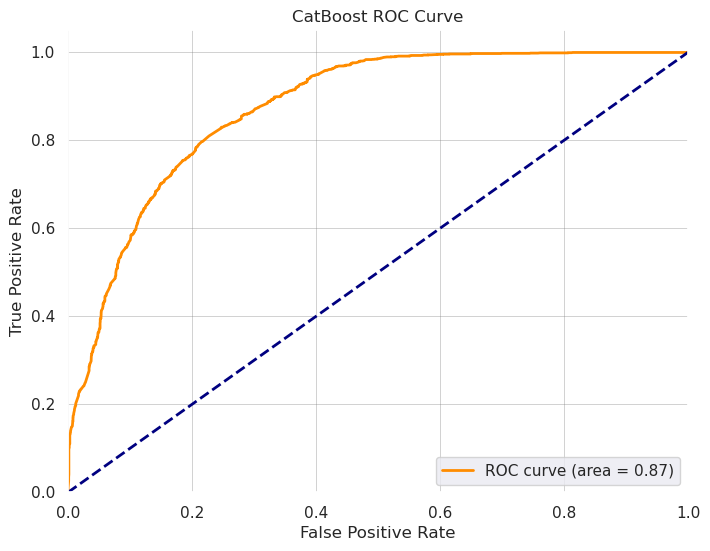

In [682]:
# Calculate the predicted probabilities for class 1 (positive class)
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')
plt.savefig(f'catboost_roc_{time_window}.png')
plt.show()

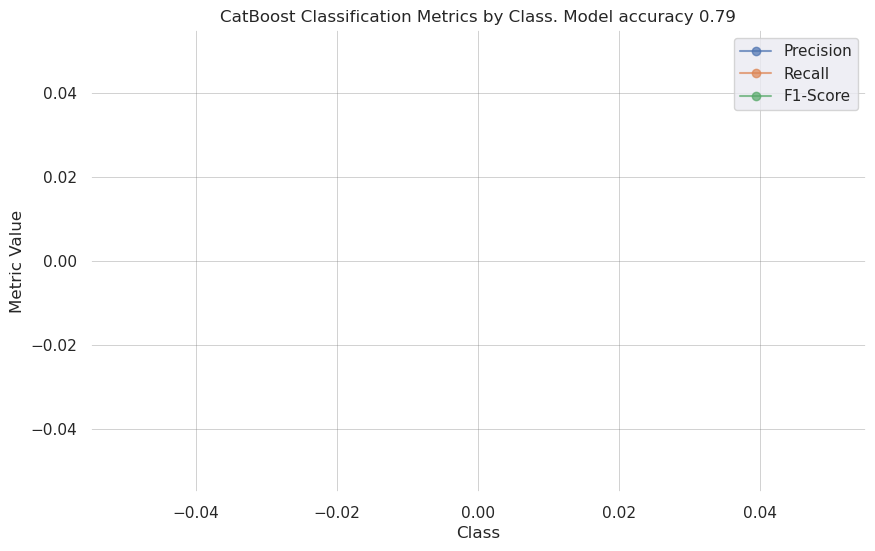

In [683]:
# Extract precision, recall, f1-score for each class
class_metrics = []
for key, value in report.items():
    if key.isdigit():
        class_metrics.append([int(key), value['precision'], value['recall'], value['f1-score']])

class_metrics.sort()  # Sort by class label

# Extract metrics for plotting
classes = [row[0] for row in class_metrics]
precision = [row[1] for row in class_metrics]
recall = [row[2] for row in class_metrics]
f1_score = [row[3] for row in class_metrics]

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(classes, precision, marker='o', label='Precision', alpha=0.7)
plt.plot(classes, recall, marker='o', label='Recall', alpha=0.7)
plt.plot(classes, f1_score, marker='o', label='F1-Score', alpha=0.7)

plt.xlabel('Class')
plt.ylabel('Metric Value')
plt.title(f'CatBoost Classification Metrics by Class. Model accuracy {accuracy:.2f}')
plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')
plt.legend()
plt.savefig(f'catboost_acc_{time_window}.png')
plt.show()

In [684]:
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp_percentage = (feature_imp / feature_imp.sum()) * 100
feature_imp_percentage

mean_led_per_visit                            54.433120
days_since_last_visit                          8.089283
ropinirole                                     5.512664
age                                            5.377028
length_of_stay                                 5.213950
                                                ...    
nf selegiline 5 mg                             0.000000
levodopa                                       0.000000
cabergoline                                    0.000000
inv carbidopa-levodopa intestinal gel pump     0.000000
inv carbidopa-levodopa intestinal gel          0.000000
Length: 73, dtype: float64

In [685]:
non_zero_feature_imp = feature_imp_percentage[feature_imp_percentage > 1.0]

In [686]:
non_zero_feature_imp

mean_led_per_visit                            54.433120
days_since_last_visit                          8.089283
ropinirole                                     5.512664
age                                            5.377028
length_of_stay                                 5.213950
benztropine                                    2.987344
pramipexole dihydrochloride                    1.977161
rasagiline mesylate                            1.782597
carbidopa                                      1.753770
inv levodopa-carbidopa intestinal gel pump     1.753404
amantadine                                     1.501745
days_to_diagnosis                              1.358830
inv levodopa-carbidopa intestinal gel          1.306789
carbidopa-levodopa-entacapone                  1.220849
dtype: float64

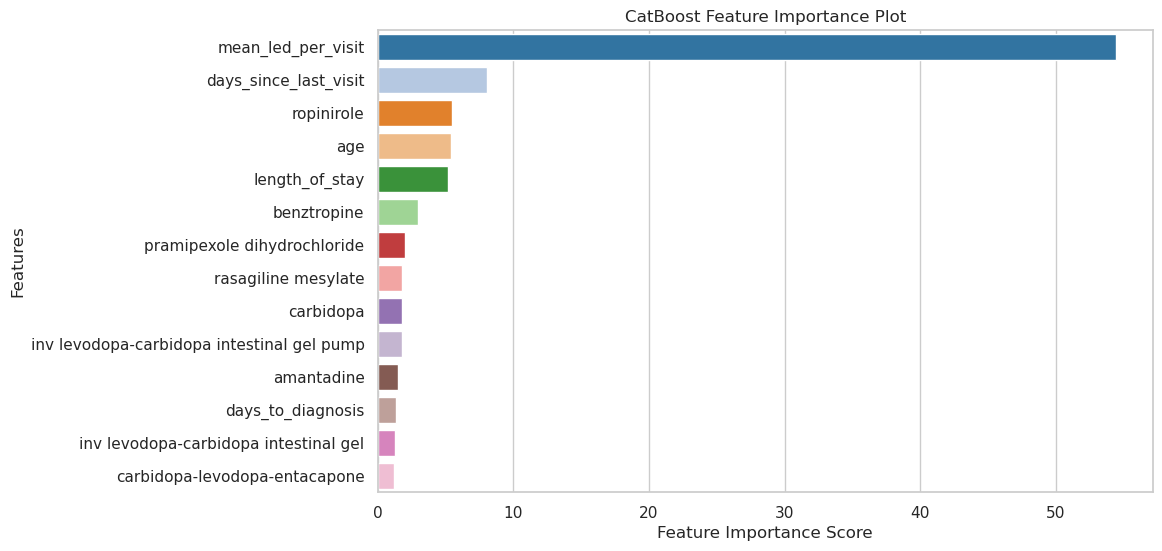

In [687]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# plt.xscale('log')
# Create a bar plot using Seaborn
sns.barplot(x=non_zero_feature_imp, y=non_zero_feature_imp.index, palette='tab20')

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance Plot')

# Show the plot
plt.savefig(f'catboost_feature_importance_{time_window}.png')
plt.show()

Confusion Matrix

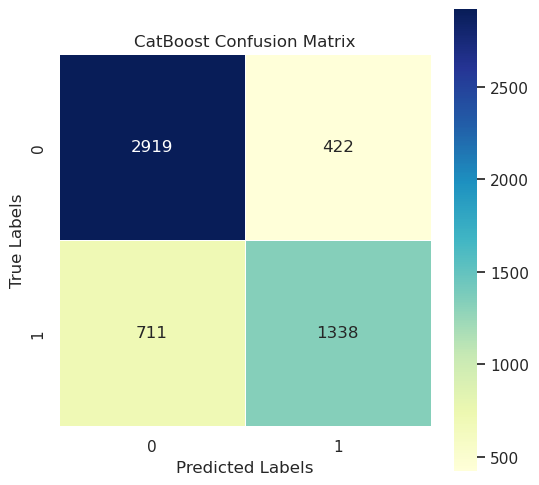

In [688]:
cm = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(6,6)}, font_scale=1.0)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.title('CatBoost Confusion Matrix')
plt.savefig(f'catboost_confusion_matrix_{time_window}.png')

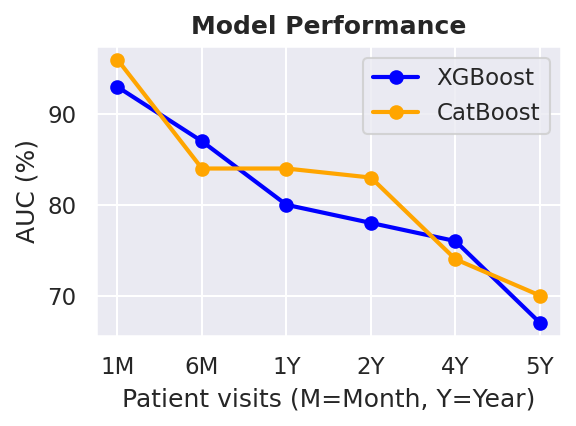

In [689]:
# AUC values for XGBoost and CatBoost models over different time periods
time_periods = ['1M', '6M', '1Y', '2Y', '4Y', '5Y']

xgboost_auc = [93, 87, 80, 78, 76, 67]
catboost_auc = [96, 84, 84, 83, 74, 70]

# Plotting the AUC over time for each model
plt.figure(figsize=(4.0, 3.0),  dpi=150)  # Adjusted width and height
plt.plot(time_periods, xgboost_auc, marker='o', label='XGBoost', color='blue', linewidth=2)
plt.plot(time_periods, catboost_auc, marker='o', label='CatBoost', color='orange', linewidth=2)

# Adding labels and title
plt.xlabel('Patient visits (M=Month, Y=Year)')
plt.ylabel('AUC (%)')
plt.title('Model Performance', weight='bold')
plt.legend()
plt.grid(True)

# Adjusting layout and spacing
plt.tight_layout()

# Display the plot
plt.savefig('AUC.png', transparent=True)
plt.show()

Hyperparameter tuning for XGBoost and CatBoost

In [691]:
# Define a parameter grid to search
param_grid_xgboost = {
    'max_depth': [4, 5, 6, 7, 8, 9],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [300, 400, 500, 600, 700, 800],
    'alpha': [0, 0.01, 0.1, 1, 10],  # L1 regularization (alpha)
    'lambda': [0, 0.01, 0.1, 1, 10],  # L2 regularization (lambda)
}

param_grid_catboost = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [.01, 0.001, 0.0001],
    'iterations': [600, 700, 800],
    # There's no L1 regularization in catboost
    'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
    # 'boosting_type': ['Plain', 'Ordered']
}

# Create a classifier
model = xgb.XGBClassifier(verbosity=2)
# model = CatBoostClassifier()

# Perform grid search with cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)
grid_search = GridSearchCV(model, param_grid_xgboost, cv=kfold, n_jobs=-1, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train a model with the best hyperparameters
best_model = xgb.XGBClassifier(**best_params)
# best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions and evaluate the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model Accuracy:", accuracy)

Fitting 10 folds for each of 3600 candidates, totalling 36000 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[CV] END alpha=0, lambda=0, learning_rate=0.1, max_depth=4, n_estimators=600; total time=   6.3s
[CV] END alpha=0, lambda=0, learning_rate=0.1, max_depth=5, n_estimators=700; total time=   5.6s
[CV] END alpha=0, lambda=0, learning_rate=0.1, max_depth=7, n_estimators=300; total time=   3.5s
[CV] END alpha=0, lambda=0, learning_rate=0.1, max_depth=7, n_estimators=800; total time=   8.3s
[CV] END alpha=0, lambda=0, learning_rate=0.1, max_depth=9, n_estimators=500; total time=   6.5s
[CV] END alpha=0, lambda=0, learning_rate=0.01, max_depth=4, n_estimators=600; total time=   5.0s
[CV] END alpha=0, lambda=0, learning_rate=0.01, max_depth=5, n_estimators=700; total time=   6.3s
[CV] END alpha=0, lambda=0, learning_rate=0.01, max_depth=7, n_estimators=300; total time=   4.6s
[CV] END alpha=0, lambda=0, learning_rate=0.01, max_depth=7, n_estimators=800; total time=  10.0s
[CV] END alpha=0, lambda=0, learning_rate=0.01, max_depth=9, n_estimators=500; total time=   9.2s
[CV] END alpha=0, lambda=